In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 14 14:16:04 2020

@author: thomas
"""

#MODULES
import os,sys
import re
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
from scipy.signal import savgol_filter
import pathlib
from matplotlib import animation
from IPython.display import display, Image, HTML
import plotly.graph_objects as go

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

In [2]:
#CONSTANTS
cwd_PYTHON = os.getcwd()
PERIOD = 0.1
DT = 5.0e-3
RADIUSLARGE = 0.002
RADIUSSMALL = 0.001
csfont = {'fontname':'Times New Roman'}

#Lists
#RLength
ThetaList=['0.0','22.5','45.0','67.5','90.0','112.5','135.0','157.5','180.0',
           '202.5','225.0','247.5','270.0','292.5','315.0','337.5']
HxList=['0.5','1.5','2.5','3.5','4.5','5.5','6.5','7.5','8.5','9.5','10.5','11.5','12.5']
HyList=['-13','-11','-9','-7','-5','-3','-1','1','3','5','7','9']
ReList = ['7']

In [3]:
def csvname(cwd,Re):
        return cwd+'/allData_Re{0}.csv'.format(Re)

def GetCSV(cwd,Re):
    data = pd.read_csv(csvname(cwd,Re),delimiter=' ')
    data = data.rename(columns={"parTheta": "parThetaBW"})
    data = data.sort_values(by=['parThetaBW','parHx','parHy','time'])
    data['parHx'], data['parHy'] = 0.5*data['parHx'], 0.5*data['parHy']
    data['Theta'] = np.pi*data['Theta']
    data = data.reset_index(drop=True)
    return data

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    return ax

In [7]:
import matplotlib

def WhichEndStateRe7(data,scheme):
    #In this function, we will determine if the pair are in an end state configuration
    #Diverge = 0: Red
    #V-Shape = 1: Blue
    #Orbit = 2: pink
    #SingleFile = 3: green
    #NOTA = 4: black
    
    #Diverge: H_bw > 10
    #V-Shape: Theta = 29 or 331; H_bw ~ 3.0R
    #Headbutt: Theta = 180; H_bw = 3.2-3.4R
    #Orbit: Theta = 180; H_bw = 3.0-3.25R
    
    #data = data.sort_values(by=['parHx','parHy','time'])
    data = data.reset_index(drop=True)
    data['State'] = 5
    data['color'] = 'black'
    data['Theta_deg'] = 180.0*data['Theta']/np.pi
    data['color_r'] = 0
    data['color_g'] = 0
    data['color_b'] = 0
    color_value = matplotlib.colors.to_rgb('black')
    for idx in range(len(data['time'])):
        #Which End State?
        #Diverge
        if(data.loc[idx,'H'] > 10.0):
            data.loc[idx,'State'] = 0
            data.loc[idx,'color'] = 'gray'
            color_value = matplotlib.colors.to_rgb('gray')
            data.loc[idx,'color_r'] = color_value[0]
            data.loc[idx,'color_g'] = color_value[1]
            data.loc[idx,'color_b'] = color_value[2]
        #V-Shape
        elif((data.loc[idx,'H'] < 3.4 and data.loc[idx,'H'] >= 3.2) and 
             ((data.loc[idx,'Theta_deg'] < 35.0 and data.loc[idx,'Theta_deg'] >= 28.0) or
              (data.loc[idx,'Theta_deg'] < 332.0 and data.loc[idx,'Theta_deg'] >= 325.0))):
            data.loc[idx,'State'] = 1
            data.loc[idx,'color'] = 'blue'
            #color_value = matplotlib.colors.to_rgb('blue')
            if(scheme=='bright'):
                data.loc[idx,'color_r'] = 141
                data.loc[idx,'color_g'] = 160
                data.loc[idx,'color_b'] = 203
            elif(scheme=='dark'):
                data.loc[idx,'color_r'] = 117
                data.loc[idx,'color_g'] = 112
                data.loc[idx,'color_b'] = 179
        #Headbutt
        elif((data.loc[idx,'H'] < 3.4 and data.loc[idx,'H'] >= 3.2) and 
             (data.loc[idx,'Theta_deg'] < 185.0 and data.loc[idx,'Theta_deg'] >= 175.0) and
             (data.loc[idx,'Hx'] <= 0.1 and data.loc[idx,'Hx'] > -0.1)):
            data.loc[idx,'State'] = 3
            data.loc[idx,'color'] = 'orange'
            #color_value = matplotlib.colors.to_rgb('orange')
            if(scheme=='bright'):
                data.loc[idx,'color_r'] = 252
                data.loc[idx,'color_g'] = 141
                data.loc[idx,'color_b'] = 98
            elif(scheme=='dark'):
                data.loc[idx,'color_r'] = 217
                data.loc[idx,'color_g'] = 95
                data.loc[idx,'color_b'] = 2
        #Orbit
        elif((data.loc[idx,'H'] < 3.4 and data.loc[idx,'H'] >= 3.2) and 
             (data.loc[idx,'Theta_deg'] < 185.0 and data.loc[idx,'Theta_deg'] >= 175.0) ):
            data.loc[idx,'State'] = 2
            data.loc[idx,'color'] = 'pink'
            #color_value = matplotlib.colors.to_rgb('orange')
            if(scheme=='bright'):
                data.loc[idx,'color_r'] = 252
                data.loc[idx,'color_g'] = 141
                data.loc[idx,'color_b'] = 98
            elif(scheme=='dark'):
                data.loc[idx,'color_r'] = 231
                data.loc[idx,'color_g'] = 41
                data.loc[idx,'color_b'] = 138
        #SingleFile
        elif((data.loc[idx,'H'] < 4.8 and data.loc[idx,'H'] >= 4.6) and 
             ((data.loc[idx,'Theta_deg'] < 30.0 and data.loc[idx,'Theta_deg'] >= 0.0) or 
              (data.loc[idx,'Theta_deg'] < 360.0 and data.loc[idx,'Theta_deg'] >= 330.0))):
            data.loc[idx,'State'] = 4
            data.loc[idx,'color'] = 'green'
            #color_value = matplotlib.colors.to_rgb('green')
            if(scheme=='bright'):
                data.loc[idx,'color_r'] = 102
                data.loc[idx,'color_g'] = 194
                data.loc[idx,'color_b'] = 165
            elif(scheme=='dark'):
                data.loc[idx,'color_r'] = 27
                data.loc[idx,'color_g'] = 158
                data.loc[idx,'color_b'] = 119
        else:
            color_value= matplotlib.colors.to_rgb('black')
        #data.loc[idx,'color_r'] = color_value[0]
        #data.loc[idx,'color_g'] = color_value[1]
        #data.loc[idx,'color_b'] = color_value[2]
    
    return data


In [5]:
#Grab all time data for Re = 2 and Re = 10
#Store data in allData list
#For each Re, get all data

Re = ReList[0]
#Get Rd1 csv data
data = GetCSV(cwd_PYTHON,Re)
print('CSV gotten')
allData = data.copy()

CSV gotten


In [8]:
#Grab Last timestep configuration data and combine in new dataset
#Do so for each Re (2,10)
scheme='dark'

endDict = {'parThetaBW':[],'parHx':[],
       'parHy':[],'ThetaBW':[],
       'Hx':[],'Hy':[],'H':[],
       'Nosc':[],'State':[],
       'color':[],'color_r':[],
       'color_g':[],'color_b':[]}

endSimData = pd.DataFrame(data=endDict)
Re = ReList[0]
allSimData = allData.copy()
print(allSimData['time'].head())
for Theta in ThetaList:
    print('Theta = ',Theta)
    thetaData = allSimData[allSimData['parThetaBW'] <= float(Theta)+0.01].copy()
    thetaData = thetaData[thetaData['parThetaBW'] >= float(Theta)-0.01].copy()
    for Hx in HxList:
        #print('Hx = ',float(Hx)/2.0)
        hxData = thetaData[thetaData['parHx'] <= float(Hx)/2.0 + 0.01].copy()
        hxData = hxData[hxData['parHx'] >= float(Hx)/2.0 - 0.01].copy()
        HyList = hxData['parHy'].values.tolist()
        HyList = [round(value,1) for value in HyList]
        HyList = list(set(HyList))
        for HyValue in HyList:
            HyValue2 = round(float(HyValue),1)
            #print('Hy = ',HyValue2)
            #print(HyValue2)
            hyData = hxData[hxData['parHy'] <= HyValue2+0.01].copy()
            hyData = hyData[hyData['parHy'] >= HyValue2-0.01].copy()
            hyData = hyData.sort_values(by=['time'])
            hyData = hyData.reset_index(drop=True)
            simData = WhichEndStateRe7(hyData,scheme)
            #print(simData.head(20))
            lastData = simData.tail(1)
            lastIndexList = lastData.index.values
            lastIndex = lastIndexList[0]
            if(lastIndex != 200):
                print('LastIndex: ',lastIndex)
            #Find when Simulation is in end state
            count = 5
            boolEnd = 0
            '''
            if 0.5*float(Hx) == 4.25 and HyValue2 == -0.5:
                print(simData)
                sys.exit(0)
            '''
            for count in range(5,lastIndex-5):
                State = simData.loc[count,'State']
                if(State != 5):
                    b4State = simData.loc[count-5,'State']
                    a4State = simData.loc[lastIndex-5,'State']
                    if(State == b4State and State == a4State):
                        #Simulation is in end state
                        print('End State! Theta: {0}, Hx: {1}, Hy:{2}, Nosc: {3}'.format(Theta,float(Hx)/2.0,HyValue2,count))
                        #Create a database with sim information
                        simDict = {'parThetaBW':[simData.loc[count,'parThetaBW']],'parHx':[simData.loc[count,'parHx']],
                                   'parHy':[simData.loc[count,'parHy']],'ThetaBW':[simData.loc[count,'Theta']],
                                   'Hx':[simData.loc[count,'Hx']],'Hy':[simData.loc[count,'Hy']],'H':[simData.loc[count,'H']],
                                   'Nosc':[count],'State':[simData.loc[count,'State']],
                                   'color':[simData.loc[count,'color']],'color_r':[simData.loc[count,'color_r']],
                                   'color_g':[simData.loc[count,'color_g']],'color_b':[simData.loc[count,'color_b']]}
                        simData = pd.DataFrame(data=simDict)

                        simData['vx'] = (simData['Hx']-simData['parHx'])/simData['Nosc']
                        simData['vy'] = (simData['Hy']-simData['parHy'])/simData['Nosc']
                        endSimData = pd.concat([endSimData,simData],ignore_index=True)
                        boolEnd = 1
                        break
            if(boolEnd == 0):
                print('No End State! Theta: {0}, Hx: {1}, Hy:{2}, Nosc: {3}'.format(Theta,float(Hx)/2.0,HyValue2,count))
endSimData = endSimData.sort_values(by=['parThetaBW','parHx','parHy'])
endSimData = endSimData.reset_index(drop=True)

endSimData['xval'] = endSimData['parHx']*np.cos(endSimData['parThetaBW']*np.pi/180.0)
endSimData['yval'] = endSimData['parHx']*np.sin(endSimData['parThetaBW']*np.pi/180.0)
endSimData['zval'] = endSimData['parHy']
endSimData = endSimData.sort_values(by=['zval','yval','xval'])
endSimData = endSimData.reset_index(drop=True)
endSimData = endSimData[endSimData['color'] != 'black'].copy()
endSimData = endSimData.reset_index(drop=True)
endSimData['ColorString'] = 0.0
endSimData['color_tuple'] = 's'
for jdx in range(len(endSimData['color_r'])):
    endSimData.loc[jdx,'ColorString'] = 'rgb({0},{1},{2})'.format(endSimData.loc[jdx,'color_r'],
                                                                  endSimData.loc[jdx,'color_g'],
                                                                  endSimData.loc[jdx,'color_b'])
    endSimData = endSimData.set_value(jdx,'color_tuple', (endSimData.loc[jdx,'color_r']/255.0,endSimData.loc[jdx,'color_g']/255.0,endSimData.loc[jdx,'color_b']/255.0))

endSimData.to_csv(cwd_PYTHON+'/endData_Re{0}_lt.csv'.format(Re),index=False,sep=' ',float_format='%.5e')
#Store in endData list
endData = endSimData.copy()
#Now that we have the end states, we can make slices of the data with the different initial parameters



0    0.0
1    0.1
2    0.2
3    0.3
4    0.4
Name: time, dtype: float64
Theta =  0.0
No End State! Theta: 0.0, Hx: 0.25, Hy:-6.5, Nosc: 194
No End State! Theta: 0.0, Hx: 0.25, Hy:-5.5, Nosc: 194
No End State! Theta: 0.0, Hx: 0.25, Hy:-4.5, Nosc: 194
No End State! Theta: 0.0, Hx: 0.25, Hy:4.5, Nosc: 194
No End State! Theta: 0.0, Hx: 0.75, Hy:-6.5, Nosc: 194
End State! Theta: 0.0, Hx: 0.75, Hy:-5.5, Nosc: 21
No End State! Theta: 0.0, Hx: 0.75, Hy:-4.5, Nosc: 194


/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




No End State! Theta: 0.0, Hx: 0.75, Hy:4.5, Nosc: 194
No End State! Theta: 0.0, Hx: 1.25, Hy:-6.5, Nosc: 194
End State! Theta: 0.0, Hx: 1.25, Hy:-5.5, Nosc: 13
End State! Theta: 0.0, Hx: 1.25, Hy:-4.5, Nosc: 5
No End State! Theta: 0.0, Hx: 1.25, Hy:4.5, Nosc: 194
No End State! Theta: 0.0, Hx: 1.75, Hy:-6.5, Nosc: 194
End State! Theta: 0.0, Hx: 1.75, Hy:-5.5, Nosc: 22
End State! Theta: 0.0, Hx: 1.75, Hy:-4.5, Nosc: 9
End State! Theta: 0.0, Hx: 1.75, Hy:4.5, Nosc: 10
End State! Theta: 0.0, Hx: 2.25, Hy:-0.5, Nosc: 21
End State! Theta: 0.0, Hx: 2.25, Hy:0.5, Nosc: 21
End State! Theta: 0.0, Hx: 2.25, Hy:1.5, Nosc: 21
End State! Theta: 0.0, Hx: 2.25, Hy:2.5, Nosc: 26
End State! Theta: 0.0, Hx: 2.25, Hy:3.5, Nosc: 10
No End State! Theta: 0.0, Hx: 2.25, Hy:4.5, Nosc: 194
No End State! Theta: 0.0, Hx: 2.25, Hy:-6.5, Nosc: 194
No End State! Theta: 0.0, Hx: 2.25, Hy:-5.5, Nosc: 194
No End State! Theta: 0.0, Hx: 2.25, Hy:-4.5, Nosc: 194
No End State! Theta: 0.0, Hx: 2.25, Hy:-3.5, Nosc: 194
End S

End State! Theta: 22.5, Hx: 3.25, Hy:3.5, Nosc: 73
End State! Theta: 22.5, Hx: 3.25, Hy:4.5, Nosc: 164
No End State! Theta: 22.5, Hx: 3.25, Hy:-6.5, Nosc: 194
No End State! Theta: 22.5, Hx: 3.25, Hy:-5.5, Nosc: 194
No End State! Theta: 22.5, Hx: 3.25, Hy:-4.5, Nosc: 194
End State! Theta: 22.5, Hx: 3.25, Hy:-3.5, Nosc: 46
End State! Theta: 22.5, Hx: 3.25, Hy:-2.5, Nosc: 52
End State! Theta: 22.5, Hx: 3.25, Hy:-1.5, Nosc: 39
End State! Theta: 22.5, Hx: 3.75, Hy:-0.5, Nosc: 42
End State! Theta: 22.5, Hx: 3.75, Hy:0.5, Nosc: 40
End State! Theta: 22.5, Hx: 3.75, Hy:1.5, Nosc: 47
End State! Theta: 22.5, Hx: 3.75, Hy:2.5, Nosc: 54
End State! Theta: 22.5, Hx: 3.75, Hy:3.5, Nosc: 90
End State! Theta: 22.5, Hx: 3.75, Hy:4.5, Nosc: 187
End State! Theta: 22.5, Hx: 3.75, Hy:-6.5, Nosc: 46
No End State! Theta: 22.5, Hx: 3.75, Hy:-5.5, Nosc: 194
No End State! Theta: 22.5, Hx: 3.75, Hy:-4.5, Nosc: 194
No End State! Theta: 22.5, Hx: 3.75, Hy:-3.5, Nosc: 194
End State! Theta: 22.5, Hx: 3.75, Hy:-2.5, No

End State! Theta: 45.0, Hx: 4.75, Hy:-6.5, Nosc: 59
End State! Theta: 45.0, Hx: 4.75, Hy:-5.5, Nosc: 77
End State! Theta: 45.0, Hx: 4.75, Hy:-4.5, Nosc: 67
End State! Theta: 45.0, Hx: 4.75, Hy:-3.5, Nosc: 67
End State! Theta: 45.0, Hx: 4.75, Hy:-2.5, Nosc: 133
End State! Theta: 45.0, Hx: 4.75, Hy:-1.5, Nosc: 154
End State! Theta: 45.0, Hx: 5.25, Hy:-0.5, Nosc: 151
End State! Theta: 45.0, Hx: 5.25, Hy:0.5, Nosc: 171
No End State! Theta: 45.0, Hx: 5.25, Hy:1.5, Nosc: 194
End State! Theta: 45.0, Hx: 5.25, Hy:2.5, Nosc: 151
End State! Theta: 45.0, Hx: 5.25, Hy:3.5, Nosc: 162
End State! Theta: 45.0, Hx: 5.25, Hy:4.5, Nosc: 149
End State! Theta: 45.0, Hx: 5.25, Hy:-6.5, Nosc: 109
End State! Theta: 45.0, Hx: 5.25, Hy:-5.5, Nosc: 93
End State! Theta: 45.0, Hx: 5.25, Hy:-4.5, Nosc: 81
End State! Theta: 45.0, Hx: 5.25, Hy:-3.5, Nosc: 143
End State! Theta: 45.0, Hx: 5.25, Hy:-2.5, Nosc: 121
End State! Theta: 45.0, Hx: 5.25, Hy:-1.5, Nosc: 120
End State! Theta: 45.0, Hx: 5.75, Hy:-0.5, Nosc: 114
E

End State! Theta: 67.5, Hx: 6.25, Hy:4.5, Nosc: 63
End State! Theta: 67.5, Hx: 6.25, Hy:-6.5, Nosc: 173
End State! Theta: 67.5, Hx: 6.25, Hy:-5.5, Nosc: 171
End State! Theta: 67.5, Hx: 6.25, Hy:-4.5, Nosc: 120
End State! Theta: 67.5, Hx: 6.25, Hy:-3.5, Nosc: 99
End State! Theta: 67.5, Hx: 6.25, Hy:-2.5, Nosc: 87
End State! Theta: 67.5, Hx: 6.25, Hy:-1.5, Nosc: 84
Theta =  90.0
End State! Theta: 90.0, Hx: 0.25, Hy:3.5, Nosc: 66
End State! Theta: 90.0, Hx: 0.25, Hy:4.5, Nosc: 141
End State! Theta: 90.0, Hx: 0.25, Hy:-6.5, Nosc: 61
End State! Theta: 90.0, Hx: 0.25, Hy:-5.5, Nosc: 44
End State! Theta: 90.0, Hx: 0.25, Hy:-4.5, Nosc: 34
End State! Theta: 90.0, Hx: 0.75, Hy:3.5, Nosc: 60
End State! Theta: 90.0, Hx: 0.75, Hy:4.5, Nosc: 108
End State! Theta: 90.0, Hx: 0.75, Hy:-6.5, Nosc: 60
End State! Theta: 90.0, Hx: 0.75, Hy:-5.5, Nosc: 42
End State! Theta: 90.0, Hx: 0.75, Hy:-4.5, Nosc: 34
End State! Theta: 90.0, Hx: 1.25, Hy:3.5, Nosc: 60
End State! Theta: 90.0, Hx: 1.25, Hy:4.5, Nosc: 105

End State! Theta: 112.5, Hx: 2.75, Hy:1.5, Nosc: 40
End State! Theta: 112.5, Hx: 2.75, Hy:2.5, Nosc: 47
End State! Theta: 112.5, Hx: 2.75, Hy:3.5, Nosc: 63
End State! Theta: 112.5, Hx: 2.75, Hy:4.5, Nosc: 146
End State! Theta: 112.5, Hx: 2.75, Hy:-6.5, Nosc: 73
End State! Theta: 112.5, Hx: 2.75, Hy:-5.5, Nosc: 53
End State! Theta: 112.5, Hx: 2.75, Hy:-4.5, Nosc: 41
End State! Theta: 112.5, Hx: 2.75, Hy:-3.5, Nosc: 35
End State! Theta: 112.5, Hx: 3.25, Hy:-0.5, Nosc: 47
End State! Theta: 112.5, Hx: 3.25, Hy:0.5, Nosc: 54
End State! Theta: 112.5, Hx: 3.25, Hy:1.5, Nosc: 51
End State! Theta: 112.5, Hx: 3.25, Hy:2.5, Nosc: 55
End State! Theta: 112.5, Hx: 3.25, Hy:3.5, Nosc: 77
No End State! Theta: 112.5, Hx: 3.25, Hy:4.5, Nosc: 194
End State! Theta: 112.5, Hx: 3.25, Hy:-6.5, Nosc: 78
End State! Theta: 112.5, Hx: 3.25, Hy:-5.5, Nosc: 57
End State! Theta: 112.5, Hx: 3.25, Hy:-4.5, Nosc: 44
End State! Theta: 112.5, Hx: 3.25, Hy:-3.5, Nosc: 38
End State! Theta: 112.5, Hx: 3.25, Hy:-2.5, Nosc: 

End State! Theta: 135.0, Hx: 4.25, Hy:3.5, Nosc: 130
End State! Theta: 135.0, Hx: 4.25, Hy:4.5, Nosc: 85
End State! Theta: 135.0, Hx: 4.25, Hy:-6.5, Nosc: 117
End State! Theta: 135.0, Hx: 4.25, Hy:-5.5, Nosc: 95
End State! Theta: 135.0, Hx: 4.25, Hy:-4.5, Nosc: 69
End State! Theta: 135.0, Hx: 4.25, Hy:-3.5, Nosc: 64
End State! Theta: 135.0, Hx: 4.25, Hy:-2.5, Nosc: 66
End State! Theta: 135.0, Hx: 4.25, Hy:-1.5, Nosc: 43
End State! Theta: 135.0, Hx: 4.75, Hy:-0.5, Nosc: 58
End State! Theta: 135.0, Hx: 4.75, Hy:0.5, Nosc: 174
End State! Theta: 135.0, Hx: 4.75, Hy:1.5, Nosc: 108
End State! Theta: 135.0, Hx: 4.75, Hy:2.5, Nosc: 114
End State! Theta: 135.0, Hx: 4.75, Hy:3.5, Nosc: 92
End State! Theta: 135.0, Hx: 4.75, Hy:4.5, Nosc: 70
End State! Theta: 135.0, Hx: 4.75, Hy:-6.5, Nosc: 126
End State! Theta: 135.0, Hx: 4.75, Hy:-5.5, Nosc: 90
End State! Theta: 135.0, Hx: 4.75, Hy:-4.5, Nosc: 75
End State! Theta: 135.0, Hx: 4.75, Hy:-3.5, Nosc: 62
End State! Theta: 135.0, Hx: 4.75, Hy:-2.5, Nos

End State! Theta: 157.5, Hx: 5.75, Hy:2.5, Nosc: 65
End State! Theta: 157.5, Hx: 5.75, Hy:3.5, Nosc: 60
End State! Theta: 157.5, Hx: 5.75, Hy:4.5, Nosc: 49
No End State! Theta: 157.5, Hx: 5.75, Hy:-6.5, Nosc: 194
End State! Theta: 157.5, Hx: 5.75, Hy:-5.5, Nosc: 171
End State! Theta: 157.5, Hx: 5.75, Hy:-4.5, Nosc: 128
End State! Theta: 157.5, Hx: 5.75, Hy:-3.5, Nosc: 115
End State! Theta: 157.5, Hx: 5.75, Hy:-2.5, Nosc: 95
End State! Theta: 157.5, Hx: 5.75, Hy:-1.5, Nosc: 81
End State! Theta: 157.5, Hx: 6.25, Hy:-0.5, Nosc: 138
No End State! Theta: 157.5, Hx: 6.25, Hy:0.5, Nosc: 194
End State! Theta: 157.5, Hx: 6.25, Hy:1.5, Nosc: 62
End State! Theta: 157.5, Hx: 6.25, Hy:2.5, Nosc: 57
End State! Theta: 157.5, Hx: 6.25, Hy:3.5, Nosc: 51
End State! Theta: 157.5, Hx: 6.25, Hy:4.5, Nosc: 42
No End State! Theta: 157.5, Hx: 6.25, Hy:-6.5, Nosc: 194
No End State! Theta: 157.5, Hx: 6.25, Hy:-5.5, Nosc: 194
End State! Theta: 157.5, Hx: 6.25, Hy:-4.5, Nosc: 178
End State! Theta: 157.5, Hx: 6.25

End State! Theta: 202.5, Hx: 1.25, Hy:3.5, Nosc: 31
End State! Theta: 202.5, Hx: 1.25, Hy:-6.5, Nosc: 45
End State! Theta: 202.5, Hx: 1.25, Hy:-5.5, Nosc: 56
End State! Theta: 202.5, Hx: 1.25, Hy:4.5, Nosc: 83
End State! Theta: 202.5, Hx: 1.75, Hy:2.5, Nosc: 26
End State! Theta: 202.5, Hx: 1.75, Hy:3.5, Nosc: 44
End State! Theta: 202.5, Hx: 1.75, Hy:4.5, Nosc: 134
End State! Theta: 202.5, Hx: 1.75, Hy:-6.5, Nosc: 35
End State! Theta: 202.5, Hx: 1.75, Hy:-5.5, Nosc: 44
End State! Theta: 202.5, Hx: 2.25, Hy:1.5, Nosc: 29
End State! Theta: 202.5, Hx: 2.25, Hy:2.5, Nosc: 60
End State! Theta: 202.5, Hx: 2.25, Hy:3.5, Nosc: 80
End State! Theta: 202.5, Hx: 2.25, Hy:4.5, Nosc: 140
End State! Theta: 202.5, Hx: 2.25, Hy:-6.5, Nosc: 38
End State! Theta: 202.5, Hx: 2.25, Hy:-5.5, Nosc: 39
End State! Theta: 202.5, Hx: 2.75, Hy:0.5, Nosc: 20
End State! Theta: 202.5, Hx: 2.75, Hy:1.5, Nosc: 35
No End State! Theta: 202.5, Hx: 2.75, Hy:2.5, Nosc: 194
End State! Theta: 202.5, Hx: 2.75, Hy:3.5, Nosc: 177

End State! Theta: 225.0, Hx: 4.25, Hy:0.5, Nosc: 32
End State! Theta: 225.0, Hx: 4.25, Hy:1.5, Nosc: 38
End State! Theta: 225.0, Hx: 4.25, Hy:2.5, Nosc: 53
End State! Theta: 225.0, Hx: 4.25, Hy:3.5, Nosc: 87
End State! Theta: 225.0, Hx: 4.25, Hy:4.5, Nosc: 163
End State! Theta: 225.0, Hx: 4.25, Hy:-6.5, Nosc: 42
End State! Theta: 225.0, Hx: 4.25, Hy:-5.5, Nosc: 38
End State! Theta: 225.0, Hx: 4.25, Hy:-4.5, Nosc: 36
End State! Theta: 225.0, Hx: 4.25, Hy:-3.5, Nosc: 69
End State! Theta: 225.0, Hx: 4.25, Hy:-2.5, Nosc: 41
End State! Theta: 225.0, Hx: 4.25, Hy:-1.5, Nosc: 36
End State! Theta: 225.0, Hx: 4.75, Hy:-0.5, Nosc: 35
End State! Theta: 225.0, Hx: 4.75, Hy:0.5, Nosc: 39
End State! Theta: 225.0, Hx: 4.75, Hy:1.5, Nosc: 44
End State! Theta: 225.0, Hx: 4.75, Hy:2.5, Nosc: 60
End State! Theta: 225.0, Hx: 4.75, Hy:3.5, Nosc: 97
End State! Theta: 225.0, Hx: 4.75, Hy:4.5, Nosc: 158
End State! Theta: 225.0, Hx: 4.75, Hy:-6.5, Nosc: 46
End State! Theta: 225.0, Hx: 4.75, Hy:-5.5, Nosc: 41
E

End State! Theta: 247.5, Hx: 5.75, Hy:-3.5, Nosc: 41
End State! Theta: 247.5, Hx: 5.75, Hy:-2.5, Nosc: 88
End State! Theta: 247.5, Hx: 5.75, Hy:-1.5, Nosc: 56
End State! Theta: 247.5, Hx: 6.25, Hy:-0.5, Nosc: 56
End State! Theta: 247.5, Hx: 6.25, Hy:0.5, Nosc: 53
End State! Theta: 247.5, Hx: 6.25, Hy:1.5, Nosc: 57
End State! Theta: 247.5, Hx: 6.25, Hy:2.5, Nosc: 68
End State! Theta: 247.5, Hx: 6.25, Hy:3.5, Nosc: 88
End State! Theta: 247.5, Hx: 6.25, Hy:4.5, Nosc: 120
End State! Theta: 247.5, Hx: 6.25, Hy:-6.5, Nosc: 54
End State! Theta: 247.5, Hx: 6.25, Hy:-5.5, Nosc: 49
End State! Theta: 247.5, Hx: 6.25, Hy:-4.5, Nosc: 45
End State! Theta: 247.5, Hx: 6.25, Hy:-3.5, Nosc: 46
End State! Theta: 247.5, Hx: 6.25, Hy:-2.5, Nosc: 89
End State! Theta: 247.5, Hx: 6.25, Hy:-1.5, Nosc: 64
Theta =  270.0
End State! Theta: 270.0, Hx: 0.25, Hy:3.5, Nosc: 70
No End State! Theta: 270.0, Hx: 0.25, Hy:4.5, Nosc: 194
End State! Theta: 270.0, Hx: 0.25, Hy:-6.5, Nosc: 65
End State! Theta: 270.0, Hx: 0.25

End State! Theta: 292.5, Hx: 2.75, Hy:-6.5, Nosc: 61
End State! Theta: 292.5, Hx: 2.75, Hy:-5.5, Nosc: 45
End State! Theta: 292.5, Hx: 2.75, Hy:-4.5, Nosc: 33
End State! Theta: 292.5, Hx: 2.75, Hy:-3.5, Nosc: 18
End State! Theta: 292.5, Hx: 3.25, Hy:3.5, Nosc: 44
End State! Theta: 292.5, Hx: 3.25, Hy:4.5, Nosc: 56
End State! Theta: 292.5, Hx: 3.25, Hy:-6.5, Nosc: 59
End State! Theta: 292.5, Hx: 3.25, Hy:-5.5, Nosc: 45
End State! Theta: 292.5, Hx: 3.25, Hy:-4.5, Nosc: 35
End State! Theta: 292.5, Hx: 3.25, Hy:-3.5, Nosc: 27
End State! Theta: 292.5, Hx: 3.75, Hy:-0.5, Nosc: 13
End State! Theta: 292.5, Hx: 3.75, Hy:0.5, Nosc: 44
End State! Theta: 292.5, Hx: 3.75, Hy:1.5, Nosc: 37
End State! Theta: 292.5, Hx: 3.75, Hy:2.5, Nosc: 38
End State! Theta: 292.5, Hx: 3.75, Hy:3.5, Nosc: 43
End State! Theta: 292.5, Hx: 3.75, Hy:4.5, Nosc: 40
End State! Theta: 292.5, Hx: 3.75, Hy:-6.5, Nosc: 59
End State! Theta: 292.5, Hx: 3.75, Hy:-5.5, Nosc: 46
End State! Theta: 292.5, Hx: 3.75, Hy:-4.5, Nosc: 36


End State! Theta: 315.0, Hx: 5.25, Hy:0.5, Nosc: 41
End State! Theta: 315.0, Hx: 5.25, Hy:1.5, Nosc: 56
End State! Theta: 315.0, Hx: 5.25, Hy:2.5, Nosc: 51
End State! Theta: 315.0, Hx: 5.25, Hy:3.5, Nosc: 52
End State! Theta: 315.0, Hx: 5.25, Hy:4.5, Nosc: 53
End State! Theta: 315.0, Hx: 5.25, Hy:-6.5, Nosc: 96
End State! Theta: 315.0, Hx: 5.25, Hy:-5.5, Nosc: 74
End State! Theta: 315.0, Hx: 5.25, Hy:-4.5, Nosc: 58
End State! Theta: 315.0, Hx: 5.25, Hy:-3.5, Nosc: 47
End State! Theta: 315.0, Hx: 5.25, Hy:-2.5, Nosc: 42
End State! Theta: 315.0, Hx: 5.25, Hy:-1.5, Nosc: 38
End State! Theta: 315.0, Hx: 5.75, Hy:-0.5, Nosc: 45
End State! Theta: 315.0, Hx: 5.75, Hy:0.5, Nosc: 51
End State! Theta: 315.0, Hx: 5.75, Hy:1.5, Nosc: 64
End State! Theta: 315.0, Hx: 5.75, Hy:2.5, Nosc: 63
End State! Theta: 315.0, Hx: 5.75, Hy:3.5, Nosc: 60
End State! Theta: 315.0, Hx: 5.75, Hy:4.5, Nosc: 66
End State! Theta: 315.0, Hx: 5.75, Hy:-6.5, Nosc: 96
End State! Theta: 315.0, Hx: 5.75, Hy:-5.5, Nosc: 78
End

/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:90: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [33]:
%matplotlib inline

def Construct_Image_Data(data):
    #From our color data and initial configurations, construct 2D mesh which has positions and colors for each position
    #If parHx and parHy do not exist, make color white
    xval = np.linspace(0.25,6.25,13)
    yval = np.linspace(-6.5,4.5,12)
    #print(xval)
    #print(yval)
    
    image = np.ones((12,13,3)) #idx, jdx, r, g, b
    
    for idx in range(len(xval)):
        HxData = data[data['parHx'] <= xval[idx] + 0.01].copy()
        HxData = HxData[HxData['parHx'] >= xval[idx] - 0.01].copy()
        #HxData = data[data['parHx'] == xval[idx]].copy()
        for jdx in range(len(yval)):
            df = HxData[HxData['parHy'] <= yval[jdx]+0.01].copy()
            df = df[df['parHy'] >= yval[jdx]-0.01].copy()
            #df = HxData[HxData['parHy'] == yval[jdx]].copy()
            #print(len(df['parHy']))
            if(len(df['parHy']) == 1):
                image[jdx,idx,:] = [df['color_r'].values/255.0,df['color_g'].values/255.0,df['color_b'].values/255.0]
                
            else:
                image[jdx,idx,:] = [matplotlib.colors.to_rgb('white')[0],matplotlib.colors.to_rgb('white')[1],matplotlib.colors.to_rgb('white')[2]]
    
    return image

def Plot_Constant_ThetaBW(data,ax):
    #Data Values
    data['vmag'] = np.hypot(data['vx'],data['vy'])
    data['nvx'] = data['vx']/data['vmag']
    data['nvy'] = data['vy']/data['vmag']
    Hx      = data['Hx']
    Hy      = data['Hy']
    parHx   = data['parHx']
    parHy   = data['parHy']
    vx      = data['vx']
    vy      = data['vy']
    nvx      = data['nvx']
    nvy      = data['nvy']
        
    image = Construct_Image_Data(data)
    
    #Create
    
    #GENERATE FIGURE
    #Phase Space  2D (Hy vs Hx)
    ax.scatter(parHx,parHy,c=data['color_tuple'],s=9,marker='s')
    ax.imshow(image,cmap=None,extent=(-0.5,6.5,-7.0,5.0),alpha=0.25,origin='lower')
    ax.scatter(Hx,Hy,s=12,c=data['color_tuple'],edgecolor='k',linewidth=0.5)
    ax.quiver(parHx,parHy,nvx,nvy,scale=2.5,width=0.005*10,units='xy',color=data['color_tuple'],headwidth=3,headlength=4)
    
    #Add Swimmer 1 location
    Circle1 = plt.Circle((0.0,0.5),1.0,color='k', clip_on=True)
    ax.add_artist(Circle1)
    Circle2 = plt.Circle((0.0,-2.0),0.5,color='k', clip_on=True)
    ax.add_artist(Circle2)
    
    return ax

for idx in range(len(ReList)):
    Re = ReList[idx]
    print('Re = ',Re)
    endSimData = endData.copy()
    for Theta in ThetaList:
        data = endSimData[endSimData['parThetaBW'] <= float(Theta)+0.01].copy()
        data = data[data['parThetaBW'] >= float(Theta)-0.01].copy()
        data = data.sort_values(by=['parHx','parHy'])
        data = data.reset_index(drop=True)
        
        #Create color_tuple
        data['color_tuple'] = 's'
        for jdx in range(len(data['color'])):
            #data.at[idx,'color_tuple'] = (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0)
            data = data.set_value(jdx,'color_tuple', (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0))
            #data.loc[jdx,'color_tuple'] = (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0)
        
        #Create Figure
        fig, ax = plt.subplots(nrows=1,ncols=1,num=1,figsize=(6,6),dpi=250)
        ax.set_title(r'$\theta$ = %.1f: $H_y$ vs. $H_x$'%(float(Theta)),fontsize=15,**csfont)
        ax.set_xlabel(r'$H_x$',fontsize=12,**csfont)
        ax.set_ylabel(r'$H_y$',fontsize=12,**csfont)
        ax.axis([-5.0,7.5,-7.5,5.0])
        ax.set_aspect('equal')
        ax = Plot_Constant_ThetaBW(data,ax)
        #2D PLOTS
        fig.tight_layout()
        #plt.show()
        #sys.exit(0)
        strDir = cwd_PYTHON+"/../Figures/PhaseSpace/Re{0}/Constant_ThetaBW/".format(Re)
        pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
        fig.savefig(strDir+'Re'+Re+'_Constant_T'+Theta+'_.png')
        fig.clf()
        plt.close()
        
        print('Theta = '+Theta+' is complete!')

Re =  7


/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:77: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Theta = 0.0 is complete!
Theta = 22.5 is complete!
Theta = 45.0 is complete!
Theta = 67.5 is complete!
Theta = 90.0 is complete!
Theta = 112.5 is complete!
Theta = 135.0 is complete!
Theta = 157.5 is complete!
Theta = 180.0 is complete!
Theta = 202.5 is complete!
Theta = 225.0 is complete!
Theta = 247.5 is complete!
Theta = 270.0 is complete!
Theta = 292.5 is complete!
Theta = 315.0 is complete!
Theta = 337.5 is complete!


In [34]:
import matplotlib.patches as patches
def Construct_Image_Data_Hx(data):
    #From our color data and initial configurations, construct 2D mesh which has positions and colors for each position
    #If parHx and parHy do not exist, make color white
    xval = np.linspace(0.0,360.0,17)
    yval = np.linspace(-4.5,4.5,10)
    #print(xval)
    #print(yval)
    
    image = np.ones((10,17,3)) #idx, jdx, r, g, b
    
    for idx in range(len(xval)):
        xData = data[data['parThetaBW'] <= xval[idx] + 0.01].copy()
        xData = xData[xData['parThetaBW'] >= xval[idx] - 0.01].copy()
        for jdx in range(len(yval)):
            df = xData[xData['parHy'] <= yval[jdx]+0.01].copy()
            df = df[df['parHy'] >= yval[jdx]-0.01].copy()
            #print(len(df['parHy']))
            if(len(df['parHy']) == 1):
                image[jdx,idx,:] = [df['color_r'].values/255.0,df['color_g'].values/255.0,df['color_b'].values/255.0]
                
            else:
                image[jdx,idx,:] = [matplotlib.colors.to_rgb('white')[0],matplotlib.colors.to_rgb('white')[1],matplotlib.colors.to_rgb('white')[2]]
    
    return image

def Plot_Constant_Hx(data,configs,ax):
    #Data Values
    data['vmag'] = np.hypot(data['vx'],data['vy'])
    data['nw'] = data['w']/data['vmag']
    data['nvy'] = data['vy']/data['vmag']
    ThetaBW      = data['ThetaBW']*180.0/np.pi
    Hy      = data['Hy']
    parThetaBW   = data['parThetaBW']
    parHy   = data['parHy']
    w      = data['w']
    vy      = data['vy']
    nw      = data['nw']
    nvy      = data['nvy']
        
    image = Construct_Image_Data_Hx(data)
    
    #Create
    
    #GENERATE FIGURE
    #Phase Space  2D (Hy vs Hx)
    ax.scatter(parThetaBW,parHy,c=data['color_tuple'],s=9,marker='s')
    ax.imshow(image,cmap=None,extent=(-11.25,371.25,-5.0,5.0),alpha=0.25,origin='lower',aspect=371.25/10.0)
    #ax.pcolor([parThetaBW,parHy],color=data['color_tuple'],cmap=None)
    #data = data[data['color'] != 'gray'].copy()
    #data = data.reset_index(drop=True)
    
    #Add rectangular patches with hatches
    xval = np.linspace(0.0,360.0,17)
    yval = np.linspace(-4.5,4.5,10)
    
    for idx in range(len(xval)):
        xData = configs[configs['Theta'] <= xval[idx] + 0.01].copy()
        xData = xData[xData['Theta'] >= xval[idx] - 0.01].copy()
        for jdx in range(len(yval)):
            df = xData[xData['Hy'] <= yval[jdx]+0.01].copy()
            df = df[df['Hy'] >= yval[jdx]-0.01].copy()
            #print(len(df['parHy']))
            if(len(df['Hy']) != 1):
                ax.add_patch(patches.Rectangle(((xval[idx]-11.25), (yval[jdx]-0.5)), 22.5, 1.0, 
                         hatch='//', fill=False, snap=False, linewidth=0, color='r', alpha=0.25))
    
    testDict = {'Hx':data['parHx'],'Hy':data['parHy'],'Theta':data['parThetaBW']}
    testData = pd.DataFrame(data=testDict)
    testData = testData.sort_values(by=['Hy','Theta'])
    testData = testData.reset_index(drop=True)
    testData['comb'] = 's'
    for idx in range(len(testData['Hy'])):
        testData = testData.set_value(idx,'comb', (np.round(testData.loc[idx,'Hy'],2),np.round(testData.loc[idx,'Theta'],2)))
        #testData.loc[idx,'comb'] = (testData.loc[idx,'Hy'], testData.loc[idx,'Theta'])
    #Do the same for viable configs
    configs['comb'] = 's'
    for idx in range(len(configs['Hy'])):
        configs = configs.set_value(idx,'comb', (np.round(configs.loc[idx,'Hy'],2),np.round(configs.loc[idx,'Theta'],2)))
        #configs.loc[idx,'comb'] = (configs.loc[idx,'Hy'], configs.loc[idx,'Theta'])
    
    unique = configs[~configs['comb'].isin(testData['comb'])]
    #print(unique)
    unique = unique.reset_index(drop=True)
    if len(unique['comb']) > 0:
        for idx in range(len(unique['comb'])):
            ax.add_patch(patches.Rectangle(((unique.loc[idx,'Theta']-11.25), (unique.loc[idx,'Hy']-0.5)), 22.5, 1.0, 
                         hatch='xx', fill=False, snap=False, linewidth=0, color='k'))
    
    return ax

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    return ax

allViableConfigs = pd.read_csv(cwd_PYTHON+'/allViableConfigs.csv',delimiter=' ')
#allViableConfigs = allViableConfigs[allViableConfigs['Hy'] >= -4.5-0.01].copy()
chosenThetaData = allViableConfigs[allViableConfigs['Theta'] <= 0.1].copy()
chosenThetaData = chosenThetaData[chosenThetaData['Theta'] >= -0.1].copy()
chosenThetaData['Theta'] = 360.0
allViableConfigs = pd.concat([allViableConfigs,chosenThetaData],ignore_index=True)
for idx in range(len(ReList)):
    Re = ReList[idx]
    print('Re = ',Re)
    endSimData = endData.copy()
    chosenThetaData = endSimData[endSimData['parThetaBW'] <= 0.1].copy()
    chosenThetaData = chosenThetaData[chosenThetaData['parThetaBW'] >= -0.1].copy()
    chosenThetaData['parThetaBW'] = 360.0
    endSimData = pd.concat([endSimData,chosenThetaData],ignore_index=True)
    for Hx in HxList:
        data = endSimData[endSimData['parHx'] <= float(Hx)/2.0+0.01].copy()
        data = data[data['parHx'] >= float(Hx)/2.0-0.01].copy()
        data = data.sort_values(by=['parThetaBW','parHy'])
        data = data.reset_index(drop=True)
        
        viableConfigs = allViableConfigs[allViableConfigs['Hx'] <= float(Hx)/2.0+0.01].copy()
        viableConfigs = viableConfigs[viableConfigs['Hx'] >= float(Hx)/2.0-0.01].copy()
        viableConfigs = viableConfigs.sort_values(by=['Theta','Hy'])
        viableConfigs = viableConfigs.reset_index(drop=True)
        
        #Create color_tuple and find average rotational velocity
        data['color_tuple'] = 's'
        data['w'] = 0.0
        for jdx in range(len(data['color'])):
            #data.at[idx,'color_tuple'] = (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0)
            data = data.set_value(jdx,'color_tuple', (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0))
            w1 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW'])/data.loc[idx,'Nosc']
            w2 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW']+360.0)/data.loc[idx,'Nosc']
            w3 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW']-360.0)/data.loc[idx,'Nosc']
            wmin = min(abs(w1),abs(w2),abs(w3))
            data.loc[idx,'w'] = wmin
        
        #Create Figure
        fig, ax = plt.subplots(nrows=1,ncols=1,num=2,figsize=(6,6),dpi=250)
        ax.set_title(r'$\hat{H}_x$ = %.2f'%(float(Hx)/2.0),fontsize=16,**csfont)
        ax.set_xlabel(r'$\theta$',fontsize=16,**csfont)
        ax.set_ylabel(r'$\hat{H}_y$',fontsize=16,**csfont)
        ax.axis([-11.25,371.25,-5.0,5.0])
        ax.set_aspect('equal')
        ax = Plot_Constant_Hx(data,viableConfigs,ax)
        #Format axes ticks and labels
        ax.tick_params(which='major',axis='both',direction='in',length=10,width=1,zorder=10)
        ax.tick_params(which='minor',axis='both',direction='in',length=6,width=0.75)
        ax.xaxis.set_minor_locator(MultipleLocator(22.5))
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.set_major_locator(MultipleLocator(45.0))
        ax.yaxis.set_major_locator(MultipleLocator(1.0))
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)
        ax.xaxis.set_ticks_position('both')
        #ax.xaxis.set_label_position('both')
        #2D PLOTS
        fig.tight_layout()
        ax = set_size(6,6,ax)
        #plt.show()
        #sys.exit(0)
        strDir = cwd_PYTHON+"/../Figures/PhaseSpace/Re{0}/Constant_Hx/".format(Re)
        pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
        fig.savefig(strDir+'Re{0}_Constant_Hx{1}_.png'.format(Re,float(Hx)/2.0))
        fig.clf()
        plt.close()
        
        print('Hx = '+Hx+' is complete!')

Re =  7


/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:134: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Hx = 0.5 is complete!
Hx = 1.5 is complete!
Hx = 2.5 is complete!
Hx = 3.5 is complete!
Hx = 4.5 is complete!
Hx = 5.5 is complete!
Hx = 6.5 is complete!
Hx = 7.5 is complete!
Hx = 8.5 is complete!
Hx = 9.5 is complete!
Hx = 10.5 is complete!
Hx = 11.5 is complete!
Hx = 12.5 is complete!


In [92]:
import matplotlib.patches as patches
def Construct_Image_Data_Hx_Rect(data):
    #From our color data and initial configurations, construct 2D mesh which has positions and colors for each position
    #If parHx and parHy do not exist, make color white
    xval = np.linspace(0.0,360.0,17)
    yval = np.linspace(-4.5,4.5,10)
    #print(xval)
    #print(yval)
    
    image = np.ones((10,17,3)) #idx, jdx, r, g, b
    
    for idx in range(len(xval)):
        xData = data[data['parThetaBW'] <= xval[idx] + 0.01].copy()
        xData = xData[xData['parThetaBW'] >= xval[idx] - 0.01].copy()
        for jdx in range(len(yval)):
            df = xData[xData['parHy'] <= yval[jdx]+0.01].copy()
            df = df[df['parHy'] >= yval[jdx]-0.01].copy()
            #print(len(df['parHy']))
            if(len(df['parHy']) == 1):
                image[jdx,idx,:] = [df['color_r'].values/255.0,df['color_g'].values/255.0,df['color_b'].values/255.0]
                
            else:
                image[jdx,idx,:] = [matplotlib.colors.to_rgb('white')[0],matplotlib.colors.to_rgb('white')[1],matplotlib.colors.to_rgb('white')[2]]
    
    return image

def Plot_Constant_Hx_Rect(data,configs,ax):
    #Data Values
    data['vmag'] = np.hypot(data['vx'],data['vy'])
    data['nw'] = data['w']/data['vmag']
    data['nvy'] = data['vy']/data['vmag']
    ThetaBW      = data['ThetaBW']*180.0/np.pi
    Hy      = data['Hy']
    parThetaBW   = data['parThetaBW']
    parHy   = data['parHy']
    w      = data['w']
    vy      = data['vy']
    nw      = data['nw']
    nvy      = data['nvy']
        
    image = Construct_Image_Data_Hx_Rect(data)
    
    #Create
    
    #GENERATE FIGURE
    #Phase Space  2D (Hy vs Hx)
    ax.scatter(parThetaBW,parHy,c=data['color_tuple'],s=9,marker='s')
    ax.imshow(image,cmap=None,extent=(-11.25,371.25,-5.0,5.0),alpha=0.25,origin='lower',aspect=371.25/10.0)
    #ax.pcolor([parThetaBW,parHy],color=data['color_tuple'],cmap=None)
    #data = data[data['color'] != 'gray'].copy()
    #data = data.reset_index(drop=True)
    
    #Add rectangular patches with hatches
    xval = np.linspace(0.0,360.0,17)
    yval = np.linspace(-4.5,4.5,10)
    
    for idx in range(len(xval)):
        xData = configs[configs['Theta'] <= xval[idx] + 0.01].copy()
        xData = xData[xData['Theta'] >= xval[idx] - 0.01].copy()
        for jdx in range(len(yval)):
            df = xData[xData['Hy'] <= yval[jdx]+0.01].copy()
            df = df[df['Hy'] >= yval[jdx]-0.01].copy()
            #print(len(df['parHy']))
            if(len(df['Hy']) != 1):
                ax.add_patch(patches.Rectangle(((xval[idx]-11.25), (yval[jdx]-0.5)), 22.5, 1.0, 
                         hatch='//', fill=False, snap=False, linewidth=0, color='r', alpha=0.25))
    
    testDict = {'Hx':data['parHx'],'Hy':data['parHy'],'Theta':data['parThetaBW']}
    testData = pd.DataFrame(data=testDict)
    testData = testData.sort_values(by=['Hy','Theta'])
    testData = testData.reset_index(drop=True)
    testData['comb'] = 's'
    for idx in range(len(testData['Hy'])):
        testData = testData.set_value(idx,'comb', (np.round(testData.loc[idx,'Hy'],2),np.round(testData.loc[idx,'Theta'],2)))
        #testData.loc[idx,'comb'] = (testData.loc[idx,'Hy'], testData.loc[idx,'Theta'])
    #Do the same for viable configs
    configs['comb'] = 's'
    for idx in range(len(configs['Hy'])):
        configs = configs.set_value(idx,'comb', (np.round(configs.loc[idx,'Hy'],2),np.round(configs.loc[idx,'Theta'],2)))
        #configs.loc[idx,'comb'] = (configs.loc[idx,'Hy'], configs.loc[idx,'Theta'])
    
    unique = configs[~configs['comb'].isin(testData['comb'])]
    #print(unique)
    unique = unique.reset_index(drop=True)
    if len(unique['comb']) > 0:
        for idx in range(len(unique['comb'])):
            ax.add_patch(patches.Rectangle(((unique.loc[idx,'Theta']-11.25), (unique.loc[idx,'Hy']-0.5)), 22.5, 1.0, 
                         hatch='xx', fill=False, snap=False, linewidth=0, color='k'))
    
    return ax

allViableConfigs = pd.read_csv(cwd_PYTHON+'/allViableConfigs.csv',delimiter=' ')
#allViableConfigs = allViableConfigs[allViableConfigs['Hy'] >= -4.5-0.01].copy()
chosenThetaData = allViableConfigs[allViableConfigs['Theta'] <= 0.1].copy()
chosenThetaData = chosenThetaData[chosenThetaData['Theta'] >= -0.1].copy()
chosenThetaData['Theta'] = 360.0
allViableConfigs = pd.concat([allViableConfigs,chosenThetaData],ignore_index=True)
for idx in range(len(ReList)):
    Re = ReList[idx]
    print('Re = ',Re)
    endSimData = endData[idx]
    chosenThetaData = endSimData[endSimData['parThetaBW'] <= 0.1].copy()
    chosenThetaData = chosenThetaData[chosenThetaData['parThetaBW'] >= -0.1].copy()
    chosenThetaData['parThetaBW'] = 360.0
    endSimData = pd.concat([endSimData,chosenThetaData],ignore_index=True)
    for Hx in HxList:
        data = endSimData[endSimData['parHx'] <= float(Hx)/2.0+0.01].copy()
        data = data[data['parHx'] >= float(Hx)/2.0-0.01].copy()
        data = data.sort_values(by=['parThetaBW','parHy'])
        data = data.reset_index(drop=True)
        
        viableConfigs = allViableConfigs[allViableConfigs['Hx'] <= float(Hx)/2.0+0.01].copy()
        viableConfigs = viableConfigs[viableConfigs['Hx'] >= float(Hx)/2.0-0.01].copy()
        viableConfigs = viableConfigs.sort_values(by=['Theta','Hy'])
        viableConfigs = viableConfigs.reset_index(drop=True)
        
        #Create color_tuple and find average rotational velocity
        data['color_tuple'] = 's'
        data['w'] = 0.0
        for jdx in range(len(data['color'])):
            #data.at[idx,'color_tuple'] = (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0)
            data = data.set_value(jdx,'color_tuple', (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0))
            w1 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW'])/data.loc[idx,'Nosc']
            w2 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW']+360.0)/data.loc[idx,'Nosc']
            w3 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW']-360.0)/data.loc[idx,'Nosc']
            wmin = min(abs(w1),abs(w2),abs(w3))
            data.loc[idx,'w'] = wmin
        
        #Create Figure
        fig, ax = plt.subplots(nrows=1,ncols=1,num=2,figsize=(0.6*17,6),dpi=250)
        ax.set_title(r'$\hat{H}_x$ = %.2f'%(float(Hx)/2.0),fontsize=16,**csfont)
        ax.set_xlabel(r'$\theta$',fontsize=16,**csfont)
        ax.set_ylabel(r'$\hat{H}_y$',fontsize=16,**csfont)
        ax.axis([-11.25,371.25,-5.0,5.0])
        #ax.set_aspect('equal')
        ax.set_aspect(aspect=20.0)
        ax = Plot_Constant_Hx_Rect(data,viableConfigs,ax)
        #Format axes ticks and labels
        ax.tick_params(which='major',axis='both',direction='in',length=10,width=1,zorder=10)
        ax.tick_params(which='minor',axis='both',direction='in',length=6,width=0.75)
        ax.xaxis.set_minor_locator(MultipleLocator(22.5))
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.set_major_locator(MultipleLocator(45.0))
        ax.yaxis.set_major_locator(MultipleLocator(1.0))
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)
        ax.xaxis.set_ticks_position('both')
        #ax.xaxis.set_label_position('both')
        #2D PLOTS
        fig.tight_layout()
        #ax = set_size(0.6*17,6,ax)
        #plt.show()
        #sys.exit(0)
        strDir = cwd_PYTHON+"/../Figures/PhaseSpace/Re{0}/Constant_Hx/Rect/".format(Re)
        pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
        fig.savefig(strDir+'Re{0}_Constant_Hx{1}_.png'.format(Re,float(Hx)/2.0))
        fig.clf()
        plt.close()
        
        print('Hx = '+Hx+' is complete!')

Re =  2


/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:122: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Hx = 0.5 is complete!
Hx = 1.5 is complete!
Hx = 2.5 is complete!
Hx = 3.5 is complete!
Hx = 4.5 is complete!
Hx = 5.5 is complete!
Hx = 6.5 is complete!
Hx = 7.5 is complete!
Hx = 8.5 is complete!
Hx = 9.5 is complete!
Hx = 10.5 is complete!
Hx = 11.5 is complete!
Hx = 12.5 is complete!
Re =  10
Hx = 0.5 is complete!
Hx = 1.5 is complete!
Hx = 2.5 is complete!
Hx = 3.5 is complete!
Hx = 4.5 is complete!
Hx = 5.5 is complete!
Hx = 6.5 is complete!
Hx = 7.5 is complete!
Hx = 8.5 is complete!
Hx = 9.5 is complete!
Hx = 10.5 is complete!
Hx = 11.5 is complete!
Hx = 12.5 is complete!


In [274]:
def Construct_Image_Data_Hy(data):
    #From our color data and initial configurations, construct 2D mesh which has positions and colors for each position
    #If parHx and parHy do not exist, make color white
    xval = np.linspace(0.0,360.0 - 22.5,16)
    yval = np.linspace(0.25,6.25,13)
    #print(xval)
    #print(yval)
    
    image = np.ones((13,16,3)) #idx, jdx, r, g, b
    
    for idx in range(len(xval)):
        xData = data[data['parThetaBW'] <= xval[idx] + 0.01].copy()
        xData = xData[xData['parThetaBW'] >= xval[idx] - 0.01].copy()
        for jdx in range(len(yval)):
            df = xData[xData['parHx'] <= yval[jdx]+0.01].copy()
            df = df[df['parHx'] >= yval[jdx]-0.01].copy()
            #print(len(df['parHy']))
            if(len(df['parHx']) == 1):
                image[jdx,idx,:] = [df['color_r'].values/255.0,df['color_g'].values/255.0,df['color_b'].values/255.0]
                
            else:
                image[jdx,idx,:] = [matplotlib.colors.to_rgb('white')[0],matplotlib.colors.to_rgb('white')[1],matplotlib.colors.to_rgb('white')[2]]
    
    return image

def Plot_Constant_Hy(data,ax):
    #Data Values
    data['vmag'] = np.hypot(data['vy'],data['vx'])
    data['nw'] = data['w']/data['vmag']
    data['nvx'] = data['vx']/data['vmag']
    ThetaBW      = data['ThetaBW']*180.0/np.pi
    Hx      = data['Hx']
    parThetaBW   = data['parThetaBW']
    parHx   = data['parHx']
    w      = data['w']
    vx      = data['vx']
    nw      = data['nw']
    nvx      = data['nvx']
        
    image = Construct_Image_Data_Hy(data)
    
    #Create
    
    #GENERATE FIGURE
    #Phase Space  2D (Hy vs Hx)
    ax.scatter(parThetaBW,parHx,c=data['color_tuple'],s=9,marker='s')
    ax.imshow(image,cmap=None,extent=(0.0,337.5,0.25,6.25),alpha=0.25,origin='lower',aspect=337.5/6.0)
    #ax.pcolor([parThetaBW,parHy],color=data['color_tuple'],cmap=None)
    data = data[data['color'] != 'gray'].copy()
    #ax.scatter(data['ThetaBW']*180.0/np.pi,data['Hx'],s=12,c=data['color_tuple'],edgecolor='k',linewidth=0.5)
    #ax.quiver(parThetaBW,parHy,nw,nvy,scale=0.01,width=0.005*200,units='xy',color=data['color_tuple'],headwidth=3,headlength=4)
    
    #Add Swimmer 1 location
    #Circle1 = plt.Circle((0.0,0.5),1.0,color='k', clip_on=True)
    #ax.add_artist(Circle1)
    #Circle2 = plt.Circle((0.0,-2.0),0.5,color='k', clip_on=True)
    #ax.add_artist(Circle2)
    
    return ax

HyList = list(np.linspace(-6.5,4.5,12))
for idx in range(len(ReList)):
    Re = ReList[idx]
    print('Re = ',Re)
    endSimData = endData[idx]
    for Hy in HyList:
        data = endSimData[endSimData['parHy'] <= float(Hy)+0.01].copy()
        data = data[data['parHy'] >= float(Hy)-0.01].copy()
        data = data.sort_values(by=['parThetaBW','parHx'])
        data = data.reset_index(drop=True)
        
        #Create color_tuple and find average rotational velocity
        data['color_tuple'] = 's'
        data['w'] = 0.0
        for jdx in range(len(data['color'])):
            #data.at[idx,'color_tuple'] = (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0)
            data = data.set_value(jdx,'color_tuple', (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0))
            w1 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW'])/data.loc[idx,'Nosc']
            w2 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW']+360.0)/data.loc[idx,'Nosc']
            w3 = (180.0*data.loc[idx,'ThetaBW']/np.pi - data.loc[idx,'parThetaBW']-360.0)/data.loc[idx,'Nosc']
            wmin = min(abs(w1),abs(w2),abs(w3))
            data.loc[idx,'w'] = wmin
        
        #Create Figure
        fig, ax = plt.subplots(nrows=1,ncols=1,num=2,figsize=(6,6),dpi=250)
        ax.set_title(r'$H_y$ = %.2f: $H_x$ vs. $\theta_{bw}$'%(float(Hy)),fontsize=15,**csfont)
        ax.set_xlabel(r'$\theta_{bw}$',fontsize=12,**csfont)
        ax.set_ylabel(r'$H_x$',fontsize=12,**csfont)
        ax.axis([0.0,337.5,0.25,6.25])
        #ax.set_aspect('auto')
        ax = Plot_Constant_Hy(data,ax)
        #2D PLOTS
        fig.tight_layout()
        #plt.show()
        #sys.exit(0)
        strDir = cwd_PYTHON+"/../Figures/PhaseSpace/Re{0}/Constant_Hy/".format(Re)
        pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
        fig.savefig(strDir+'Re{0}_Constant_Hy{1}_.png'.format(Re,float(Hy)))
        fig.clf()
        plt.close()
        
        print('Hy = '+str(Hy)+' is complete!')

Re =  2


/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:77: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Hy = -6.5 is complete!
Hy = -5.5 is complete!
Hy = -4.5 is complete!
Hy = -3.5 is complete!
Hy = -2.5 is complete!
Hy = -1.5 is complete!
Hy = -0.5 is complete!
Hy = 0.5 is complete!
Hy = 1.5 is complete!
Hy = 2.5 is complete!
Hy = 3.5 is complete!
Hy = 4.5 is complete!
Re =  10
Hy = -6.5 is complete!
Hy = -5.5 is complete!
Hy = -4.5 is complete!
Hy = -3.5 is complete!
Hy = -2.5 is complete!
Hy = -1.5 is complete!
Hy = -0.5 is complete!
Hy = 0.5 is complete!
Hy = 1.5 is complete!
Hy = 2.5 is complete!
Hy = 3.5 is complete!
Hy = 4.5 is complete!


In [212]:
#Diverge = 0
#V-Shape = 1
#In-line = 2
#Headbutt = 3
#L-shape = 4
#NOTA = 5

endSimData = endData[0]
#Theta Slice
#data1 = endSimData[endSimData['parThetaBW'] >= 225.0].copy()
#data2 = endSimData[endSimData['parThetaBW'] <= 167.5].copy()
#endSimData = pd.concat([data1,data2])

#Hy Clip
endSimData = endSimData[endSimData['parHy'] <= 0.5 + 0.01].copy()

endSimData = endSimData.reset_index(drop=True)

#Create traces for each end state
#traces = [0 for a in range(8)]
traces = []
opaque = 0.75


#Divergence
divergeData = endSimData[endSimData['State'] == 0].copy()
divergeData = divergeData.reset_index(drop=True)
divColorString = 'rgb({0},{1},{2})'.format(divergeData.loc[0,'color_r'],divergeData.loc[0,'color_g'],divergeData.loc[0,'color_b'])
trace = go.Mesh3d(x=divergeData['xval'], 
                     y=divergeData['yval'], 
                     z=divergeData['zval'], 
                     #color=divergeData.loc[0,'color'],
                     color=divergeData.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=8
                     )
traces.append(trace)

#V-Shape
VshapeData = endSimData[endSimData['State'] == 1].copy()
VshapeData = VshapeData.reset_index(drop=True)
VColorString = 'rgb({0},{1},{2})'.format(VshapeData.loc[0,'color_r'],VshapeData.loc[0,'color_g'],VshapeData.loc[0,'color_b'])
trace = go.Mesh3d(x=VshapeData['xval'], 
                     y=VshapeData['yval'], 
                     z=VshapeData['zval'], 
                     #color=VshapeData.loc[0,'color'], 
                     color=VshapeData.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=5.25
                     )

traces.append(trace)

#In-Line
inLineData = endSimData[endSimData['State'] == 2].copy()
inLineData = inLineData.reset_index(drop=True)
inLineColorString = 'rgb({0},{1},{2})'.format(inLineData.loc[0,'color_r'],inLineData.loc[0,'color_g'],inLineData.loc[0,'color_b'])

inLine1Data = inLineData[inLineData['parThetaBW'] <= 180.0].copy()
inLine1Data = inLine1Data.reset_index(drop=True)
inLine2Data = inLineData[inLineData['parThetaBW'] > 180.0].copy()
inLine2Data = inLine2Data.reset_index(drop=True)
inLine3Data = inLineData[inLineData['zval'] >= 3.5].copy()
inLine3Data = inLine3Data.reset_index(drop=True)
inLine4Data = inLineData[inLineData['zval'] <= -3.5].copy()
inLine4Data = inLine4Data.reset_index(drop=True)
inLine5Data = inLineData[inLineData['zval'] >= -3.5].copy()
inLine5Data = inLine5Data[inLine5Data['zval'] <= 3.5].copy()
inLine5Data = inLine5Data.reset_index(drop=True)
inLine6Data = inLine5Data[inLine5Data['parThetaBW'] <= 180.0].copy()
inLine6Data = inLine6Data.reset_index(drop=True)
inLine7Data = inLine5Data[inLine5Data['parThetaBW'] > 180.0].copy()
inLine7Data = inLine7Data.reset_index(drop=True)

'''
trace = go.Mesh3d(x=inLine3Data['xval'], 
                     y=inLine3Data['yval'], 
                     z=inLine3Data['zval'], 
                     #color=inLine3Data.loc[0,'color'],
                     color=inLine3Data.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=0.2,
                     alphahull=5
                     )
#traces.append(trace)
'''


trace = go.Mesh3d(x=inLine4Data['xval'], 
                     y=inLine4Data['yval'], 
                     z=inLine4Data['zval'], 
                     #color=inLine4Data.loc[0,'color'],
                     color=inLine4Data.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=0.2,
                     alphahull=9
                     )
traces.append(trace)

trace = go.Mesh3d(x=inLine6Data['xval'], 
                     y=inLine6Data['yval'], 
                     z=inLine6Data['zval'], 
                     #color=inLine6Data.loc[0,'color'], 
                     color=inLine6Data.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=0.2,
                     alphahull=5
                     )
traces.append(trace)

trace = go.Mesh3d(x=inLine7Data['xval'], 
                     y=inLine7Data['yval'], 
                     z=inLine7Data['zval'], 
                     #color=inLine7Data.loc[0,'color'], 
                     color=inLine7Data.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=0.2,
                     alphahull=6
                     )
traces.append(trace)

#Headbutt
headbuttData = endSimData[endSimData['State'] == 3].copy()
headbuttData = headbuttData.reset_index(drop=True)
HBColorString = 'rgb({0},{1},{2})'.format(headbuttData.loc[0,'color_r'],headbuttData.loc[0,'color_g'],headbuttData.loc[0,'color_b'])
trace = go.Mesh3d(x=headbuttData['xval'], 
                     y=headbuttData['yval'], 
                     z=headbuttData['zval'], 
                     #color=headbuttData.loc[0,'color'], 
                     color=headbuttData.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=0
                     )
traces.append(trace)


trace = go.Scatter3d(
    x=endSimData['xval'],
    y=endSimData['yval'],
    z=endSimData['zval'],
    mode='markers',
    #marker_symbol='square',
    marker=dict(
        size=6,
        #color=endData['color'],                # set color to an array/list of desired values
        color=endSimData['ColorString'],
        #colorscale='Viridis',   # choose a colorscale
        opacity=1.0,
        line=dict(
                color='Black',
                width=10)
    )
)
traces.append(trace)

layout = go.Layout(
    #title='Re10: 3D Phase Diagram',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=False,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=False,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=False,
            backgroundcolor='rgb(230, 230,230)'
        )
    ),
    showlegend=False,
)

fig = go.Figure(data = traces, layout=layout)

# tight layout
fig.update_layout(autosize=False,margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(scene=dict(
                    #xaxis_title=r'Hx*cos(theta) (R)',
                    #yaxis_title=r'Hx*sin(theta) (R)',
                    #zaxis_title=r'Hy (R)'),
                    #xaxis_title='H<sub>x<\sub>cos(&theta) (R)',
                    #yaxis_title='H<sub>x<\sub>sin(&theta) (R)',
                    #zaxis_title='H<sub>y<\sub> (R)',
                    xaxis_title=dict(text="H<sub>x</sub> cos("+u"\u03B8"+") (R)",font=dict(size=18,family='Times New Roman')),
                    yaxis_title=dict(text="H<sub>x</sub> sin("+u"\u03B8"+") (R)",font=dict(size=18,family='Times New Roman')),
                    zaxis_title=dict(text="H<sub>y</sub> (R)",font=dict(size=18,family='Times New Roman')),
                    ),
                    width=1000,height=1000,
                    margin=dict(r=100, b=100, l=100, t=100),
                    font=dict(
                            family="Times New Roman",
                            size=12,
                            color="black"
                            )
            )
#fig.update_xaxes(automargin=True)
#fig.update_yaxes(automargin=True)
#fig.update_zaxes(automargin=True)


camera = dict(
    up=dict(x=0.0, y=1.0, z=0.0),
    eye=dict(x=0., y=0., z=2.0)
)

fig.update_layout(scene_camera=camera)
fig.show()
if not os.path.exists(cwd_PYTHON+'/../Figures/3D_Diagram'):
    os.mkdir(cwd_PYTHON+'/../Figures/3D_Diagram')
fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe2_topview.png')
print('Done Making Top View')

'''
camera = dict(
    up=dict(x=0.0, y=1.0, z=0.0),
    eye=dict(x=0., y=0., z=-2.0)
)

fig.update_layout(scene_camera=camera)
fig.show()

fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe2_botview.png')
print('Done Making Bot View')

camera = dict(
    up=dict(x=0.0, y=0.0, z=1.0),
    eye=dict(x=0.0, y=2.0, z=0.0)
)

fig.update_layout(scene_camera=camera)
#fig.show()

fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe2_yposview.png')
print('Done Making Ypos View')

camera = dict(
    up=dict(x=0.0, y=0.0, z=1.0),
    eye=dict(x=0.0, y=-2.0, z=0.0),
    #center=dict(x=0, y=0, z=1.0)
)

fig.update_layout(scene_camera=camera)
#fig.show()
fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe2_ynegview.png')
print('Done Making Yneg View')
'''


Done Making Top View


"\ncamera = dict(\n    up=dict(x=0.0, y=1.0, z=0.0),\n    eye=dict(x=0., y=0., z=-2.0)\n)\n\nfig.update_layout(scene_camera=camera)\nfig.show()\n\nfig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe2_botview.png')\nprint('Done Making Bot View')\n\ncamera = dict(\n    up=dict(x=0.0, y=0.0, z=1.0),\n    eye=dict(x=0.0, y=2.0, z=0.0)\n)\n\nfig.update_layout(scene_camera=camera)\n#fig.show()\n\nfig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe2_yposview.png')\nprint('Done Making Ypos View')\n\ncamera = dict(\n    up=dict(x=0.0, y=0.0, z=1.0),\n    eye=dict(x=0.0, y=-2.0, z=0.0),\n    #center=dict(x=0, y=0, z=1.0)\n)\n\nfig.update_layout(scene_camera=camera)\n#fig.show()\nfig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe2_ynegview.png')\nprint('Done Making Yneg View')\n"

In [179]:
#Diverge = 0: Red
#V-Shape = 1: Blue
#Orbit = 2: pink
#NOTA = 3: black

endSimData = endData[1]
data1 = endSimData[endSimData['parThetaBW'] >= 225.0].copy()
data2 = endSimData[endSimData['parThetaBW'] <= 167.5].copy()
endSimData = pd.concat([data1,data2])
#endSimData = endSimData[endSimData['parThetaBW'] <= 120.0].copy()
endSimData = endSimData.reset_index(drop=True)

#Create traces for each end state
traces = [0 for a in range(6)]
opaque = 0.8

#Divergence
divergeData = endSimData[endSimData['State'] == 0].copy()
divergeData = divergeData.reset_index(drop=True)
nDiv = len(divergeData['parThetaBW'])

div1Data = divergeData[divergeData['zval'] >= 0.0].copy()
div1Data = div1Data.reset_index(drop=True)
div2Data = divergeData[divergeData['zval'] < 0.0].copy()
div2Data = div2Data.reset_index(drop=True)
div3Data = div2Data[div2Data['xval'] >= 0.0].copy()
div3Data = div3Data.reset_index(drop=True)
div4Data = div2Data[div2Data['xval'] < 0.0].copy()
div4Data = div4Data.reset_index(drop=True)

print(div1Data.loc[0,'ColorString'])

traces[0] = go.Mesh3d(x=div1Data['xval'], 
                     y=div1Data['yval'], 
                     z=div1Data['zval'], 
                     #color=div1Data.loc[0,'color'],
                     color=div1Data.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=2.25
                     )

traces[1] = go.Mesh3d(x=div3Data['xval'], 
                     y=div3Data['yval'], 
                     z=div3Data['zval'], 
                     #color=div3Data.loc[0,'color'], 
                     color=div3Data.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=1.61
                     )
'''
traces[2] = go.Mesh3d(x=div4Data['xval'], 
                     y=div4Data['yval'], 
                     z=div4Data['zval'], 
                     #color=div4Data.loc[0,'color'], 
                     color=div4Data.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=3
                     )
'''

#V-Shape
VshapeData = endSimData[endSimData['State'] == 1].copy()
VshapeData = VshapeData.reset_index(drop=True)
nV = len(VshapeData['parThetaBW'])
traces[2] = go.Mesh3d(x=VshapeData['xval'], 
                     y=VshapeData['yval'], 
                     z=VshapeData['zval'], 
                     #color=VshapeData.loc[0,'color'], 
                     color=VshapeData.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=8
                     )

#Orbit
orbitData = endSimData[endSimData['State'] == 2].copy()
orbitData = orbitData.reset_index(drop=True)
nOrb = len(orbitData['parThetaBW'])
traces[3] = go.Mesh3d(x=orbitData['xval'], 
                     y=orbitData['yval'], 
                     z=orbitData['zval'], 
                     #color=orbitData.loc[0,'color'], 
                     color=orbitData.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=8
                     )

#Headbutt
headbuttData = endSimData[endSimData['State'] == 3].copy()
headbuttData = headbuttData.reset_index(drop=True)
nHB = len(headbuttData['parThetaBW'])
traces[4] = go.Mesh3d(x=headbuttData['xval'], 
                     y=headbuttData['yval'], 
                     z=headbuttData['zval'], 
                     #color=headbuttData.loc[0,'color'], 
                     color=headbuttData.loc[0,'ColorString'],
                     opacity=opaque,
                     #opacity=1.0,
                     alphahull=5
                     )

traces[5] = go.Scatter3d(
    x=endSimData['xval'],
    y=endSimData['yval'],
    z=endSimData['zval'],
    mode='markers',
    #marker_symbol='square',
    marker=dict(
        size=6,
        color=endSimData['ColorString'],
        opacity=1.0,
        line=dict(
                color='Black',
                width=2)
    )
)

layout = go.Layout(
    #title='Re10: 3D Phase Diagram',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=False,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=False,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=False,
            backgroundcolor='rgb(230, 230,230)'
        )
    ),
    showlegend=False,
)

fig = go.Figure(data = traces, layout=layout)

# tight layout
fig.update_layout(autosize=False,margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(scene=dict(
                    #xaxis_title=r'Hx*cos(theta) (R)',
                    #yaxis_title=r'Hx*sin(theta) (R)',
                    #zaxis_title=r'Hy (R)'),
                    #xaxis_title='H<sub>x<\sub>cos(&theta) (R)',
                    #yaxis_title='H<sub>x<\sub>sin(&theta) (R)',
                    #zaxis_title='H<sub>y<\sub> (R)',
                    xaxis_title=dict(text="H<sub>x</sub> cos("+u"\u03B8"+") (R)",font=dict(size=18,family='Times New Roman')),
                    yaxis_title=dict(text="H<sub>x</sub> sin("+u"\u03B8"+") (R)",font=dict(size=18,family='Times New Roman')),
                    zaxis_title=dict(text="H<sub>y</sub> (R)",font=dict(size=18,family='Times New Roman')),
                    ),
                    width=1000,height=1000,
                    margin=dict(r=100, b=100, l=100, t=100),
                    font=dict(
                            family="Times New Roman",
                            size=12,
                            color="black"
                            )
            )
fig.update_xaxes(automargin=True)
fig.update_yaxes(automargin=True)
#fig.update_zaxes(automargin=True)

camera = dict(
    up=dict(x=0.0, y=1.0, z=0.0),
    eye=dict(x=0., y=0., z=2.0)
)

fig.update_layout(scene_camera=camera)
fig.show()
'''
if not os.path.exists(cwd_PYTHON+'/../Figures/3D_Diagram'):
    os.mkdir(cwd_PYTHON+'/../Figures/3D_Diagram')
fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_topview.png')
print('Done Making Top View')
camera = dict(
    up=dict(x=0.0, y=1.0, z=0.0),
    eye=dict(x=0., y=0., z=-2.0)
)

fig.update_layout(scene_camera=camera)
#fig.show()
fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_botview.png')
print('Done Making Bot View')
camera = dict(
    up=dict(x=0.0, y=0.0, z=1.0),
    eye=dict(x=0.0, y=2.0, z=0.0)
)

fig.update_layout(scene_camera=camera)
#fig.show()
fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_yposview.png')
print('Done Making Ypos View')
camera = dict(
    up=dict(x=0.0, y=0.0, z=1.0),
    eye=dict(x=0.0, y=-2.0, z=0.0),
    #center=dict(x=0, y=0, z=1.0)
)

fig.update_layout(scene_camera=camera)
#fig.show()
fig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_ynegview.png')
print('Done Making Yneg View')
'''

rgb(0.5019607843137255,0.5019607843137255,0.5019607843137255)


"\nif not os.path.exists(cwd_PYTHON+'/../Figures/3D_Diagram'):\n    os.mkdir(cwd_PYTHON+'/../Figures/3D_Diagram')\nfig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_topview.png')\nprint('Done Making Top View')\ncamera = dict(\n    up=dict(x=0.0, y=1.0, z=0.0),\n    eye=dict(x=0., y=0., z=-2.0)\n)\n\nfig.update_layout(scene_camera=camera)\n#fig.show()\nfig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_botview.png')\nprint('Done Making Bot View')\ncamera = dict(\n    up=dict(x=0.0, y=0.0, z=1.0),\n    eye=dict(x=0.0, y=2.0, z=0.0)\n)\n\nfig.update_layout(scene_camera=camera)\n#fig.show()\nfig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_yposview.png')\nprint('Done Making Ypos View')\ncamera = dict(\n    up=dict(x=0.0, y=0.0, z=1.0),\n    eye=dict(x=0.0, y=-2.0, z=0.0),\n    #center=dict(x=0, y=0, z=1.0)\n)\n\nfig.update_layout(scene_camera=camera)\n#fig.show()\nfig.write_image(cwd_PYTHON+'/../Figures/3D_Diagram/allRe10_ynegview.png')\nprint('Done Making Yneg V

In [176]:
#Find Percentages of Stable states for each Re
#Re = 2
endSimData2 = endData[0]
Re2_nSims = len(endSimData2['State'])
Re2_div_data = endSimData2[endSimData2['State'] == 0].copy()
Re2_V_data = endSimData2[endSimData2['State'] == 1].copy()
Re2_SF_data = endSimData2[endSimData2['State'] == 2].copy()
Re2_HB_data = endSimData2[endSimData2['State'] == 3].copy()
Re2_fdiv = float(len(Re2_div_data)/Re2_nSims)
Re2_fV = float(len(Re2_V_data)/Re2_nSims)
Re2_fSF = float(len(Re2_SF_data)/Re2_nSims)
Re2_fHB = float(len(Re2_HB_data)/Re2_nSims)
Re2_stable = Re2_fV + Re2_fSF + Re2_fHB
print('-'*40+'\nFraction of stable states: Re = 2')
print('frac(V) = ',Re2_fV)
print('frac(SF) = ',Re2_fSF)
print('frac(HB) = ',Re2_fHB)
print('frac(stable) = ',Re2_stable)
print('='*40+'\n')

#Re = 10
endSimData10 = endData[1]
Re10_nSims = len(endSimData10['State'])
Re10_div_data = endSimData10[endSimData10['State'] == 0].copy()
Re10_V_data = endSimData10[endSimData10['State'] == 1].copy()
Re10_O_data = endSimData10[endSimData10['State'] == 2].copy()
Re10_HB_data = endSimData10[endSimData10['State'] == 3].copy()
Re10_fdiv = float(len(Re10_div_data)/Re10_nSims)
Re10_fV = float(len(Re10_V_data)/Re10_nSims)
Re10_fO = float(len(Re10_O_data)/Re10_nSims)
Re10_fHB = float(len(Re10_HB_data)/Re10_nSims)
Re10_stable = Re10_fV + Re10_fO + Re10_fHB
print('--'*40+'\nFraction of stable states: Re = 2')
print('frac(V) = ',Re10_fV)
print('frac(O) = ',Re10_fO)
print('frac(HB) = ',Re10_fHB)
print('frac(stable) = ',Re10_stable)
print('='*40+'\n')

#Find minimum and maximum parHx, parHy, parThetaBW for each stable state
#Re = 2
#V
Re2_V_minHx, Re2_V_maxHx = np.amin(Re2_V_data['parHx']), np.amax(Re2_V_data['parHx'])
Re2_V_minHy, Re2_V_maxHy = np.amin(Re2_V_data['parHy']), np.amax(Re2_V_data['parHy'])
Re2_V_minTheta, Re2_V_maxTheta = np.amin(Re2_V_data['parThetaBW']), np.amax(Re2_V_data['parThetaBW'])
print('--'*40+'\nMinimum and Maximum Parameter Values: Re = 2')
print('Stable state V:')
print('Hx range = [{0},{1}]'.format(Re2_V_minHx,Re2_V_maxHx))
print('Hy range = [{0},{1}]'.format(Re2_V_minHy,Re2_V_maxHy))
print('Theta range = [{0},{1}]'.format(Re2_V_minTheta,Re2_V_maxTheta))
print('='*40+'\n')
#SF
Re2_SF_minHx, Re2_SF_maxHx = np.amin(Re2_SF_data['parHx']), np.amax(Re2_SF_data['parHx'])
Re2_SF_minHy, Re2_SF_maxHy = np.amin(Re2_SF_data['parHy']), np.amax(Re2_SF_data['parHy'])
Re2_SF_minTheta, Re2_SF_maxTheta = np.amin(Re2_SF_data['parThetaBW']), np.amax(Re2_SF_data['parThetaBW'])
print('--'*40+'\nMinimum and Maximum Parameter Values: Re = 2')
print('Stable state SF:')
print('Hx range = [{0},{1}]'.format(Re2_SF_minHx,Re2_SF_maxHx))
print('Hy range = [{0},{1}]'.format(Re2_V_minHy,Re2_SF_maxHy))
print('Theta range = [{0},{1}]'.format(Re2_SF_minTheta,Re2_SF_maxTheta))
print('='*40+'\n')
#HB
Re2_HB_minHx, Re2_HB_maxHx = np.amin(Re2_HB_data['parHx']), np.amax(Re2_HB_data['parHx'])
Re2_HB_minHy, Re2_HB_maxHy = np.amin(Re2_HB_data['parHy']), np.amax(Re2_HB_data['parHy'])
Re2_HB_minTheta, Re2_HB_maxTheta = np.amin(Re2_HB_data['parThetaBW']), np.amax(Re2_HB_data['parThetaBW'])
print('--'*40+'\nMinimum and Maximum Parameter Values: Re = 2')
print('Stable state HB:')
print('Hx range = [{0},{1}]'.format(Re2_HB_minHx,Re2_HB_maxHx))
print('Hy range = [{0},{1}]'.format(Re2_HB_minHy,Re2_HB_maxHy))
print('Theta range = [{0},{1}]'.format(Re2_HB_minTheta,Re2_HB_maxTheta))
print('='*40+'\n')

#Re=10
#V
Re10_V_minHx, Re10_V_maxHx = np.amin(Re10_V_data['parHx']), np.amax(Re10_V_data['parHx'])
Re10_V_minHy, Re10_V_maxHy = np.amin(Re10_V_data['parHy']), np.amax(Re10_V_data['parHy'])
Re10_V_minTheta, Re10_V_maxTheta = np.amin(Re10_V_data['parThetaBW']), np.amax(Re10_V_data['parThetaBW'])
print('--'*40+'\nMinimum and Maximum Parameter Values: Re = 10')
print('Stable state V:')
print('Hx range = [{0},{1}]'.format(Re10_V_minHx,Re10_V_maxHx))
print('Hy range = [{0},{1}]'.format(Re10_V_minHy,Re10_V_maxHy))
print('Theta range = [{0},{1}]'.format(Re10_V_minTheta,Re10_V_maxTheta))
print('='*40+'\n')
#O
Re10_O_minHx, Re10_O_maxHx = np.amin(Re10_O_data['parHx']), np.amax(Re10_O_data['parHx'])
Re10_O_minHy, Re10_O_maxHy = np.amin(Re10_O_data['parHy']), np.amax(Re10_O_data['parHy'])
Re10_O_minTheta, Re10_O_maxTheta = np.amin(Re10_O_data['parThetaBW']), np.amax(Re10_O_data['parThetaBW'])
print('--'*40+'\nMinimum and Maximum Parameter Values: Re = 10')
print('Stable state O:')
print('Hx range = [{0},{1}]'.format(Re10_O_minHx,Re10_O_maxHx))
print('Hy range = [{0},{1}]'.format(Re10_O_minHy,Re10_O_maxHy))
print('Theta range = [{0},{1}]'.format(Re10_O_minTheta,Re10_O_maxTheta))
print('='*40+'\n')
#HB
Re10_HB_minHx, Re10_HB_maxHx = np.amin(Re10_HB_data['parHx']), np.amax(Re10_HB_data['parHx'])
Re10_HB_minHy, Re10_HB_maxHy = np.amin(Re10_HB_data['parHy']), np.amax(Re10_HB_data['parHy'])
Re10_HB_minTheta, Re10_HB_maxTheta = np.amin(Re10_HB_data['parThetaBW']), np.amax(Re10_HB_data['parThetaBW'])
print('--'*40+'\nMinimum and Maximum Parameter Values: Re = 10')
print('Stable state HB:')
print('Hx range = [{0},{1}]'.format(Re10_HB_minHx,Re10_HB_maxHx))
print('Hy range = [{0},{1}]'.format(Re10_HB_minHy,Re10_HB_maxHy))
print('Theta range = [{0},{1}]'.format(Re10_HB_minTheta,Re10_HB_maxTheta))
print('='*40+'\n')
#Divergence
Re10_div_minHx, Re10_div_maxHx = np.amin(Re10_div_data['parHx']), np.amax(Re10_div_data['parHx'])
Re10_div_minHy, Re10_div_maxHy = np.amin(Re10_div_data['parHy']), np.amax(Re10_div_data['parHy'])
Re10_div_minTheta, Re10_div_maxTheta = np.amin(Re10_div_data['parThetaBW']), np.amax(Re10_div_data['parThetaBW'])
print('--'*40+'\nMinimum and Maximum Parameter Values: Re = 10')
print('Diverging State:')
print('Hx range = [{0},{1}]'.format(Re10_div_minHx,Re10_div_maxHx))
print('Hy range = [{0},{1}]'.format(Re10_div_minHy,Re10_div_maxHy))
print('Theta range = [{0},{1}]'.format(Re10_div_minTheta,Re10_div_maxTheta))
print('='*40+'\n')

#Check transition rates for pairs from Re=2 to 10
#Check divergence to stable
#Check SF to O
#Check SF to V
#Any more?



----------------------------------------
Fraction of stable states: Re = 2
frac(V) =  0.1890145395799677
frac(SF) =  0.3462574044157243
frac(HB) =  0.033925686591276254
frac(stable) =  0.5691976305869683

--------------------------------------------------------------------------------
Fraction of stable states: Re = 2
frac(V) =  0.3509350935093509
frac(O) =  0.5044004400440044
frac(HB) =  0.11386138613861387
frac(stable) =  0.9691969196919692

--------------------------------------------------------------------------------
Minimum and Maximum Parameter Values: Re = 2
Stable state V:
Hx range = [0.25,6.250000000000001]
Hy range = [-6.500000000000001,3.5]
Theta range = [135.0,337.50000000000006]

--------------------------------------------------------------------------------
Minimum and Maximum Parameter Values: Re = 2
Stable state SF:
Hx range = [0.24999999999999994,6.250000000000001]
Hy range = [-6.500000000000001,4.500000000000001]
Theta range = [0.0,337.50000000000006]

------------

In [263]:
def PlotPolarPlane(boolHull,hull_pts,data,colorValue):
    #Plot Fill
    if boolHull:
        ax.fill(hull_pts[0],hull_pts[1],
            color=colorValue,alpha=0.5)
    #Plot Scatter
    ax.scatter(data['xval'],data['yval'],color=colorValue,edgecolor='k',linewidth=1)
    
    return

import shapely
def CheckGeometryCollection(hull):
    print(type(hull))
    if type(hull) is shapely.geometry.LineString or type(hull) is shapely.geometry.point.Point:
        boolHull = 0
    else:
        boolHull = 1
    return boolHull

Hy =  -4.5
state =  0
<class 'shapely.geometry.polygon.Polygon'>
state =  1
<class 'shapely.geometry.polygon.Polygon'>
state =  2
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
state =  3
state =  4
<class 'shapely.geometry.polygon.Polygon'>


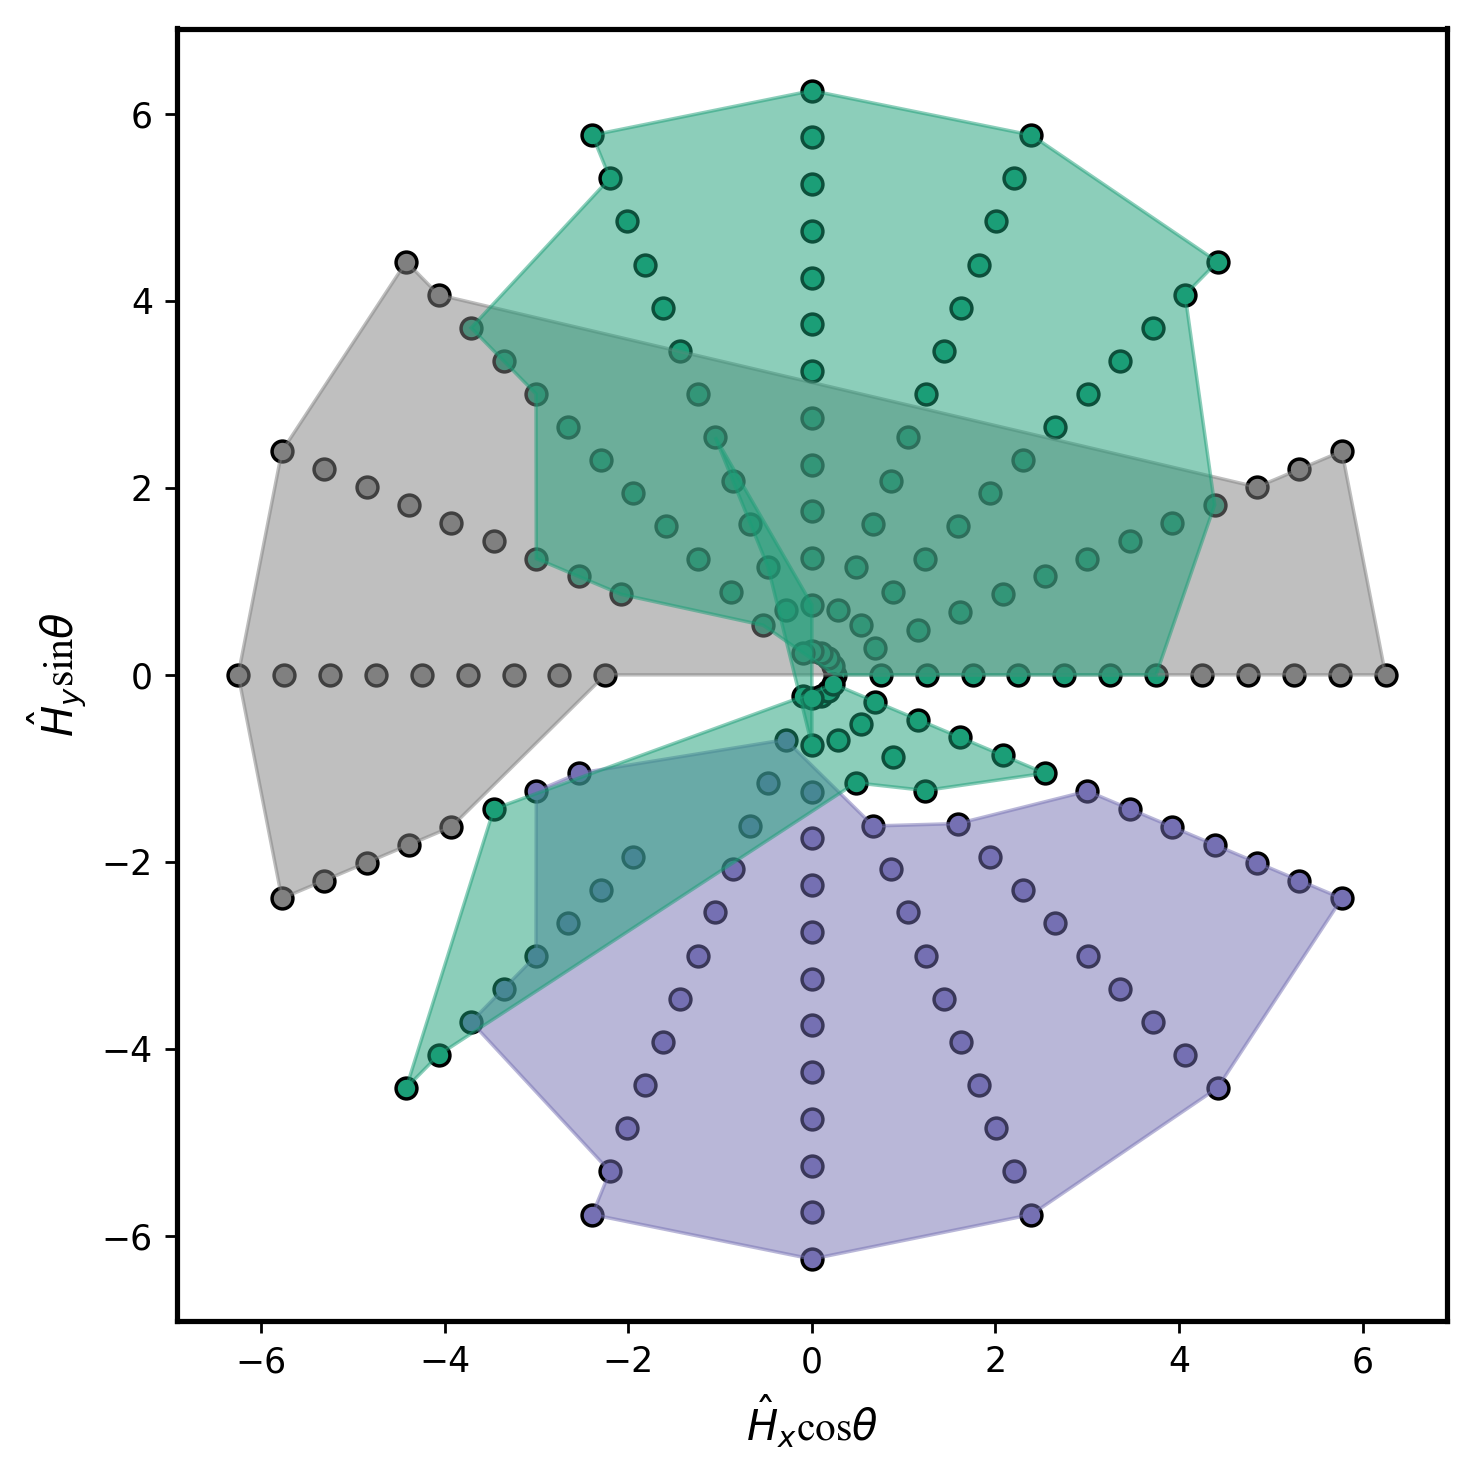

Hy =  4.5
state =  0
<class 'shapely.geometry.polygon.Polygon'>
state =  1
state =  2
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
state =  3
<class 'shapely.geometry.point.Point'>
state =  4


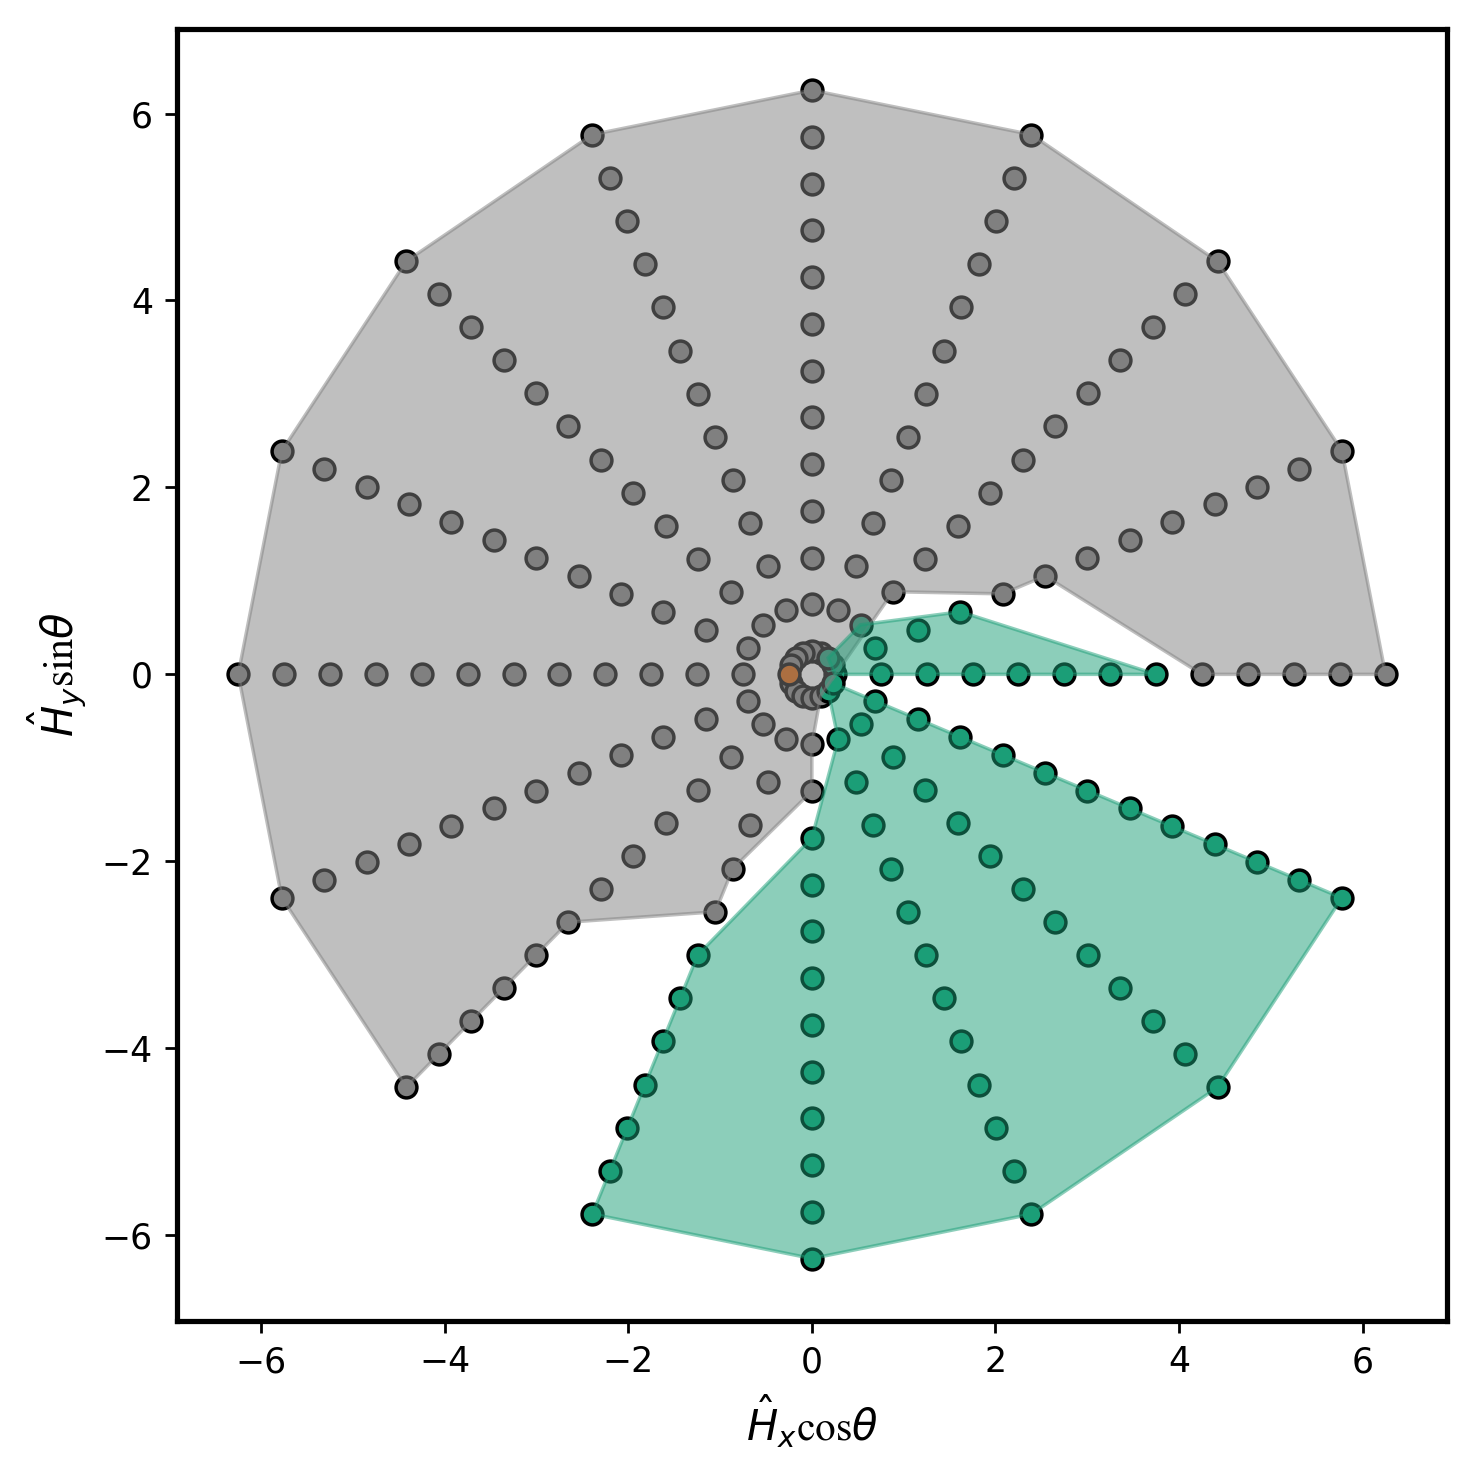

In [269]:
import alphashape
#Re = 2

#Diverge = 0
#V-Shape = 1
#In-line = 2
#Headbutt = 3
#L-shape = 4
#NOTA = 5

endSimData = endData[0]

HyList = [-4.5,4.5] #list(np.linspace(-4.5,4.5,10))
stateList = [0,1,2,3,4]
for Hy in HyList:
    print('Hy = ',Hy)
    #Hy Clip
    HyData = endSimData[endSimData['parHy'] <= Hy + 0.01].copy()
    HyData = HyData[HyData['parHy'] >= Hy - 0.01].copy()

    HyData = HyData.reset_index(drop=True)
        
    fig, ax = plt.subplots(nrows=1,ncols=1,num=2,figsize=(6,6),dpi=250)
    ax.set_xlabel(r'$\hat{H}_x$cos$\theta$',fontsize=12,**csfont)
    ax.set_ylabel(r'$\hat{H}_y$sin$\theta$',fontsize=12,**csfont)
    for state in stateList:
        print('state = ',state)
        data = HyData[HyData['State'] == state].copy()
        if len(data['parHx']) > 0:
            #print(data['parHx'])
            #print(data['parThetaBW'])
            data = data.sort_values(by=['parThetaBW','parHx'])
            data = data.reset_index(drop=True)
            if data.loc[0,'State'] == 2:
                data1 = data[data['parThetaBW'] <= 180.0].copy()
                data1 = data1.reset_index(drop=True)
                data2 = data[data['parThetaBW'] > 180.0].copy()
                data2 = data2.reset_index(drop=True)
                #We are in-line> Need to split into two regions. theta < 180, theta > 180
                #Region 1 theta < 180
                points1=np.column_stack((data1['xval'].values.tolist(),data1['yval'].values.tolist()))
                alpha = 0.95 * alphashape.optimizealpha(points1)
                if alpha <= 0.1:
                    alpha = 0.6
                #alpha = 1.0
                hull = alphashape.alphashape(points1, alpha)
                boolHull = CheckGeometryCollection(hull)
                if boolHull:
                    hull_pts = hull.exterior.coords.xy
                PlotPolarPlane(boolHull,hull_pts,data1,(data.loc[0,'color_r']/255.0,data.loc[0,'color_g']/255.0,data.loc[0,'color_b']/255.0))
                #Region 2: theta > 180
                points2=np.column_stack((data2['xval'].values.tolist(),data2['yval'].values.tolist()))
                alpha = 0.95 * alphashape.optimizealpha(points2)
                if alpha <= 0.1:
                    alpha = 0.6
                #alpha = 1.0
                hull = alphashape.alphashape(points2, alpha)
                boolHull = CheckGeometryCollection(hull)
                if boolHull:
                    hull_pts = hull.exterior.coords.xy
                PlotPolarPlane(boolHull,hull_pts,data2,(data.loc[0,'color_r']/255.0,data.loc[0,'color_g']/255.0,data.loc[0,'color_b']/255.0))


            else:    
                points=np.column_stack((data['xval'].values.tolist(),data['yval'].values.tolist()))
                alpha = 0.95 * alphashape.optimizealpha(points)
                if alpha <= 0.1:
                    alpha = 0.6
                #alpha = 1.0
                hull = alphashape.alphashape(points, alpha)
                boolHull = CheckGeometryCollection(hull)
                if boolHull:
                    hull_pts = hull.exterior.coords.xy
                if data.loc[0,'State'] == 0:
                    PlotPolarPlane(boolHull,hull_pts,data,(0.5,0.5,0.5))
                else:
                    PlotPolarPlane(boolHull,hull_pts,data,(data.loc[0,'color_r']/255.0,data.loc[0,'color_g']/255.0,data.loc[0,'color_b']/255.0))
    fig.tight_layout()
    plt.show()
    strDir = cwd_PYTHON+"/../Figures/PhaseSpace/Re{0}/polar/".format(2)
    pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
    fig.savefig(strDir+'Re{0}_polar_Hy{1}_.png'.format(2,Hy))
    fig.clf()
    plt.close()



Hy =  -4.5
state =  0
152    6.25
Name: parHx, dtype: float64
152    22.5
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.point.Point'>
state =  1
0      6.25
1      5.75
2      5.25
3      4.75
4      4.25
5      3.75
6      3.25
7      2.75
17     6.25
18     6.25
19     6.25
20     5.75
21     5.75
22     5.75
23     5.25
24     5.25
25     5.25
26     4.75
27     6.25
28     4.75
29     4.75
30     4.25
31     5.75
32     4.25
33     4.25
34     3.75
35     5.25
36     3.75
37     3.75
38     4.75
       ... 
43     2.75
44     3.75
45     2.75
46     2.75
47     6.25
49     3.25
50     2.25
51     5.75
53     2.25
54     2.25
55     5.25
57     2.75
58     4.75
60     1.75
61     4.25
63     1.75
64     1.75
65     2.25
66     3.75
68     1.25
69     3.25
72     1.25
74     2.75
75     2.75
79     0.75
97     4.25
98     4.75
99     5.25
100    5.75
101    6.25
Name: parHx, Length: 64, dtype: float64
0      225.0
1      225.0
2      225.0
3      225.0
4      225.0
5     

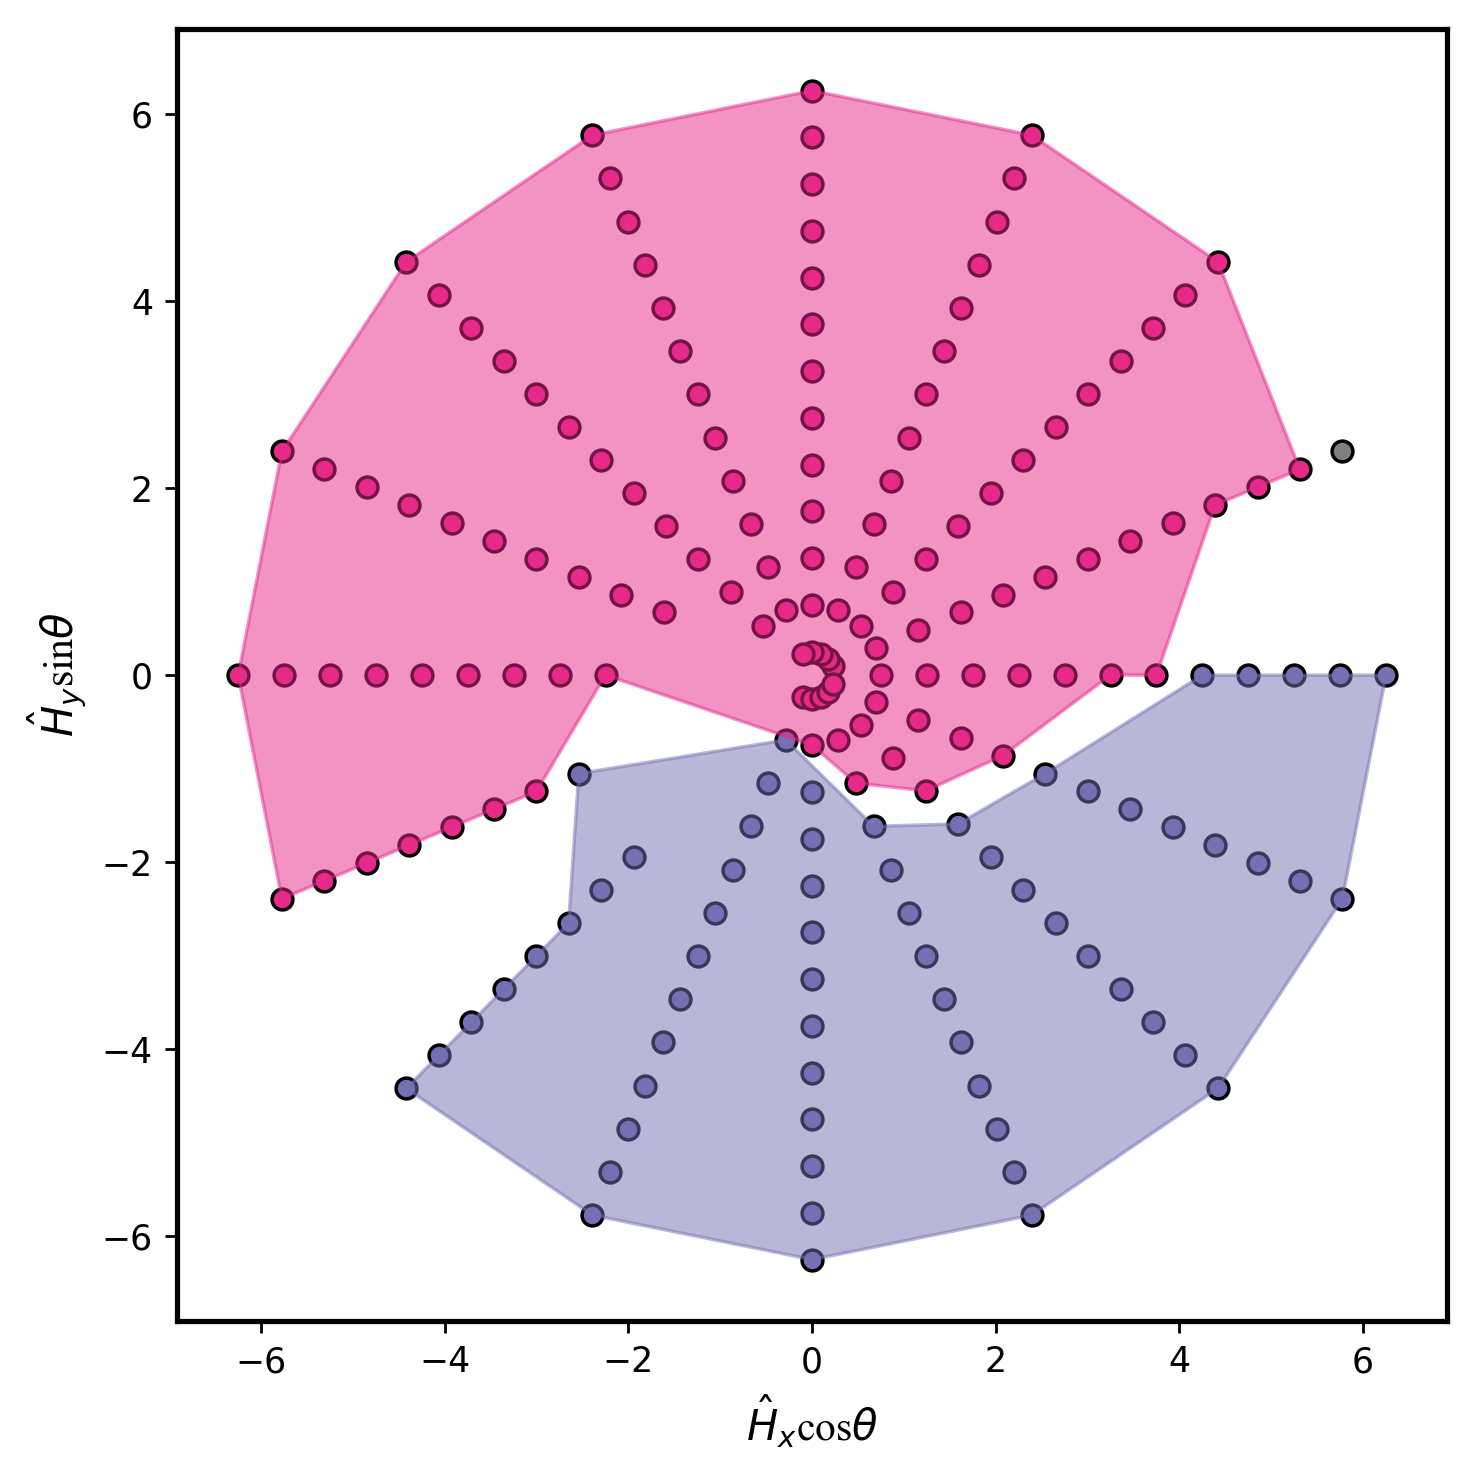

Hy =  -3.5
state =  0
state =  1
0      6.25
1      6.25
2      6.25
3      5.75
4      5.75
5      5.75
6      5.25
7      5.25
8      5.25
9      4.75
11     4.75
12     4.75
13     4.25
15     4.25
16     4.25
17     3.75
19     3.75
20     3.75
23     3.25
24     3.75
25     2.75
26     6.25
27     5.75
28     2.25
29     5.25
30     4.75
31     4.25
32     1.75
33     3.75
34     3.25
35     1.25
36     2.75
37     2.25
40     2.75
41     3.25
42     3.75
43     4.25
44     4.75
45     5.25
46     5.75
47     6.25
55     4.25
56     4.75
58     5.25
60     5.75
62     6.25
85     6.25
86     5.75
87     5.25
88     4.75
89     4.25
90     3.75
92     3.25
95     2.75
98     2.25
101    1.75
Name: parHx, dtype: float64
0      270.0
1      247.5
2      292.5
3      270.0
4      247.5
5      292.5
6      270.0
7      247.5
8      292.5
9      270.0
11     247.5
12     292.5
13     270.0
15     247.5
16     292.5
17     270.0
19     247.5
20     292.5
23     292.5
24     225.0
25     

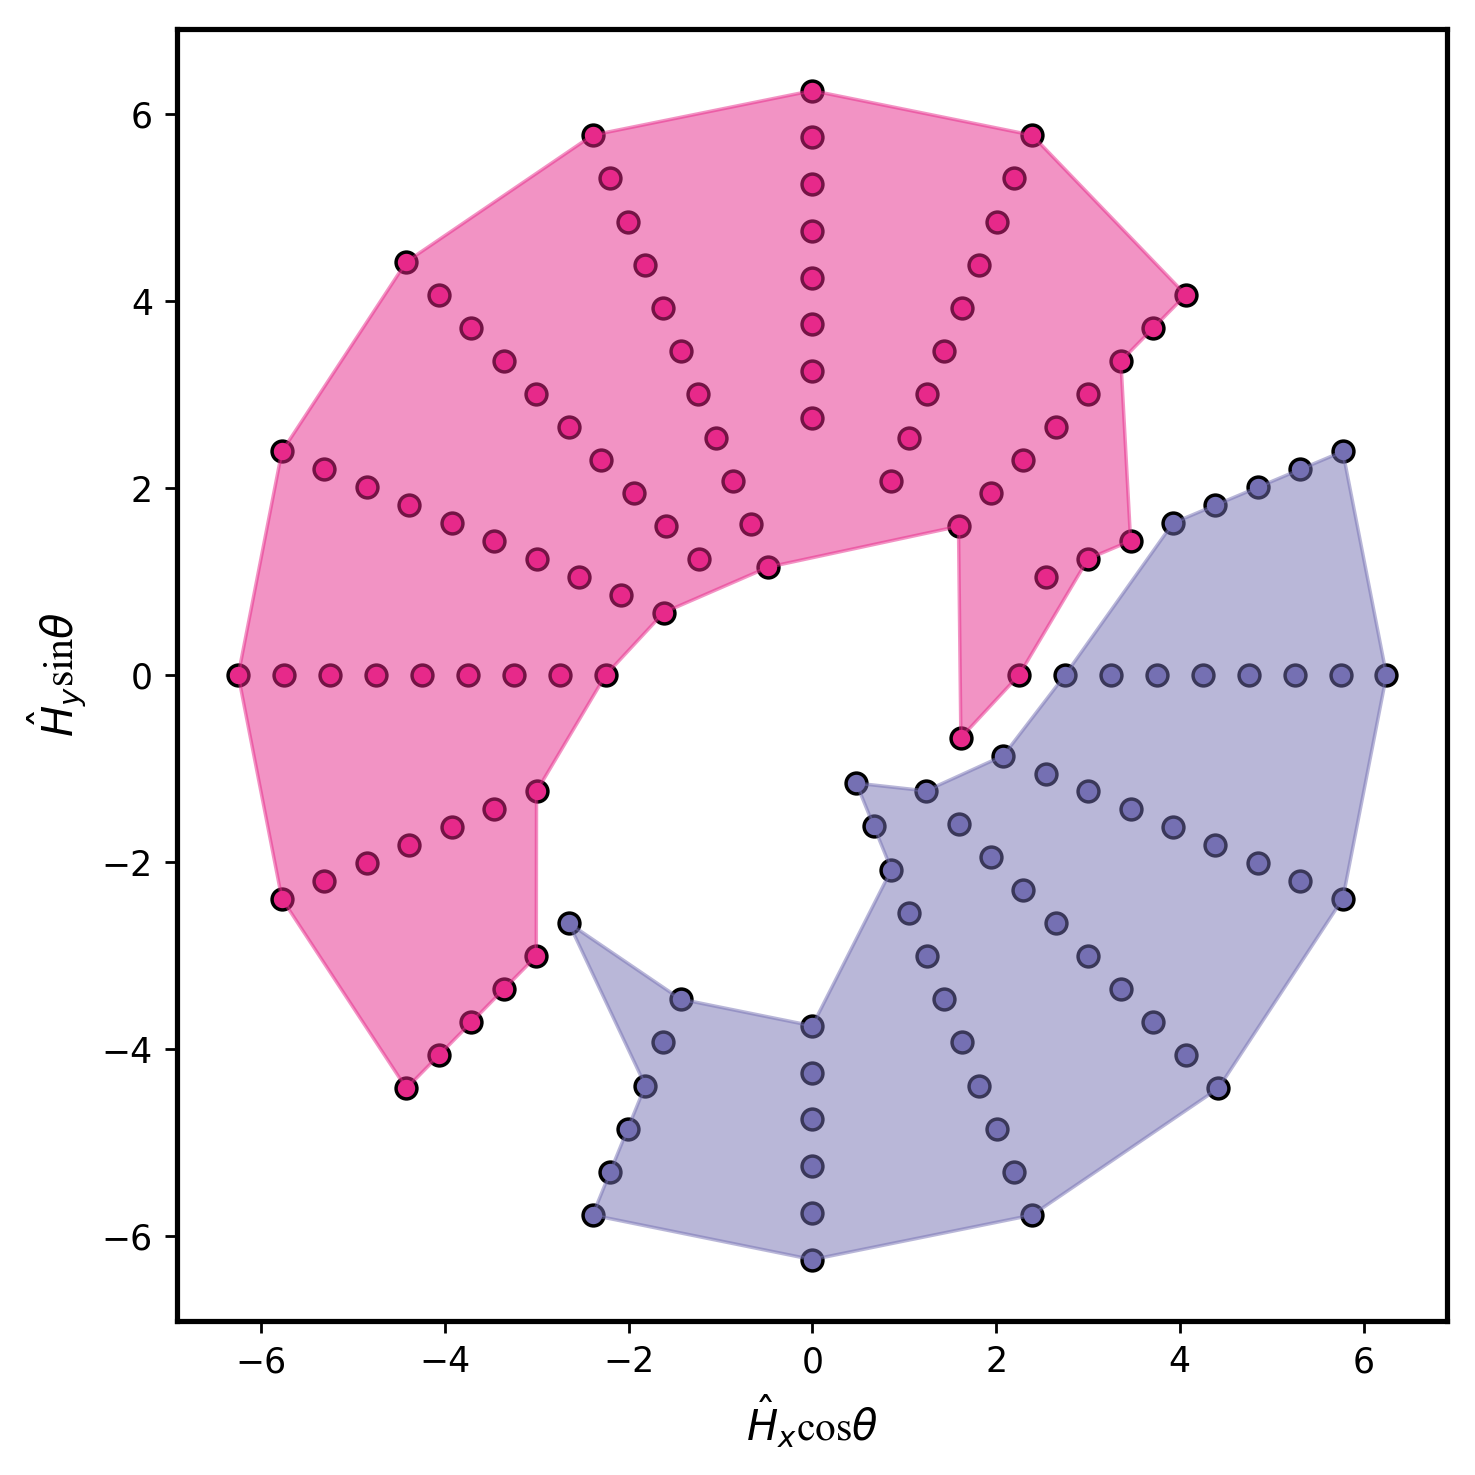

Hy =  -2.5
state =  0
115    6.25
Name: parHx, dtype: float64
115    67.5
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.point.Point'>
state =  1
1     6.25
2     5.75
3     5.75
4     5.25
5     5.25
6     4.75
7     4.75
8     4.25
9     4.25
10    3.75
11    3.75
12    6.25
13    5.75
14    5.25
15    4.75
16    4.25
17    3.75
18    3.25
19    2.75
20    2.25
21    2.25
22    2.75
23    3.25
24    3.75
25    4.25
26    4.75
27    5.25
28    5.75
29    6.25
32    2.75
34    3.25
36    3.75
38    4.25
40    4.75
42    5.25
44    5.75
46    6.25
48    4.25
49    4.75
56    6.25
57    5.75
58    5.25
59    4.75
60    6.25
62    4.25
63    5.75
65    3.75
66    5.25
68    4.75
70    4.25
72    3.75
75    3.25
78    2.75
95    3.75
Name: parHx, dtype: float64
1     292.5
2     247.5
3     292.5
4     247.5
5     292.5
6     247.5
7     292.5
8     247.5
9     292.5
10    247.5
11    292.5
12    337.5
13    337.5
14    337.5
15    337.5
16    337.5
17    337.5
18    337.5
19   

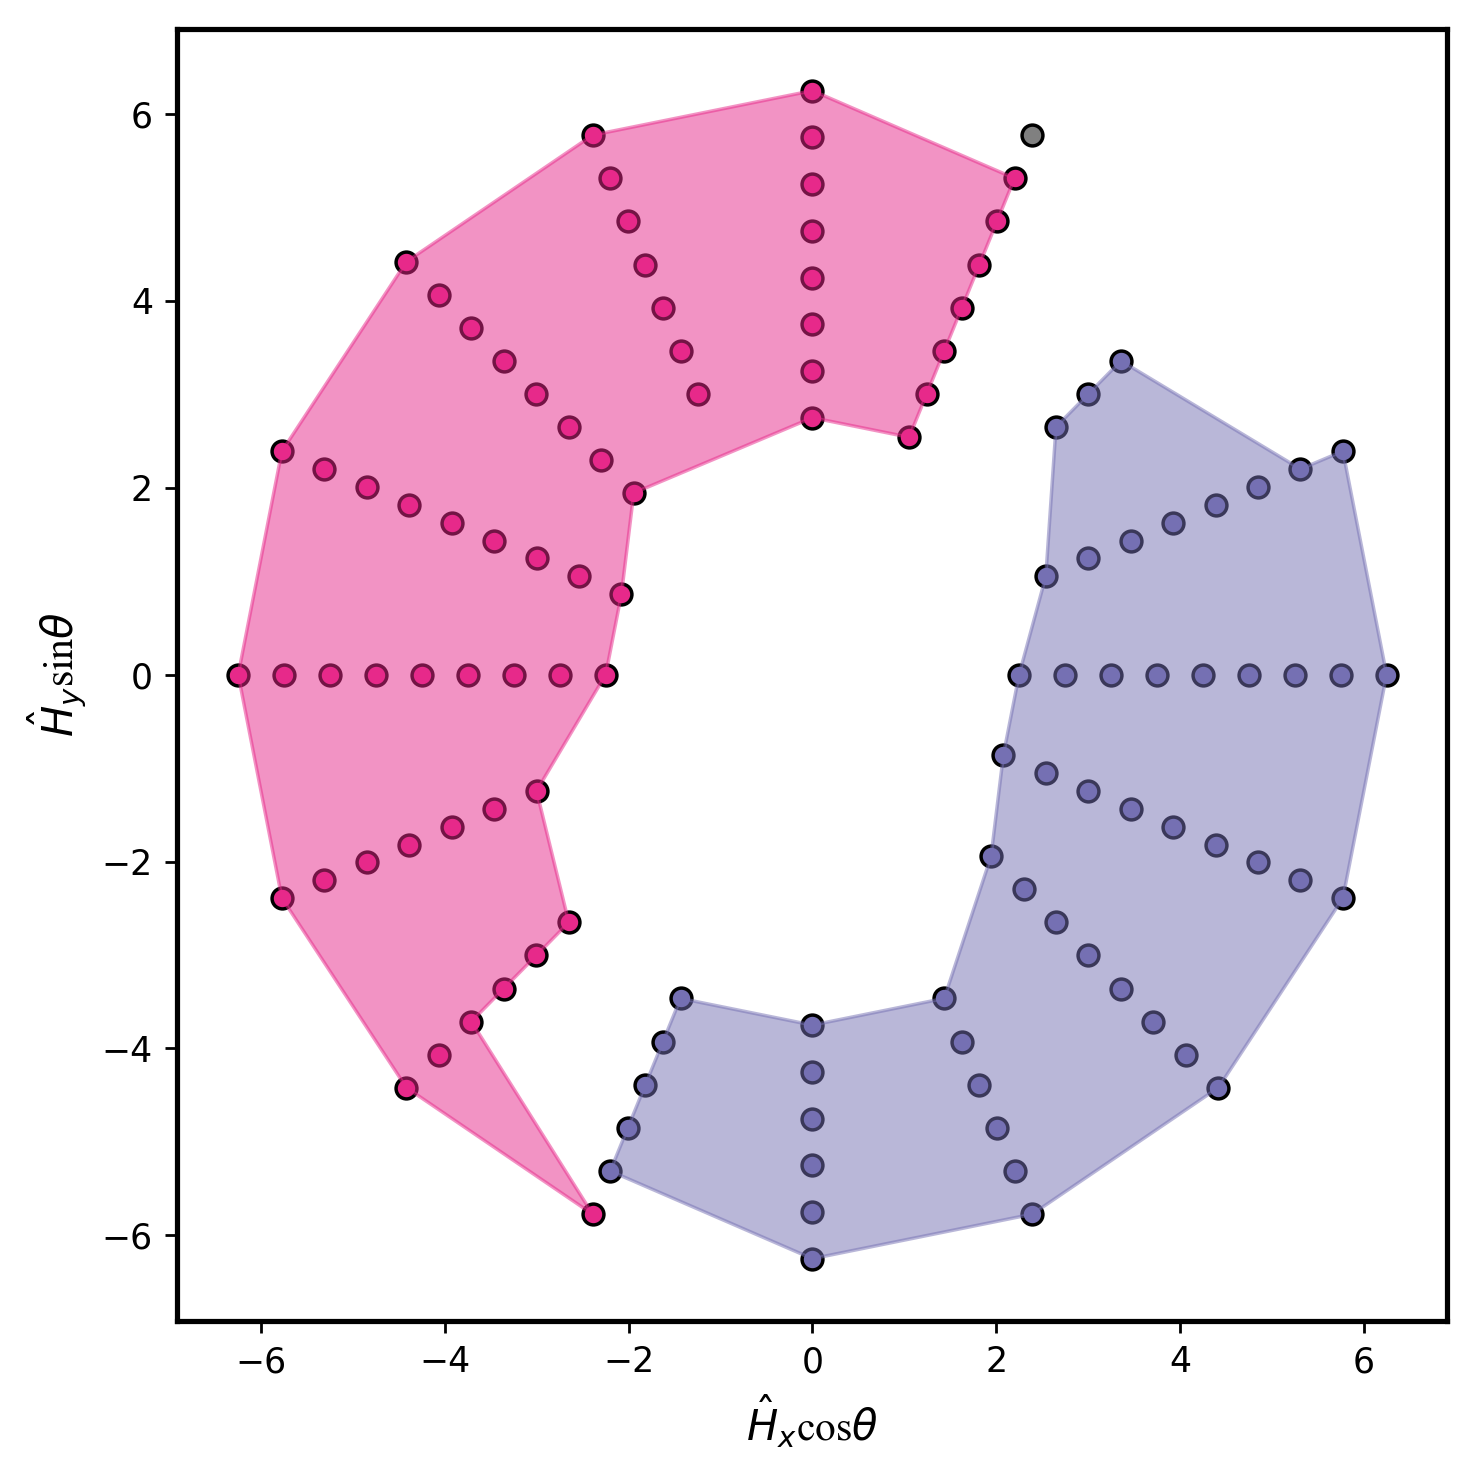

Hy =  -1.5
state =  0
33    6.25
Name: parHx, dtype: float64
33    90.0
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.point.Point'>
state =  1
0      6.25
1      5.75
2      5.25
3      4.75
4      4.25
5      3.75
6      6.25
7      5.75
8      5.25
9      4.75
10     4.25
11     3.75
12     3.25
13     2.75
14     2.75
15     3.25
16     3.75
17     4.25
18     4.75
19     5.25
20     5.75
21     6.25
23     3.25
34     6.25
36     5.75
38     5.25
40     4.75
41     6.25
44     4.25
45     5.75
48     3.75
49     5.25
52     4.75
54     4.25
56     3.75
65     2.25
66     2.75
67     3.25
68     3.75
69     4.25
70     4.75
71     5.25
72     5.75
73     6.25
91     3.25
94     3.75
97     4.25
98     4.75
107    6.25
112    5.75
Name: parHx, dtype: float64
0      292.5
1      292.5
2      292.5
3      292.5
4      292.5
5      292.5
6      337.5
7      337.5
8      337.5
9      337.5
10     337.5
11     337.5
12     337.5
13     337.5
14      22.5
15      22.5
16      2

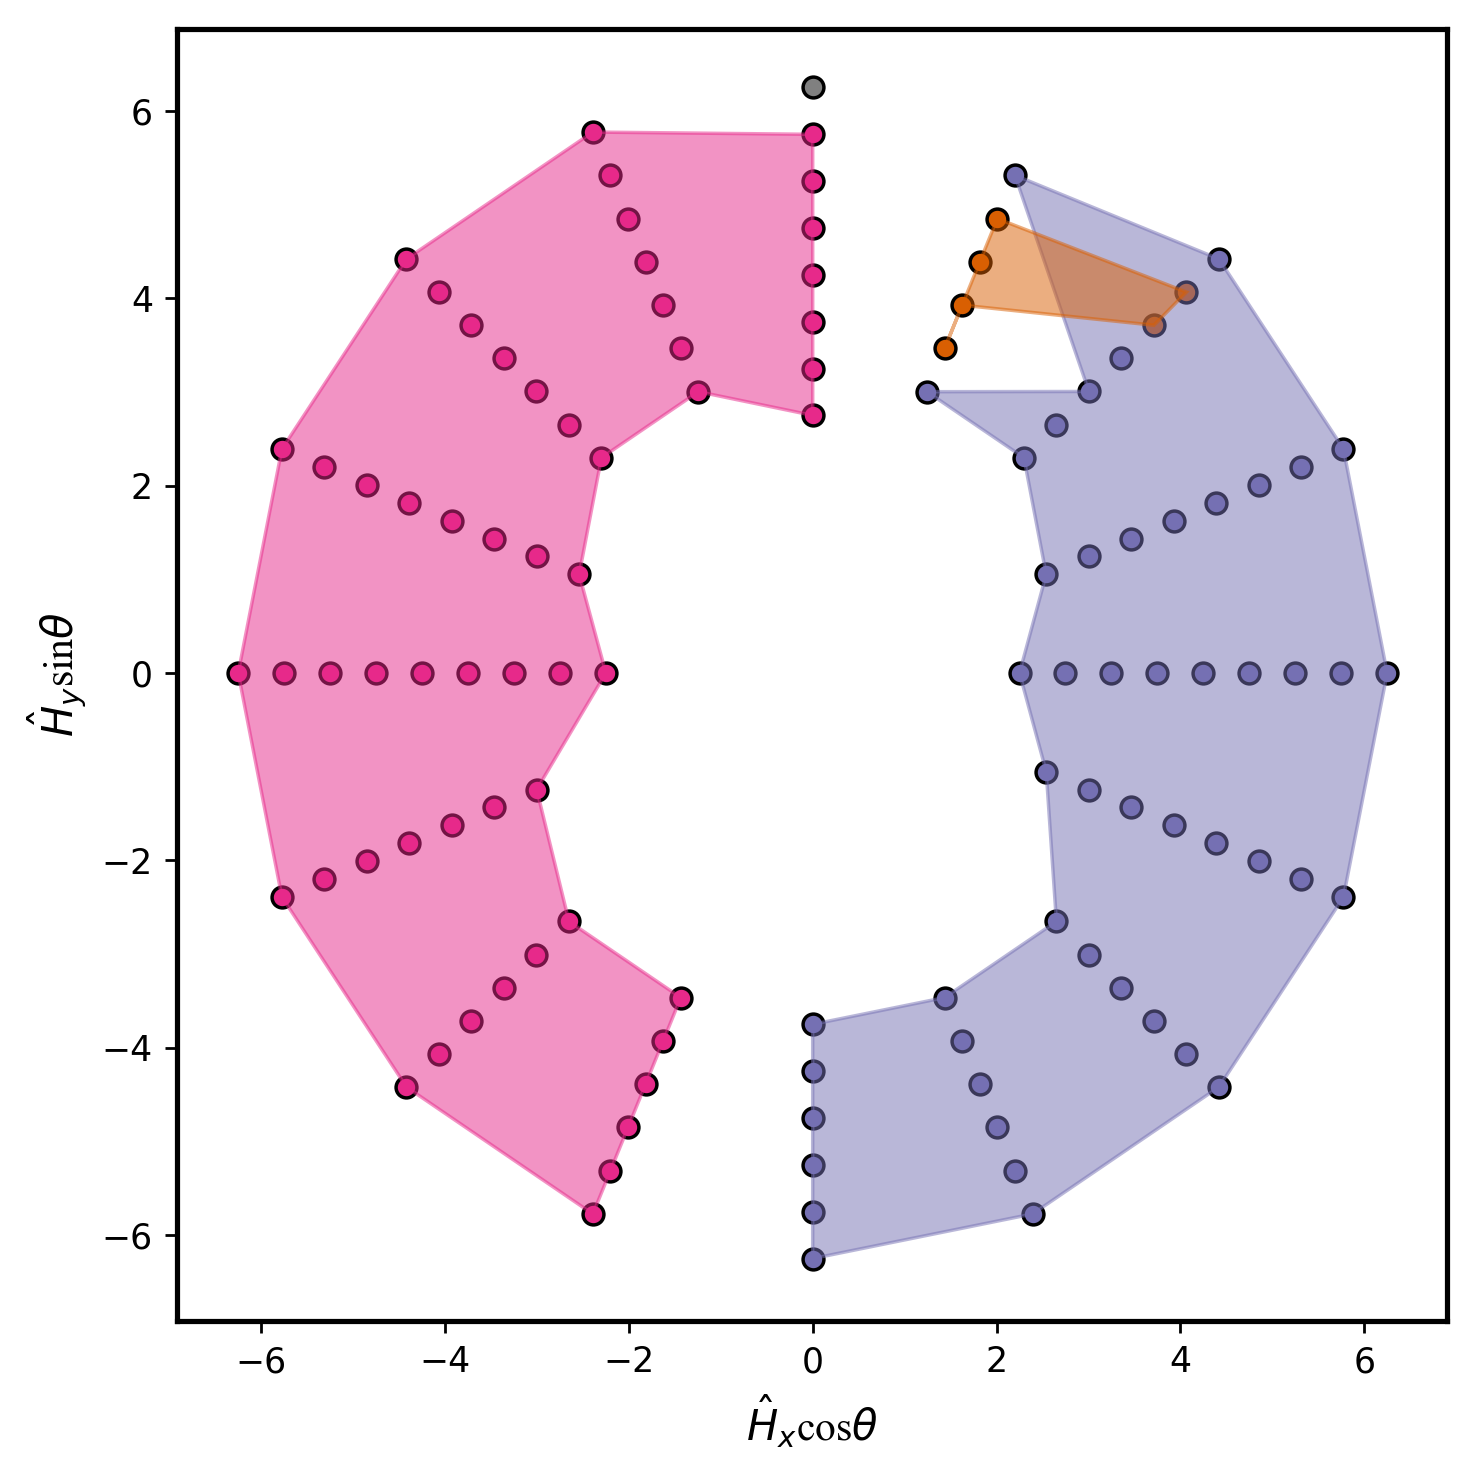

Hy =  -0.5
state =  0
state =  1
9      6.25
12     5.75
15     5.25
17     6.25
20     4.75
22     5.75
25     4.25
27     5.25
30     3.75
31     4.75
33     4.25
35     3.75
37     6.25
39     5.75
41     5.25
43     4.75
45     4.25
47     3.75
49     3.25
51     2.25
52     2.75
53     3.25
54     3.75
55     4.25
56     4.75
57     5.25
58     5.75
59     6.25
70     2.75
72     3.25
74     3.75
76     4.25
78     4.75
80     5.25
82     5.75
83     3.25
85     6.25
86     3.75
88     3.25
90     4.25
92     4.75
93     3.75
95     5.25
97     4.25
101    4.75
111    6.25
Name: parHx, dtype: float64
9      292.5
12     292.5
15     292.5
17     315.0
20     292.5
22     315.0
25     292.5
27     315.0
30     292.5
31     315.0
33     315.0
35     315.0
37     337.5
39     337.5
41     337.5
43     337.5
45     337.5
47     337.5
49     337.5
51       0.0
52       0.0
53       0.0
54       0.0
55       0.0
56       0.0
57       0.0
58       0.0
59       0.0
70      22.5
72      22

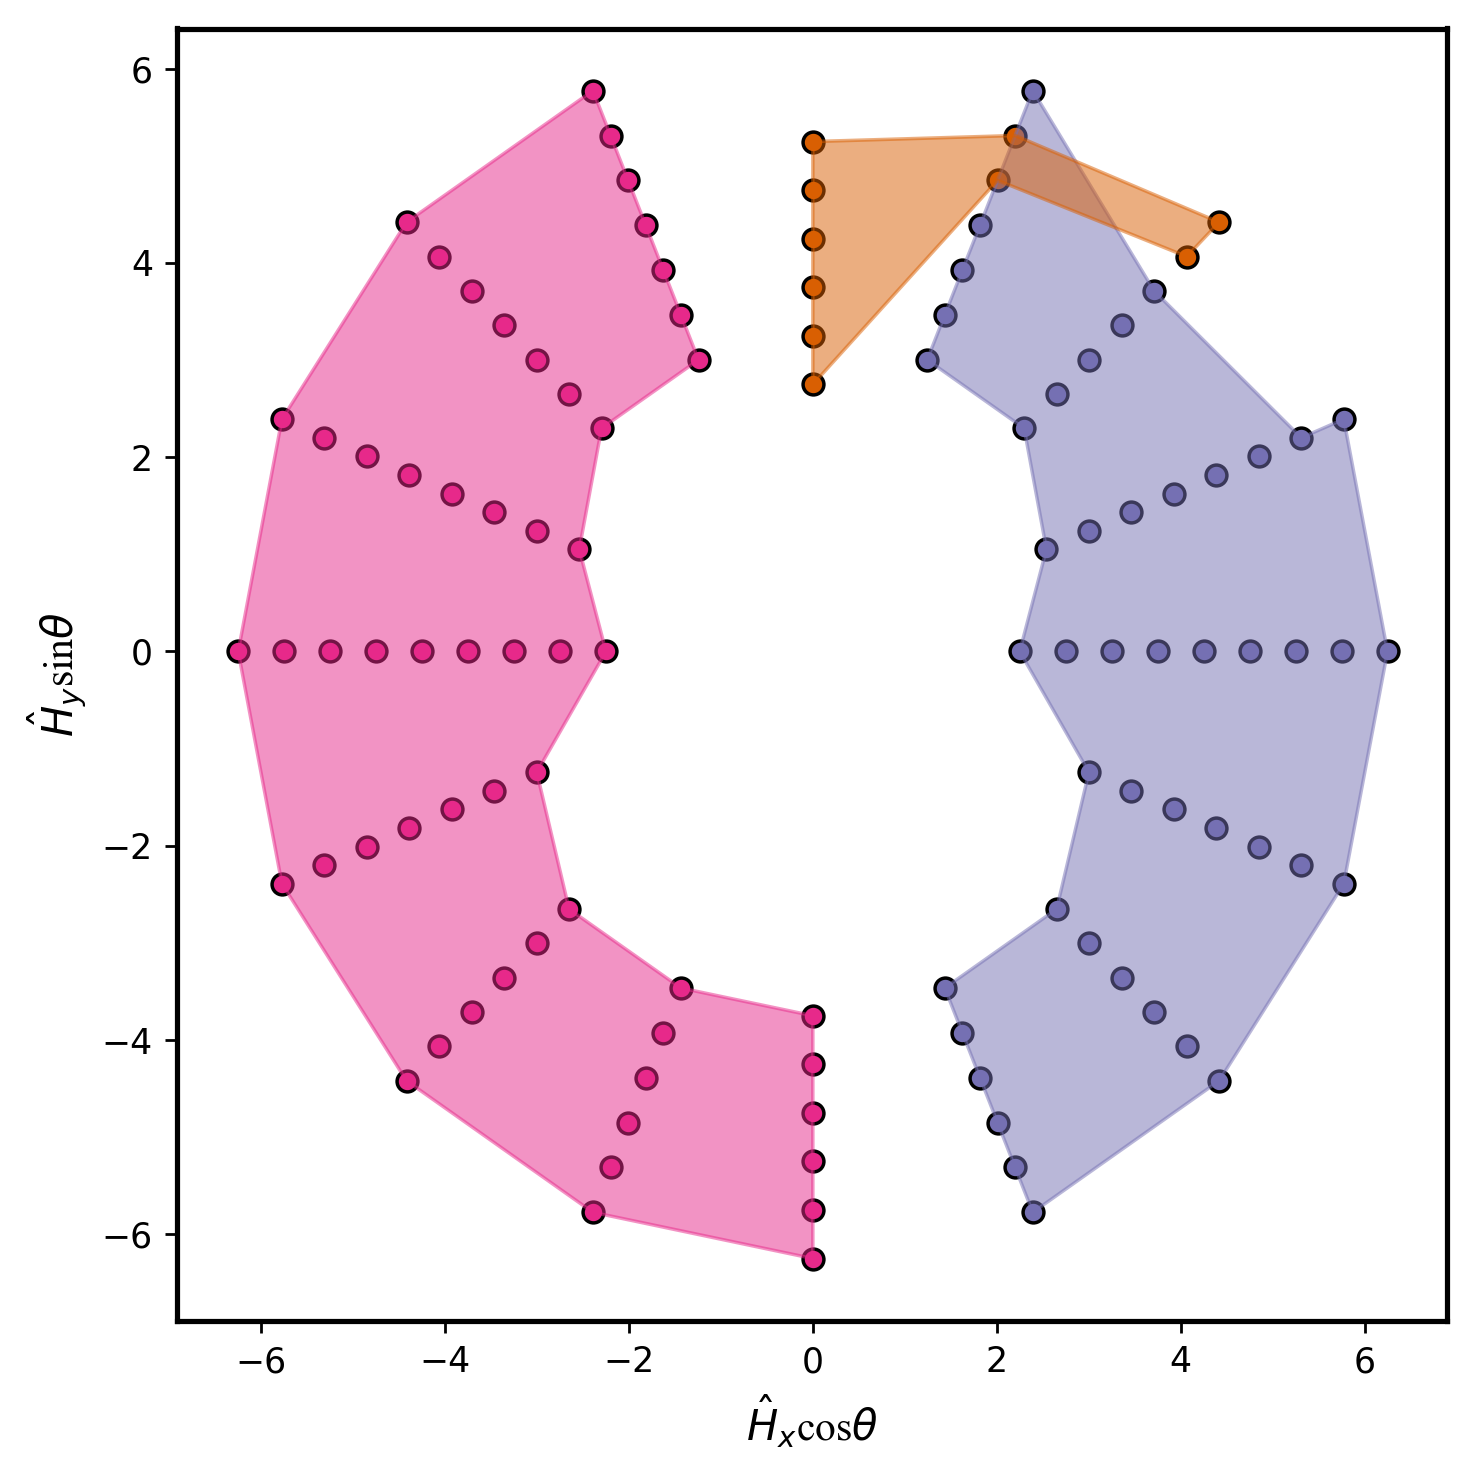

Hy =  0.5
state =  0
95    5.75
98    6.25
Name: parHx, dtype: float64
95    112.5
98    112.5
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.linestring.LineString'>
state =  1
2      6.25
5      5.75
8      5.25
24     6.25
26     5.75
28     5.25
30     4.75
32     4.25
34     3.75
36     3.25
39     2.25
40     2.75
41     3.25
42     3.75
43     4.25
44     4.75
45     5.25
46     5.75
47     6.25
58     2.75
60     3.25
62     3.75
64     4.25
66     4.75
68     5.25
70     5.75
73     6.25
76     3.25
81     3.75
85     4.25
90     4.75
93     5.25
99     6.25
100    5.75
101    5.25
102    4.75
103    4.25
104    3.75
105    3.25
106    3.75
107    4.25
108    4.75
109    5.25
110    5.75
111    6.25
Name: parHx, dtype: float64
2      292.5
5      292.5
8      292.5
24     337.5
26     337.5
28     337.5
30     337.5
32     337.5
34     337.5
36     337.5
39       0.0
40       0.0
41       0.0
42       0.0
43       0.0
44       0.0
45       0.0
46       0.0
47       0

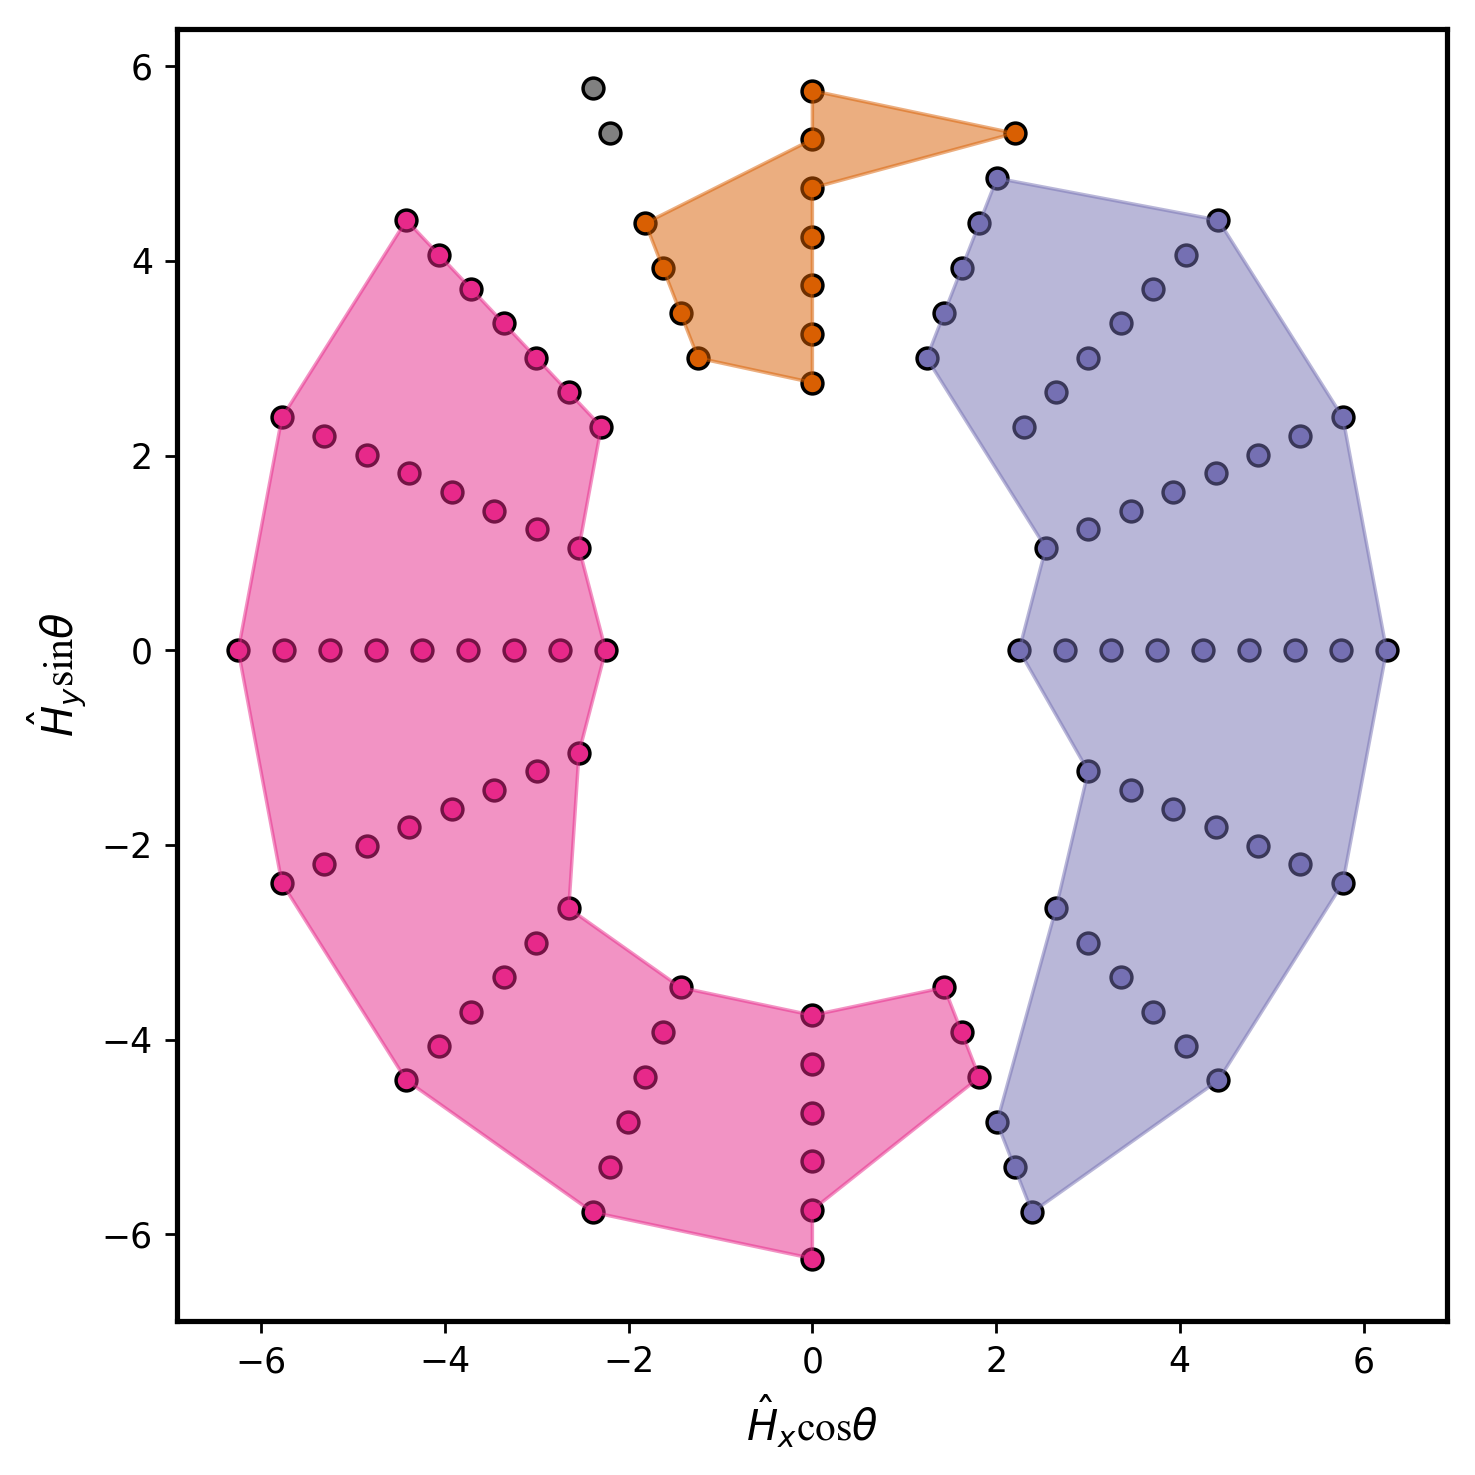

Hy =  1.5
state =  0
82    5.75
87    6.25
Name: parHx, dtype: float64
82    135.0
87    135.0
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.linestring.LineString'>
state =  1
6     6.25
9     5.75
12    5.25
15    4.75
16    4.25
17    3.75
18    6.25
20    5.75
22    5.25
24    4.75
26    4.25
28    3.75
30    3.25
34    2.25
35    2.75
36    3.25
37    3.75
38    4.25
39    4.75
40    5.25
41    5.75
42    6.25
52    2.25
53    2.75
54    3.25
55    3.75
56    4.25
57    4.75
58    2.75
59    5.25
60    5.75
62    3.25
63    6.25
66    3.75
68    3.25
71    4.25
73    4.75
75    3.75
78    5.25
80    4.25
83    5.75
85    4.75
86    6.25
90    5.25
93    5.75
95    6.25
Name: parHx, dtype: float64
6     315.0
9     315.0
12    315.0
15    315.0
16    315.0
17    315.0
18    337.5
20    337.5
22    337.5
24    337.5
26    337.5
28    337.5
30    337.5
34      0.0
35      0.0
36      0.0
37      0.0
38      0.0
39      0.0
40      0.0
41      0.0
42      0.0
52     22.5
53

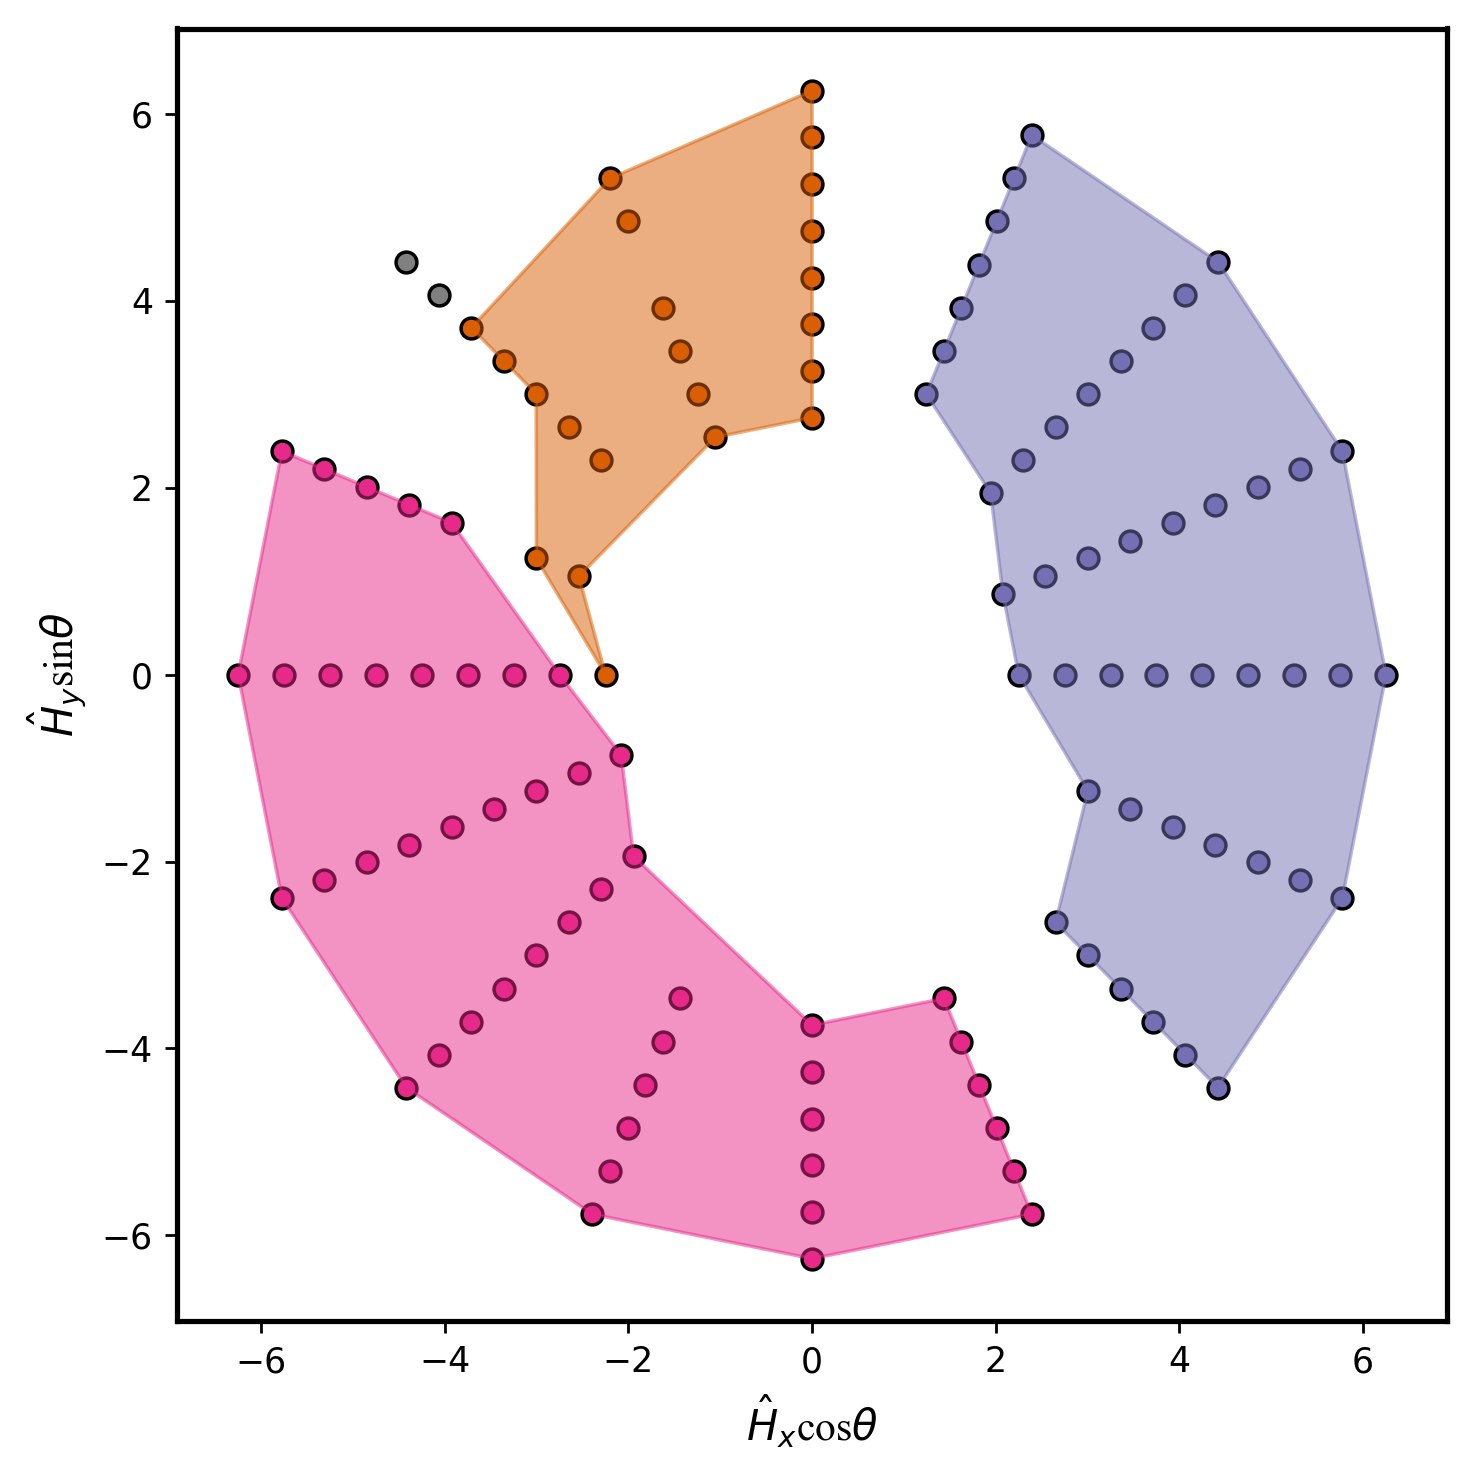

Hy =  2.5
state =  0
54     5.25
78     6.25
84     6.25
108    4.25
127    5.75
129    6.25
Name: parHx, dtype: float64
54     157.5
78     135.0
84     112.5
108    180.0
127    157.5
129    157.5
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.polygon.Polygon'>
state =  1
28     6.25
30     5.75
32     5.25
33     4.75
34     4.25
36     3.75
37     3.25
39     2.25
40     2.75
41     3.25
42     3.75
43     4.25
44     4.75
45     5.25
46     5.75
47     6.25
49     1.75
51     2.25
53     2.75
57     3.25
58     6.25
61     3.75
65     4.25
67     4.75
70     5.25
74     5.75
77     6.25
112    1.75
113    2.25
115    2.75
116    1.25
118    3.25
120    3.75
121    1.75
123    4.25
124    4.75
125    5.25
126    2.25
128    5.75
130    2.75
131    3.25
132    3.75
133    4.25
134    4.75
135    5.25
136    5.75
Name: parHx, dtype: float64
28     337.5
30     337.5
32     337.5
33     337.5
34     337.5
36     337.5
37     337.5
39       0.0
40       0.0
41       0.0
42  

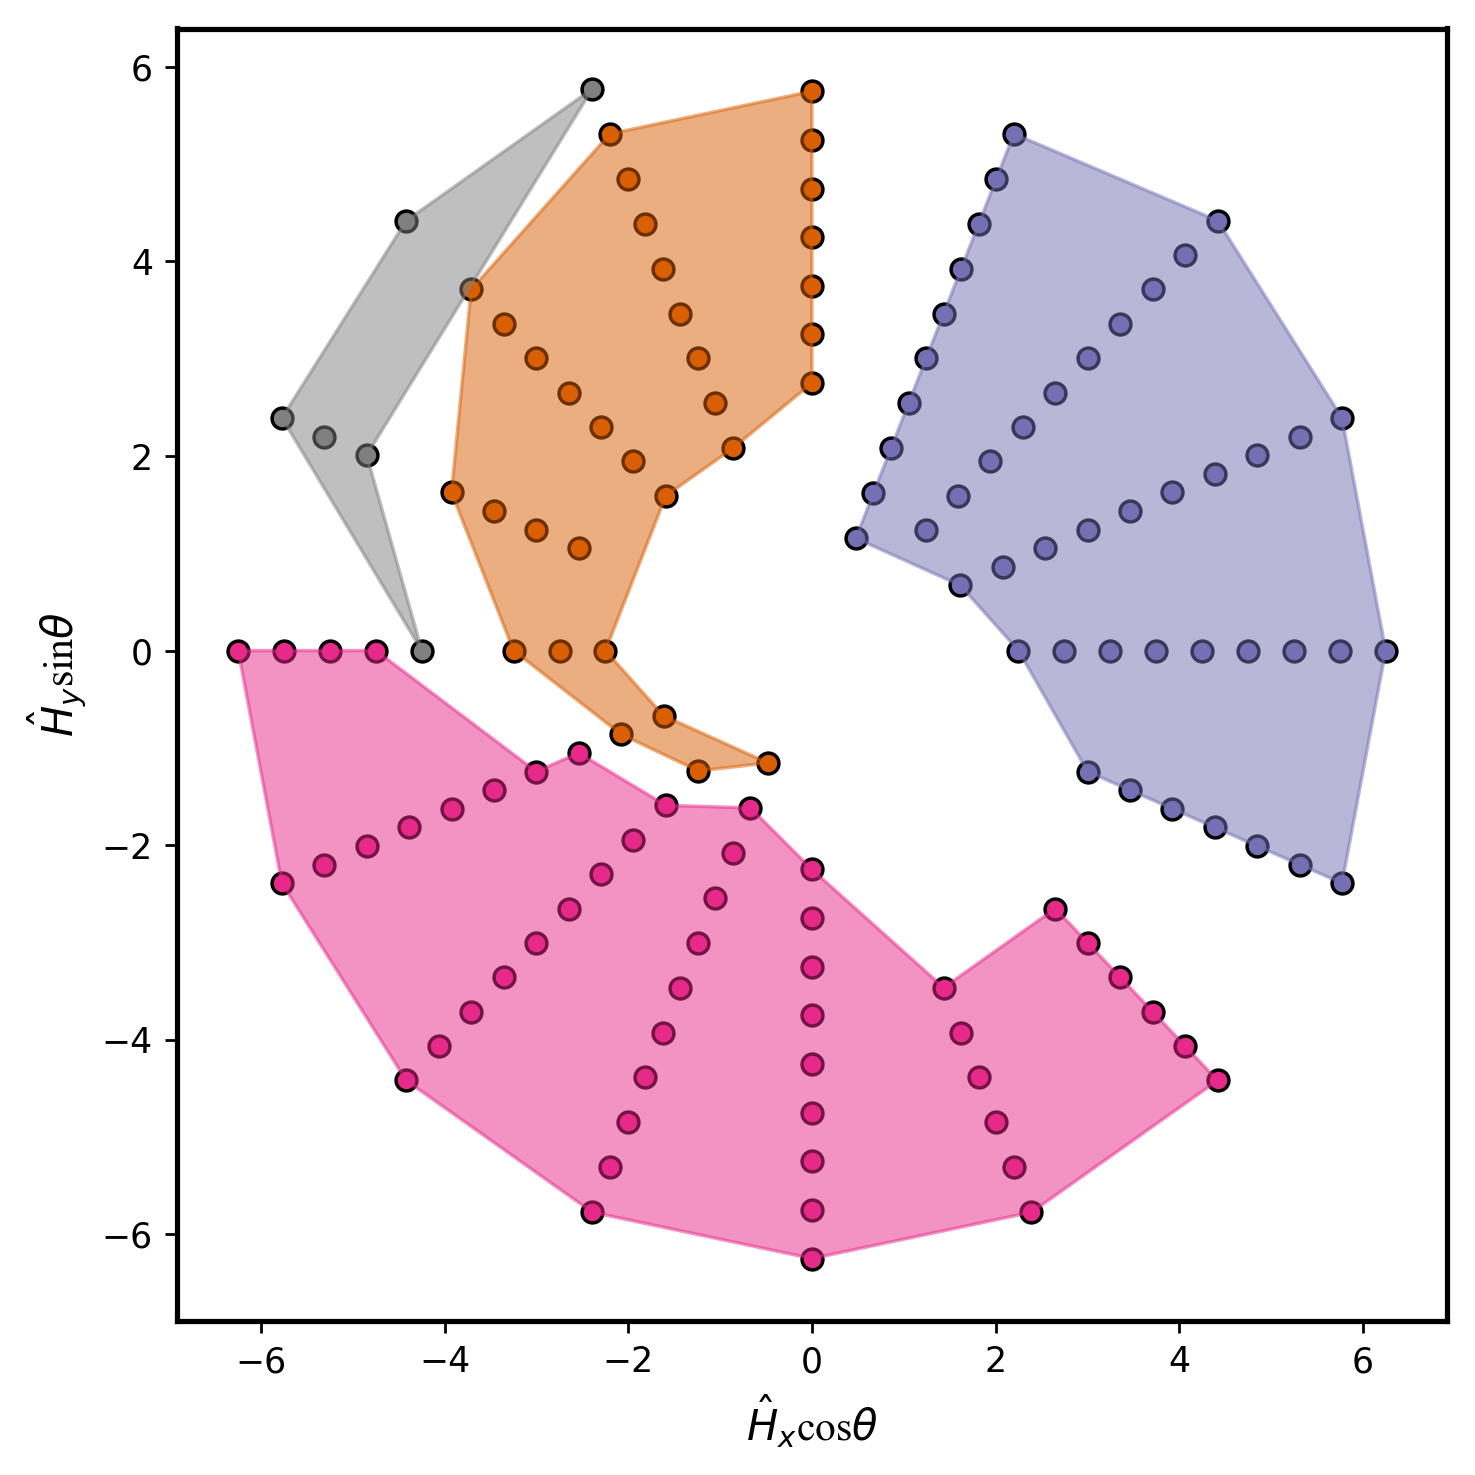

Hy =  3.5
state =  0
68     5.75
87     6.25
91     6.25
145    4.75
146    5.25
147    5.75
148    6.25
169    6.25
Name: parHx, dtype: float64
68     157.5
87     135.0
91      90.0
145    180.0
146    180.0
147    180.0
148    180.0
169    157.5
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.polygon.Polygon'>
state =  1
16     6.25
17     5.75
20     5.25
35     2.75
36     3.25
37     3.75
38     4.25
39     4.75
40     5.25
41     5.75
42     6.25
44     0.25
47     1.75
49     0.75
50     2.25
52     2.75
53     1.25
56     3.25
57     3.75
59     1.75
61     4.25
62     4.75
64     5.25
66     2.25
67     5.75
70     6.25
71     2.75
74     3.25
78     3.75
80     5.25
82     4.25
84     5.75
85     4.75
88     5.25
90     5.75
153    0.75
157    1.25
159    1.75
163    2.25
166    2.75
168    3.25
170    3.75
172    4.25
174    4.75
178    5.25
Name: parHx, dtype: float64
16     337.5
17     337.5
20     337.5
35       0.0
36       0.0
37       0.0
38       0.0
39   

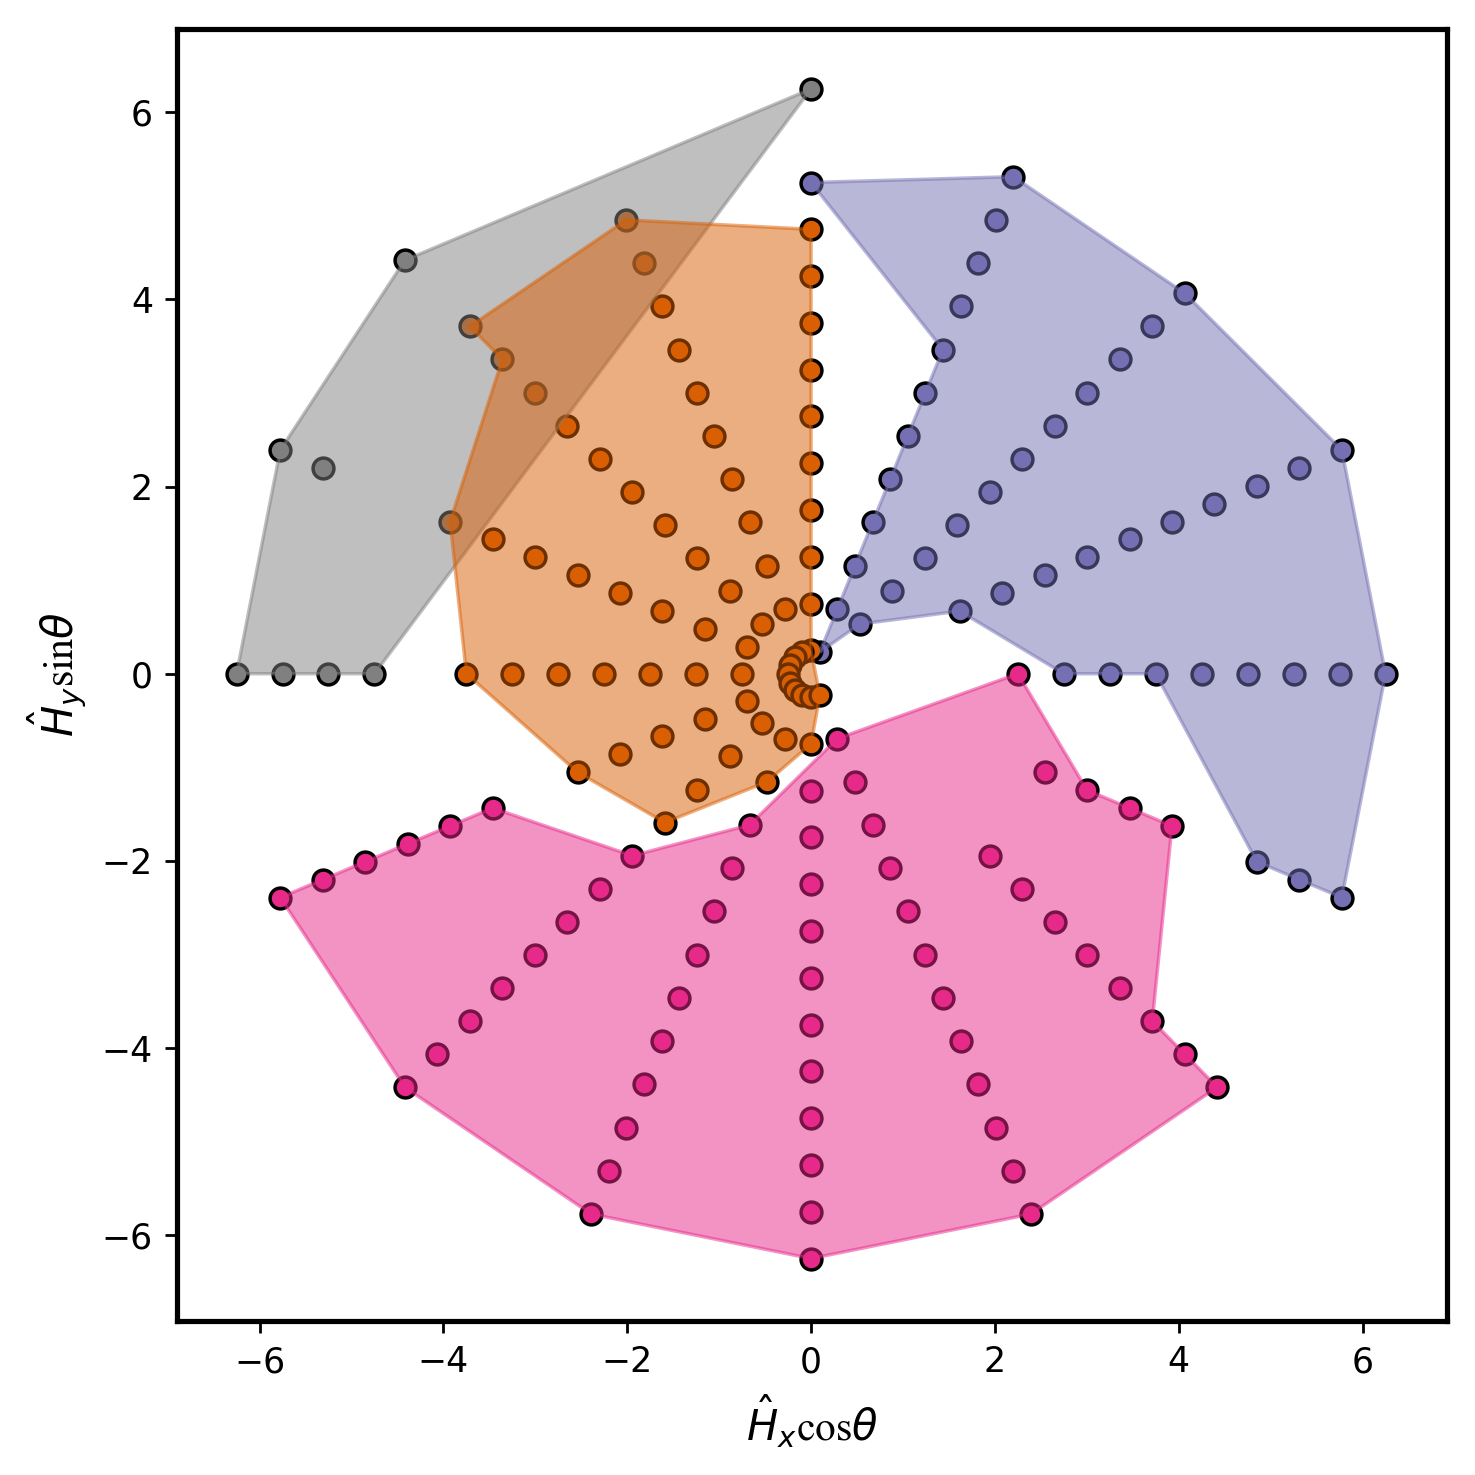

Hy =  4.5
state =  0
39     3.25
42     5.75
46     5.25
49     4.75
52     4.25
57     3.75
93     4.75
94     5.25
95     5.75
96     6.25
135    5.25
138    5.75
142    6.25
155    5.25
159    5.75
160    5.75
164    6.25
165    6.25
167    5.75
168    5.75
169    6.25
170    6.25
171    6.25
Name: parHx, dtype: float64
39     225.0
42     202.5
46     202.5
49     202.5
52     202.5
57     202.5
93     180.0
94     180.0
95     180.0
96     180.0
135    157.5
138    157.5
142    157.5
155    135.0
159    135.0
160     45.0
164     45.0
165    135.0
167    112.5
168     90.0
169    112.5
170     67.5
171     90.0
Name: parThetaBW, dtype: float64
<class 'shapely.geometry.polygon.Polygon'>
state =  1
53     1.75
70     0.75
111    0.75
114    2.25
117    2.75
118    1.25
122    3.25
125    3.75
127    1.75
130    4.25
132    4.75
134    5.25
137    2.25
139    5.75
143    6.25
144    2.75
148    3.25
151    3.25
153    3.75
157    4.25
163    4.75
179    4.25
180    4.75
181    5.25
1

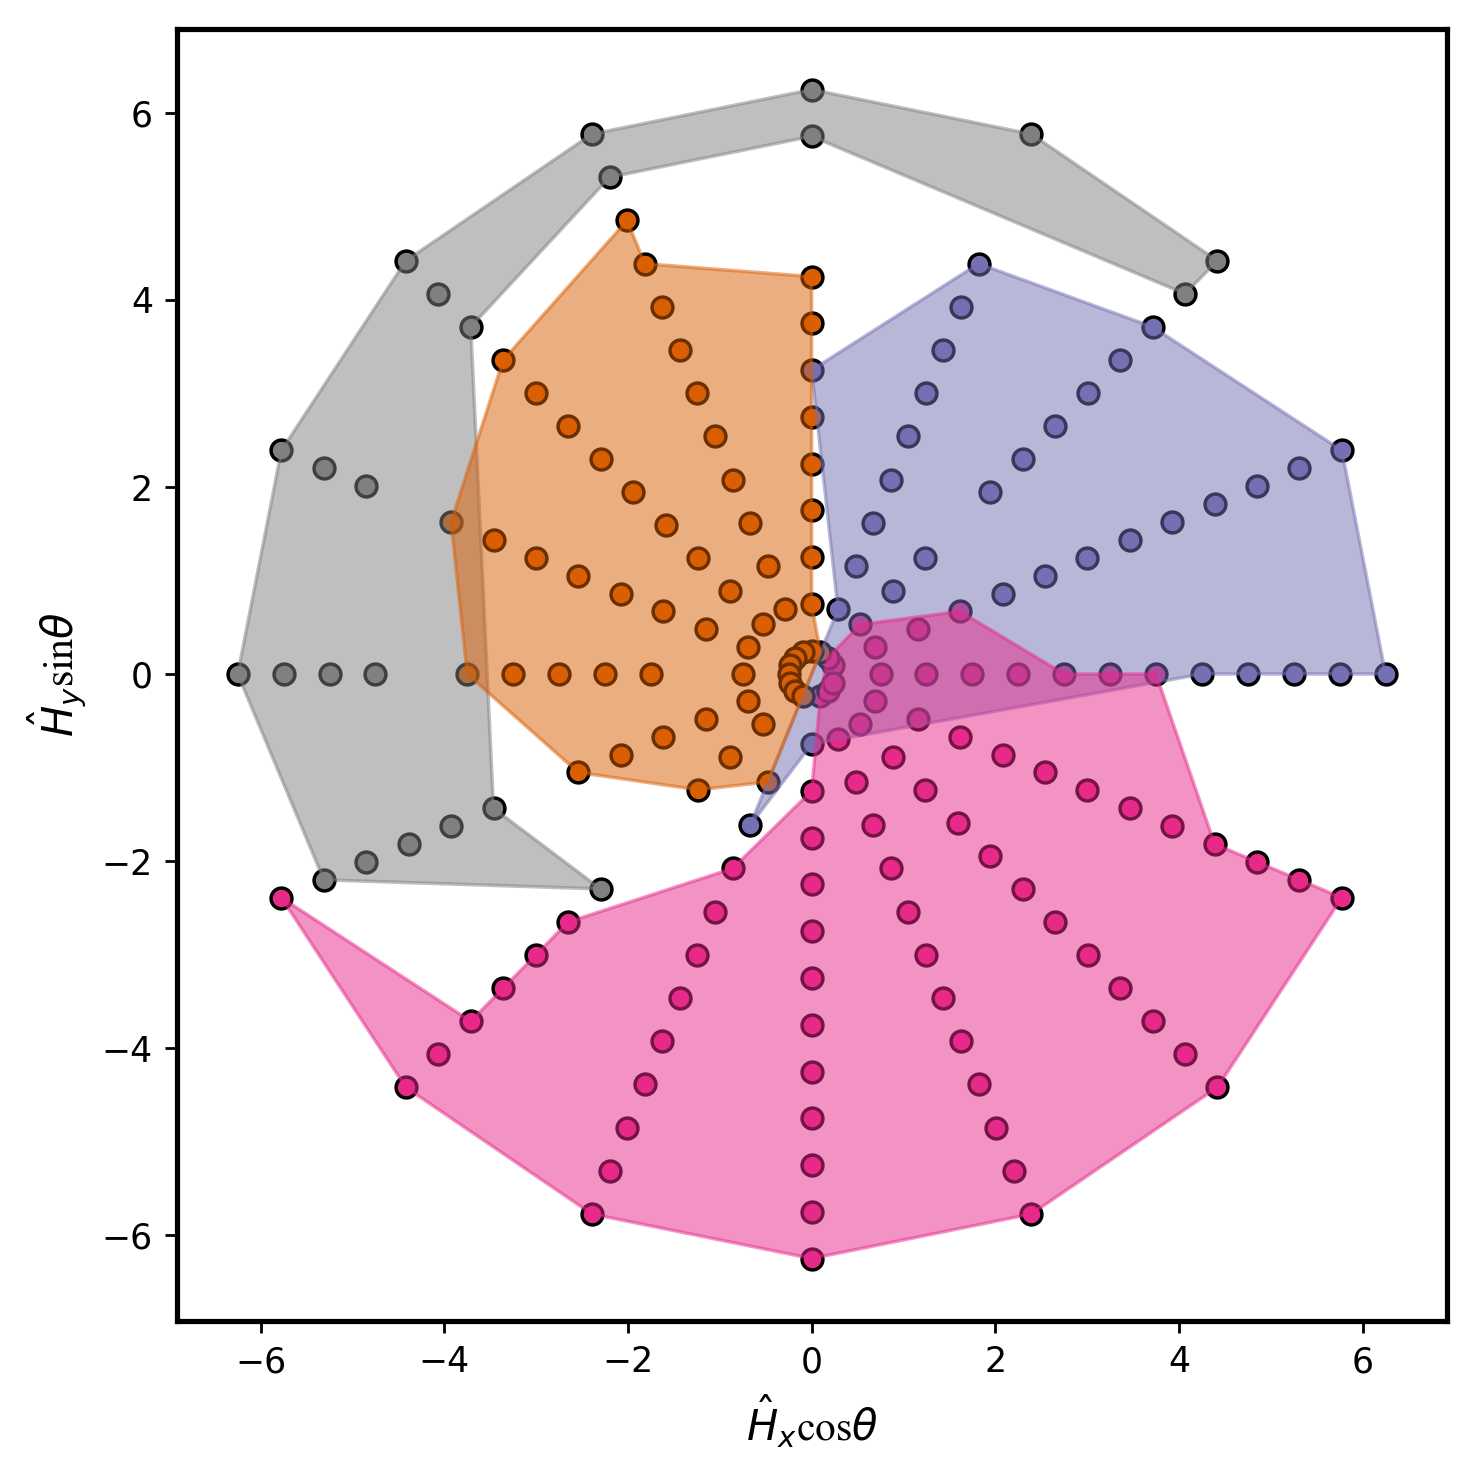

'            \n            \n    #2D Scatter of points (Include fill)\n\n    divData = HyData[HyData[\'State\'] == 0].copy()\n    divData = divData.sort_values(by=[\'parThetaBW\',\'parHx\'])\n    divData = divData.reset_index(drop=True)\n\n    VData = HyData[HyData[\'State\'] == 1].copy()\n    VData = VData.sort_values(by=[\'parThetaBW\',\'parHx\'])\n    VData = VData.reset_index(drop=True)\n\n    OData = HyData[HyData[\'State\'] == 2].copy()\n    OData = OData.sort_values(by=[\'parThetaBW\',\'parHx\'])\n    OData = OData.reset_index(drop=True)\n\n    HBData = HyData[HyData[\'State\'] == 3].copy()\n    HBData = HBData.sort_values(by=[\'parThetaBW\',\'parHx\'])\n    HBData = HBData.reset_index(drop=True)\n\n    fig, ax = plt.subplots(nrows=1,ncols=1,num=2,figsize=(6,6),dpi=250)\n    ax.set_xlabel(r\'$\\hat{H}_x$cos$\theta$\',fontsize=12,**csfont)\n    ax.set_ylabel(r\'$\\hat{H}_y$sin$\theta$\',fontsize=12,**csfont)\n\n    #Find boundary points\n    #Divergence\n    \n    if len(divData[

In [266]:
import alphashape
#Re = 10

#Diverge = 0: Red
#V-Shape = 1: Blue
#Orbit = 2: pink
#Headbutt = 3: orange
#NOTA = 4: black

endSimData = endData[1]

HyList = list(np.linspace(-4.5,4.5,10))
stateList = [0,1,2,3,4]
for Hy in HyList:
    print('Hy = ',Hy)
    #Hy Clip
    HyData = endSimData[endSimData['parHy'] <= Hy + 0.01].copy()
    HyData = HyData[HyData['parHy'] >= Hy - 0.01].copy()

    HyData = HyData.reset_index(drop=True)
        
    fig, ax = plt.subplots(nrows=1,ncols=1,num=2,figsize=(6,6),dpi=250)
    ax.set_xlabel(r'$\hat{H}_x$cos$\theta$',fontsize=12,**csfont)
    ax.set_ylabel(r'$\hat{H}_y$sin$\theta$',fontsize=12,**csfont)
    for state in stateList:
        print('state = ',state)
        data = HyData[HyData['State'] == state].copy()
        if len(data['parHx']) > 0:
            #print(data['parHx'])
            #print(data['parThetaBW'])
            data = data.sort_values(by=['parThetaBW','parHx'])
            data = data.reset_index(drop=True)
            
            points=np.column_stack((data['xval'].values.tolist(),data['yval'].values.tolist()))
            alpha = 0.95 * alphashape.optimizealpha(points)
            if alpha <= 0.1:
                alpha = 0.6
            #alpha = 1.0
            hull = alphashape.alphashape(points, alpha)
            boolHull = CheckGeometryCollection(hull)
            if boolHull:
                hull_pts = hull.exterior.coords.xy
            if data.loc[0,'State'] == 0:
                PlotPolarPlane(boolHull,hull_pts,data,(0.5,0.5,0.5))
            else:
                PlotPolarPlane(boolHull,hull_pts,data,(data.loc[0,'color_r']/255.0,data.loc[0,'color_g']/255.0,data.loc[0,'color_b']/255.0))
    fig.tight_layout()
    plt.show()
    strDir = cwd_PYTHON+"/../Figures/PhaseSpace/Re{0}/polar/".format(10)
    pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
    fig.savefig(strDir+'Re{0}_polar_Hy{1}_.png'.format(10,Hy))
    fig.clf()
    plt.close()
            
            


In [118]:
%matplotlib inline

def Construct_Image_Data(data):
    #From our color data and initial configurations, construct 2D mesh which has positions and colors for each position
    #If parHx and parHy do not exist, make color white
    xval = np.linspace(0.0,360.0 - 22.5,16)
    yval = np.linspace(-4.5,4.5,10)
    #print(xval)
    #print(yval)
    
    image = np.ones((10,16,3)) #idx, jdx, r, g, b
    
    for idx in range(len(xval)):
        xData = data[data['parThetaBW'] <= xval[idx] + 0.01].copy()
        xData = xData[xData['parThetaBW'] >= xval[idx] - 0.01].copy()
        for jdx in range(len(yval)):
            df = xData[xData['parHy'] <= yval[jdx]+0.01].copy()
            df = df[df['parHy'] >= yval[jdx]-0.01].copy()
            #print(len(df['parHy']))
            if(len(df['parHy']) == 1):
                image[jdx,idx,:] = [df['color_r'].values/255.0,df['color_g'].values/255.0,df['color_b'].values/255.0]
                
            else:
                image[jdx,idx,:] = [matplotlib.colors.to_rgb('white')[0],matplotlib.colors.to_rgb('white')[1],matplotlib.colors.to_rgb('white')[2]]
    
    return image

def Plot_Guess_Constant_Hx(data,ax):
    #Data Values
    parThetaBW   = data['parThetaBW']
    parHy   = data['parHy']
        
    image = Construct_Image_Data(data)
    
    #Create
    
    #GENERATE FIGURE
    #Phase Space  2D (Hy vs Hx)
    ax.scatter(parThetaBW,parHy,c=data['color_tuple'],s=9,marker='s')
    ax.imshow(image,cmap=None,extent=(-11.25,348.75,-5.0,5.0),alpha=0.25,origin='lower',aspect=360.0/10.0)
    data = data[data['color'] != 'gray'].copy()
    data = data.reset_index(drop=True)
    
    return ax

def CheckThetaDifference(allData,idx):
    if idx == 0:
        #Rules: Try 1 (DOES NOT WORK)
        if (allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_V1'] or
           allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_V2']):
            #Guessing V
            #print('jdx = {0}: guess is V'.format(jdx))
            allData.loc[jdx,'guess'] = 1
            allData.loc[jdx,'color_r'] = 117
            allData.loc[jdx,'color_g'] = 112
            allData.loc[jdx,'color_b'] = 179
        elif allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_HB']:
            #Guessing HB
            #print('jdx = {0}: guess is HB'.format(jdx))
            allData.loc[jdx,'guess'] = 3
            allData.loc[jdx,'color_r'] = 217
            allData.loc[jdx,'color_g'] = 95
            allData.loc[jdx,'color_b'] = 2
        elif (allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_SF1'] or
           allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_SF2']):
            #Guessing SF
            #print('jdx = {0}: guess is SF'.format(jdx))
            allData.loc[jdx,'guess'] = 2
            allData.loc[jdx,'color_r'] = 27
            allData.loc[jdx,'color_g'] = 158
            allData.loc[jdx,'color_b'] = 119
    elif idx == 1:
        if (allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_V1'] or
           allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_V2']):
            #Guessing V
            allData.loc[jdx,'guess'] = 1
            allData.loc[jdx,'color_r'] = 117
            allData.loc[jdx,'color_g'] = 112
            allData.loc[jdx,'color_b'] = 179
        elif allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_HB']:
            #Guessing HB
            allData.loc[jdx,'guess'] = 3
            allData.loc[jdx,'color_r'] = 217
            allData.loc[jdx,'color_g'] = 95
            allData.loc[jdx,'color_b'] = 2
        elif allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_O']:                
            #Guessing O
            allData.loc[jdx,'guess'] = 2
            allData.loc[jdx,'color_r'] = 231
            allData.loc[jdx,'color_g'] = 41
            allData.loc[jdx,'color_b'] = 138
    return allData

def CheckHyThetaDifference(allData, idx):
    if idx == 0:
        if (
            allData.loc[jdx,'dHy_min'] == allData.loc[jdx,'dHy_V'] and
            allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_V']):
            #Guessing V
            #print('jdx = {0}: guess is V'.format(jdx))
            allData.loc[jdx,'guess'] = 1
            allData.loc[jdx,'color_r'] = 117
            allData.loc[jdx,'color_g'] = 112
            allData.loc[jdx,'color_b'] = 179
        elif (allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_HB'] and 

              allData.loc[jdx,'dHy_min'] == allData.loc[jdx,'dHy_HB']):
            #Guessing HB
            #print('jdx = {0}: guess is HB'.format(jdx))
            allData.loc[jdx,'guess'] = 3
            allData.loc[jdx,'color_r'] = 217
            allData.loc[jdx,'color_g'] = 95
            allData.loc[jdx,'color_b'] = 2
        elif ((allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_SF1'] or
               allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_SF2']) and 

              (allData.loc[jdx,'dHy_min'] == allData.loc[jdx,'dHy_SF1'] or 
               allData.loc[jdx,'dHy_min'] == allData.loc[jdx,'dHy_SF2']) ):
            #Guessing SF
            #print('jdx = {0}: guess is SF'.format(jdx))
            allData.loc[jdx,'guess'] = 2
            allData.loc[jdx,'color_r'] = 27
            allData.loc[jdx,'color_g'] = 158
            allData.loc[jdx,'color_b'] = 119
        else:
            #No Guess
            allData.loc[jdx,'color_r'] = 128
            allData.loc[jdx,'color_g'] = 128
            allData.loc[jdx,'color_b'] = 128
    elif idx == 1:
        if (allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_V'] and 

            allData.loc[jdx,'dHy_min'] == allData.loc[jdx,'dHy_V']):
            #Guessing V
            #print('jdx = {0}: guess is V'.format(jdx))
            allData.loc[jdx,'guess'] = 1
            allData.loc[jdx,'color_r'] = 117
            allData.loc[jdx,'color_g'] = 112
            allData.loc[jdx,'color_b'] = 179
        elif (allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_HB'] and 

              allData.loc[jdx,'dHy_min'] == allData.loc[jdx,'dHy_HB']):
            #Guessing HB
            #print('jdx = {0}: guess is HB'.format(jdx))
            allData.loc[jdx,'guess'] = 3
            allData.loc[jdx,'color_r'] = 217
            allData.loc[jdx,'color_g'] = 95
            allData.loc[jdx,'color_b'] = 2
        elif (allData.loc[jdx,'dT_min'] == allData.loc[jdx,'dT_O'] and 

              allData.loc[jdx,'dHy_min'] == allData.loc[jdx,'dHy_O']):
            #Guessing O
            #print('jdx = {0}: guess is O'.format(jdx))
            allData.loc[jdx,'guess'] = 2
            allData.loc[jdx,'color_r'] = 231
            allData.loc[jdx,'color_g'] = 41
            allData.loc[jdx,'color_b'] = 138
        else:
            #No Guess
            allData.loc[jdx,'color_r'] = 128
            allData.loc[jdx,'color_g'] = 128
            allData.loc[jdx,'color_b'] = 128
    return allData
    
def ScoreTheta(dataTheta):
    score = np.zeros(len(dataTheta))
    for idx in range(len(dataTheta)):
        dTheta = dataTheta[idx]
        if dTheta >= 0.0 and dTheta < 15.0:
            score[idx] = 5
        elif dTheta >= 15.0 and dTheta < 45.0:
            score[idx] = 3
        elif dTheta >= 45.0 and dTheta < 90.0:
            score[idx] = 1
        else:
            score[idx] = 0
    return score

def ScoreHx(dataHx):
    score = np.zeros(len(dataHx))
    for idx in range(len(dataHx)):
        dHx = dataHx[idx]
        if dHx >= 0.0 and dHx < 0.5:
            score[idx] = 5
        elif dHx >= 0.5 and dHx < 2.5:
            score[idx] = 3
        elif dHx >= 2.5 and dHx < 4.5:
            score[idx] = 1
        else:
            score[idx] = 0
    return score

def ScoreHy(dataHy):
    score = np.zeros(len(dataHy))
    for idx in range(len(dataHy)):
        dHy = dataHy[idx]
        if dHy >= 0.0 and dHy < 0.5:
            score[idx] = 5
        elif dHy >= 0.5 and dHy < 2.5:
            score[idx] = 3
        elif dHy >= 2.5 and dHy < 4.5:
            score[idx] = 1
        else:
            score[idx] = 0
    return score

#From endData, calculate delta(Hx,Hy,Theta) for each known stable config. 
#See if smallest deviations are the preferred stable configs

#Create a database with average Hx, Hy, and theta for each stable config for each Re
database = []
#Diverge = 0
#V-Shape = 1
#In-line = 2
#Headbutt = 3
#L-shape = 4
Re2dict = {'H_V':[4.8],'Hx_V':[4.3],'Hy_V':[-2.1],'Theta_V':[305.0],
           'H_SF':[4.6],'Hx_SF':[0.0],'Hy_SF1':[4.6],'Hy_SF2':[-4.6],'Theta_SF':[0.0],
           'H_HB':[3.4],'Hx_HB':[0.0],'Hy_HB':[3.4],'Theta_HB':[180.0]}
Re2endData = pd.DataFrame(data=Re2dict)
database.append(Re2endData)

#Diverge = 0: Red
#V-Shape = 1: Blue
#Orbit = 2: pink
#NOTA = 3: black
Re10dict = {'H_V':[2.98],'Hx_V':[2.89],'Hy_V':[-0.74],'Theta_V':[331.0],
            'H_O':[3.06],'Hx_O':[2.6],'Hy_O':[-1.6],'Theta_O':[180.0],
            'H_HB':[3.375],'Hx_HB':[0.0],'Hy_HB':[3.375],'Theta_HB':[180.0]}
Re10endData = pd.DataFrame(data=Re10dict)
database.append(Re10endData)


for idx in range(0,len(ReList)):
    Re = ReList[idx]
    stableData = database[idx]
    allData = pd.read_csv(cwd_PYTHON+'/endData_Re{0}_.csv'.format(Re),delimiter=' ')
    allData = allData[allData['State'] != 0].copy()
    allData = allData.sort_values(by=['parHx','parHy','parThetaBW'])
    allData = allData.reset_index(drop=True)
    #Calculate dHx, dHy, dTheta for each stable config
    #V
    allData['dHx_V'] = abs(stableData.loc[0,'Hx_V'] - allData['parHx'])
    allData['dHy_V'] = abs(stableData.loc[0,'Hy_V'] - allData['parHy'])
    allData['dT_V1'] = abs(stableData.loc[0,'Theta_V'] - allData['parThetaBW'])
    allData['dT_V2'] = abs(stableData.loc[0,'Theta_V'] - allData['parThetaBW'] - 360.0)
    #print(allData['dT_V'].head())
    #allData['dT_V1'] *= np.pi/180.0
    #allData['dT_V2'] *= np.pi/180.0
    #HB
    allData['dHx_HB'] = abs(stableData.loc[0,'Hx_HB'] - allData['parHx'])
    allData['dHy_HB'] = abs(stableData.loc[0,'Hy_HB'] - allData['parHy'])
    allData['dT_HB'] = abs(stableData.loc[0,'Theta_HB'] - allData['parThetaBW'])
    #allData['dT_HB'] *= np.pi/180.0
    if idx == 0:
        #SF
        allData['dHx_SF'] = abs(stableData.loc[0,'Hx_SF'] - allData['parHx'])
        allData['dHy_SF1'] = abs(stableData.loc[0,'Hy_SF1'] - allData['parHy'])
        allData['dHy_SF2'] = abs(stableData.loc[0,'Hy_SF2'] - allData['parHy'])
        allData['dT_SF1'] = abs(stableData.loc[0,'Theta_SF'] - allData['parThetaBW'])
        allData['dT_SF2'] = abs(stableData.loc[0,'Theta_SF'] - allData['parThetaBW'] + 360.0)
        #allData['dT_SF1'] *= np.pi/180.0
        #allData['dT_SF2'] *= np.pi/180.0
    elif idx == 1:
        #O
        allData['dHx_O'] = abs(stableData.loc[0,'Hx_O'] - allData['parHx'])
        allData['dHy_O'] = abs(stableData.loc[0,'Hy_O'] - allData['parHy'])
        allData['dT_O'] = abs(stableData.loc[0,'Theta_O'] - allData['parThetaBW'])
        #allData['dT_O'] *= np.pi/180.0

    #From these delta's, attempt a guess at the stable config
    #Let's first try smallest dTheta
    allData['dT_min'] = 0
    allData['guess'] = 0
    #allData['dT_v'], allData['dT_SF']
    for jdx in range(len(allData['dT_HB'])):
        allData.loc[jdx,'dT_V'] = np.amin(np.array([allData.loc[jdx,'dT_V1'],allData.loc[jdx,'dT_V2']]))
        if idx == 0:
            allData.loc[jdx,'dT_SF'] = np.amin(np.array([allData.loc[jdx,'dT_SF1'],allData.loc[jdx,'dT_SF2']]))
                        
    #Score delta values
    #Theta
    allData['score_T_V'] = ScoreTheta(allData['dT_V'])
    allData['score_T_HB'] = ScoreTheta(allData['dT_HB'])
    #Hx
    allData['score_Hx_V'] = ScoreHx(allData['dHx_V'])
    allData['score_Hx_HB'] = ScoreHx(allData['dHx_HB'])
    #Hy
    allData['score_Hy_V'] = ScoreHy(allData['dHy_V'])
    allData['score_Hy_HB'] = ScoreHy(allData['dHy_HB'])
    #Total scores for each stable config
    allData['score_V'] = allData['score_T_V'] + allData['score_Hx_V'] + allData['score_Hy_V']
    allData['score_HB'] = allData['score_T_HB'] + allData['score_Hx_HB'] + allData['score_Hy_HB']
    if idx == 0:
        allData['score_T_SF'] = ScoreTheta(allData['dT_SF'])
        allData['score_Hx_SF'] = ScoreHx(allData['dHx_SF'])
        allData['score_Hy_SF1'] = ScoreHy(allData['dHy_SF1'])
        allData['score_Hy_SF2'] = ScoreHy(allData['dHy_SF2'])
        allData['score_SF1'] = allData['score_T_SF'] + allData['score_Hx_SF'] + allData['score_Hy_SF1']
        allData['score_SF2'] = allData['score_T_SF'] + allData['score_Hx_SF'] + allData['score_Hy_SF2']
    elif idx == 1:
        allData['score_T_O'] = ScoreTheta(allData['dT_O'])
        allData['score_Hx_O'] = ScoreHx(allData['dHx_O'])
        allData['score_Hy_O'] = ScoreHy(allData['dHy_O'])
        allData['score_O'] = allData['score_T_O'] + allData['score_Hx_O'] + allData['score_Hy_O']
    for jdx in range(len(allData['dT_HB'])):
        #Find which stable state has best score
        if idx == 0:
            allData.loc[jdx,'score_SF'] = np.amax(np.array(allData.loc[jdx,'score_SF1'],allData.loc[jdx,'score_SF2']))
            maxScore = np.amax(np.array([allData.loc[jdx,'score_V'],allData.loc[jdx,'score_HB'],allData.loc[jdx,'score_SF']]))
            if maxScore == allData.loc[jdx,'score_V']:
                #Guessing V
                #print('jdx = {0}: guess is V'.format(jdx))
                allData.loc[jdx,'guess'] = 1
                allData.loc[jdx,'color_r'] = 117
                allData.loc[jdx,'color_g'] = 112
                allData.loc[jdx,'color_b'] = 179
            elif maxScore == allData.loc[jdx,'score_HB']:
                #Guessing HB
                #print('jdx = {0}: guess is HB'.format(jdx))
                allData.loc[jdx,'guess'] = 3
                allData.loc[jdx,'color_r'] = 217
                allData.loc[jdx,'color_g'] = 95
                allData.loc[jdx,'color_b'] = 2
            elif maxScore == allData.loc[jdx,'score_SF']:
                #Guessing SF
                #print('jdx = {0}: guess is SF'.format(jdx))
                allData.loc[jdx,'guess'] = 2
                allData.loc[jdx,'color_r'] = 27
                allData.loc[jdx,'color_g'] = 158
                allData.loc[jdx,'color_b'] = 119 
        elif idx == 1:
            #Find which stable pair has best score
            maxScore = np.amax(np.array([allData.loc[jdx,'score_V'],allData.loc[jdx,'score_HB'],allData.loc[jdx,'score_O']]))
            if maxScore == allData.loc[jdx,'score_V']:
                #Guessing V
                #print('jdx = {0}: guess is V'.format(jdx))
                allData.loc[jdx,'guess'] = 1
                allData.loc[jdx,'color_r'] = 117
                allData.loc[jdx,'color_g'] = 112
                allData.loc[jdx,'color_b'] = 179
            elif maxScore == allData.loc[jdx,'score_HB']:
                #Guessing HB
                #print('jdx = {0}: guess is HB'.format(jdx))
                allData.loc[jdx,'guess'] = 3
                allData.loc[jdx,'color_r'] = 217
                allData.loc[jdx,'color_g'] = 95
                allData.loc[jdx,'color_b'] = 2
            elif maxScore == allData.loc[jdx,'score_O']:
                #Guessing O
                allData.loc[jdx,'guess'] = 2
                allData.loc[jdx,'color_r'] = 231
                allData.loc[jdx,'color_g'] = 41
                allData.loc[jdx,'color_b'] = 138

        
    '''
    for jdx in range(len(allData['dT_HB'])):
        allData.loc['dT_V'] = np.amin(np.array([allData.loc[jdx,'dT_V1'],allData.loc[jdx,'dT_V2']]))
        if idx == 0:
            allData.loc['dT_SF'] = np.amin(np.array([allData.loc[jdx,'dT_SF1'],allData.loc[jdx,'dT_SF2']]))
            allData.loc[jdx,'dT_min'] = np.amin(np.array([allData.loc[jdx,'dT_V'],allData.loc[jdx,'dT_HB'],allData.loc[jdx,'dT_SF']]))
            allData.loc[jdx,'dHx_min'] = np.amin(np.array([allData.loc[jdx,'dHx_V'],allData.loc[jdx,'dHx_HB'],allData.loc[jdx,'dHx_SF']]))
            allData.loc[jdx,'dHy_min'] = np.amin(np.array([allData.loc[jdx,'dHy_V'],allData.loc[jdx,'dHy_HB'],allData.loc[jdx,'dHy_SF1'],allData.loc[jdx,'dHy_SF2']]))
            #allData = CheckThetaDifference(allData,idx)
            #allData = CheckHyThetaDifference(allData,idx)
        elif idx == 1:
            allData.loc[jdx,'dT_min'] = np.amin(np.array([allData.loc[jdx,'dT_V'],allData.loc[jdx,'dT_HB'],allData.loc[jdx,'dT_O']]))
            allData.loc[jdx,'dHx_min'] = np.amin(np.array([allData.loc[jdx,'dHx_V'],allData.loc[jdx,'dHx_HB'],allData.loc[jdx,'dHx_O']]))
            allData.loc[jdx,'dHy_min'] = np.amin(np.array([allData.loc[jdx,'dHy_V'],allData.loc[jdx,'dHy_HB'],allData.loc[jdx,'dHy_O']]))
            #allData = CheckThetaDifference(allData,idx)
            #allData = CheckHyThetaDifference(allData,idx)
    '''

    #Okay, now that we have guesses, let's plot the 2D slices: for each Hx
    #This will of course not include diverging data
    boolPlot = 1
    if boolPlot:
        for Hx in HxList:
            data = allData[allData['parHx'] <= float(Hx)/2.0+0.01].copy()
            data = data[data['parHx'] >= float(Hx)/2.0-0.01].copy()
            data = data.sort_values(by=['parThetaBW','parHy'])
            data = data.reset_index(drop=True)

            #Create color_tuple and find average rotational velocity
            data['color_tuple'] = 's'
            for jdx in range(len(data['color'])):
                #data.at[idx,'color_tuple'] = (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0)
                data = data.set_value(jdx,'color_tuple', (data.loc[jdx,'color_r']/255.0,data.loc[jdx,'color_g']/255.0,data.loc[jdx,'color_b']/255.0))

            #Create Figure
            if idx == 1:
                if ((float(Hx)/2.0+0.01 >= 2.75) and (float(Hx)/2.0-0.01 <= 2.75)):
                    temp = data[data['parHy'] <= -1.5+0.01].copy()
                    temp = temp[temp['parHy'] >= -1.5 - 0.01].copy()
                    print('Theta = ',temp['parThetaBW'])
                    print('Hx_O = ',temp['dHx_O'])
                    print('Hx_HB = ',temp['dHx_HB'])
                    print('Hy_O = ',temp['dHy_O'])
                    print('Hy_HB = ',temp['dHy_HB'])
                    print('V = ',temp['score_V'])
                    print('HB = ',temp['score_HB'])
                    print('O = ',temp['score_O'])
                    print('score_O_Hx = ',temp['score_Hx_O'])
                    print('score_HB_Hx = ',temp['score_Hx_HB'])
                    print('guess = ',temp['guess'])
                    
                    
            fig, ax = plt.subplots(nrows=1,ncols=1,num=2,figsize=(6,6),dpi=250)
            ax.set_title(r'$\hat{H}_x$ = %.2f: $\hat{H}_y$ vs. $\theta$'%(float(Hx)/2.0),fontsize=15,**csfont)
            ax.set_xlabel(r'$\theta_{bw}$',fontsize=12,**csfont)
            ax.set_ylabel(r'$\hat{H}_y$',fontsize=12,**csfont)
            ax.axis([-11.25,348.75,-5.0,5.0])
            ax.set_aspect('equal')
            ax = Plot_Guess_Constant_Hx(data,ax)
            #2D PLOTS
            fig.tight_layout()
            ax = set_size(6,6,ax)
            #plt.show()
            #sys.exit(0)
            strDir = cwd_PYTHON+"/../Figures/PhaseSpace/Re{0}/Constant_Hx/Guess/".format(Re)
            pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
            fig.savefig(strDir+'Re{0}_Constant_Hx{1}_guess.png'.format(Re,float(Hx)/2.0))
            fig.clf()
            plt.close()

            print('Hx = '+Hx+' is complete!')
        
    
    

/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/ipykernel_launcher.py:389: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Hx = 0.5 is complete!
Hx = 1.5 is complete!
Hx = 2.5 is complete!
Hx = 3.5 is complete!
Hx = 4.5 is complete!
Hx = 5.5 is complete!
Hx = 6.5 is complete!
Hx = 7.5 is complete!
Hx = 8.5 is complete!
Hx = 9.5 is complete!
Hx = 10.5 is complete!
Hx = 11.5 is complete!
Hx = 12.5 is complete!
Hx = 0.5 is complete!
Hx = 1.5 is complete!
Hx = 2.5 is complete!
Hx = 3.5 is complete!
Hx = 4.5 is complete!
Theta =  4        0.0
16      22.5
44      90.0
72     157.5
83     180.0
134    337.5
Name: parThetaBW, dtype: float64
Hx_O =  4      0.15
16     0.15
44     0.15
72     0.15
83     0.15
134    0.15
Name: dHx_O, dtype: float64
Hx_HB =  4      2.75
16     2.75
44     2.75
72     2.75
83     2.75
134    2.75
Name: dHx_HB, dtype: float64
Hy_O =  4      0.1
16     0.1
44     0.1
72     0.1
83     0.1
134    0.1
Name: dHy_O, dtype: float64
Hy_HB =  4      4.875
16     4.875
44     4.875
72     4.875
83     4.875
134    4.875
Name: dHy_HB, dtype: float64
V =  4      11.0
16      9.0
44      8.0
72  

In [41]:
#Visualize Re=10, Theta = 0, Hx = 1.25, Hy = -5.5

def PlotSwimmersRe7(data,trajData,ax):
    global PERIOD,RADIUSLARGE,RADIUSSMALL
    #Data Values
    val1    = data['Hx']
    val2    = data['Hy']
    xU      = data['bXU']
    xL      = data['bXL']
    yU      = data['bYU']
    yL      = data['bYL']
    
    #GENERATE FIGURE
    #Phase Space  2D (Hy vs Hx)
    ax.plot(trajData['Hx'],trajData['Hy'],color='b',zorder=5)
    ax.plot(trajData['bXL'],trajData['bYL'],color='k',zorder=5)
    ax.scatter(data.loc[0,'Hx'],data.loc[0,'Hy'],c='tab:green',s=12,marker='s',zorder=6)
    ax.scatter(data.loc[0,'parHx'],data.loc[0,'parHy'],c='tab:red',s=12,marker='s',zorder=6)
    
    #Add Swimmer locations
    Circle1 = plt.Circle((0.0,0.5),1.0,color='k', clip_on=True)
    ax.add_artist(Circle1)
    Circle2 = plt.Circle((0.0,-2.0),0.5,color='k', clip_on=True)
    ax.add_artist(Circle2)
    Circle3 = plt.Circle((xU,yU),1.0,color=(0.5,)*3, clip_on=True)
    ax.add_artist(Circle3)
    Circle4 = plt.Circle((xL,yL),0.5,color=(0.5,)*3, clip_on=True)
    ax.add_artist(Circle4)
    
    #Add swimmers but now they are fully expanded
    AMP = 0.8
    xUA, yUA = xU + 0.2*AMP*data['nTx'], yU + 0.2*AMP*data['nTy']
    xLA, yLA = xL - 0.8*AMP*data['nTx'], yL - 0.8*AMP*data['nTy']
    Circle9 = plt.Circle((0.0,0.5+0.2*AMP),1.0, clip_on=True,fill=False,edgecolor='green')
    ax.add_artist(Circle9)
    Circle10 = plt.Circle((0.0,-2.0-0.8*AMP),0.5, clip_on=True,fill=False,edgecolor='green')
    ax.add_artist(Circle10)
    Circle11 = plt.Circle((xUA,yUA),1.0, clip_on=True,fill=False,edgecolor='red')
    ax.add_artist(Circle11)
    Circle12 = plt.Circle((xLA,yLA),0.5, clip_on=True,fill=False,edgecolor='red')
    ax.add_artist(Circle12)
    
    #Plot boundary layer thickness around spheres
    #OMEGA = 2.0*np.pi/PERIOD
    AMP_SMALL = RADIUSLARGE*0.8*0.8
    delta = np.sqrt(AMP_SMALL*RADIUSSMALL/7.0)
    delta_norm = delta/RADIUSLARGE
    Circle5 = plt.Circle((0.0,0.5),1.0+delta_norm, clip_on=True,fill=False,edgecolor='orange')
    ax.add_artist(Circle5)
    Circle6 = plt.Circle((0.0,-2.0),0.5+delta_norm, clip_on=True,fill=False,edgecolor='orange')
    ax.add_artist(Circle6)
    Circle7 = plt.Circle((xU,yU),1.0+delta_norm, clip_on=True,fill=False,edgecolor='orange')
    ax.add_artist(Circle7)
    Circle8 = plt.Circle((xL,yL),0.5+delta_norm, clip_on=True,fill=False,edgecolor='orange')
    ax.add_artist(Circle8)
    
    return ax
#Hx, Hy, Theta = 1.25, -5.5, 0.0
#Hx, Hy, Theta = 2.75, -4.5, 0.0
#Hx, Hy, Theta = 4.25, 0.5, 0.0
#Hx, Hy, Theta = 3.75, -4.5, 0.0
#Hx, Hy, Theta = 4.25, -4.5, 0.0
HxValues = [3.75,4.25,1.25,2.75,4.25,3.75,4.25]
HyValues = [-2.5,-2.5,-5.5,-4.5,0.5,-4.5,-4.5]
ThetaValues = [112.5,135.0,0.0,0.0,0.0,0.0,0.0]
Re7data = allData.copy()
for jdx in range(len(HxValues)):
    if jdx == 1:
        sys.exit(0)
    Hx = HxValues[jdx]
    Hy = HyValues[jdx]
    Theta = ThetaValues[jdx]
    print('Hx = {0}: Hy = {1}: Theta = {2}'.format(Hx,Hy,Theta))
    thetaData = Re7data[Re7data['parThetaBW'] <= Theta + 0.01].copy()
    thetaData = thetaData[thetaData['parThetaBW'] >= Theta - 0.01].copy()
    HxData = thetaData[thetaData['parHx'] <= Hx + 0.01].copy()
    HxData = HxData[HxData['parHx'] >= Hx - 0.01].copy()
    HyData = HxData[HxData['parHy'] <= Hy + 0.01].copy()
    HyData = HyData[HyData['parHy'] >= Hy - 0.01].copy()
    HyData = HyData.sort_values(by=['time'])
    HyData = HyData.reset_index(drop=True)
    #print(HyData)
    #sys.exit(0)
    #Calculate out sphere placements
    HyData['nTx'] = np.cos(HyData['Theta'] + np.pi/2.0)
    HyData['nTy'] = np.sin(HyData['Theta'] + np.pi/2.0)
    HyData['bXU'] = HyData['Hx'] + 0.5*HyData['nTx']
    HyData['bYU'] = HyData['Hy'] + 0.5*HyData['nTy']
    HyData['bXL'] = HyData['Hx'] - 2.0*HyData['nTx']
    HyData['bYL'] = HyData['Hy'] - 2.0*HyData['nTy']
    print(len(HyData['time']))
    for idx in range(len(HyData['time'])):
        HyData.loc[idx,'time'] = np.round(HyData.loc[idx,'time'],1)
    #print(HyData['time'])
    for idxTime in range(len(HyData['time'])):
        time = np.round(PERIOD*idxTime,1)
        data = HyData[HyData['time'] == time].copy()
        #data = HyData[HyData['time'] <= time+0.01].copy()
        #data = data[data['time'] >= time - 0.01].copy()
        data = data.reset_index(drop=True)
        #print(data)
        assert len(data['time']) == 1
        #Get traj data
        trajData = HyData[HyData['time'] <= time].copy()
        trajData = trajData.reset_index(drop=True)
        #2D PHASE SPACE PLOTS (Hy vs Hx) Configurations and Dynamics
        #Figure and subplot for each Theta
        fig, ax = plt.subplots(nrows=1,ncols=1,num=1,figsize=(6,6),dpi=250)
        ax.set_title(r'time =%.1f: $\theta$ = %s: $H_y$ vs. $H_x$'%(time,Theta),fontsize=15,**csfont)
        ax.set_xlabel(r'$H_x$',fontsize=12,**csfont)
        ax.set_ylabel(r'$H_y$',fontsize=12,**csfont)
        ax.axis([-1.0,max(6.0,np.amax(trajData['bXU'])+1.0),-8.0,2.5])
        ax.set_aspect('equal')
        #Plot Swimmers and Traj Data
        ax = PlotSwimmersRe7(data,trajData,ax)
        #2D PLOTS
        fig.tight_layout()
        #plt.show()
        #sys.exit(0)
        strDir = cwd_PYTHON+"/../Figures/IndSims/Re7/T{0}_Hx{1}_Hy{2}/".format(Theta,Hx,Hy)
        pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
        fig.savefig(strDir+'Traj_T{0}_Hx{1}_Hy{2}_{3}_.png'.format(Theta,Hx,Hy,idxTime))
        fig.clf()
        plt.close()
        if idxTime % 20 == 0:
            print('time = ',time)


Hx = 3.75: Hy = -2.5: Theta = 112.5
201
time =  0.0
time =  2.0
time =  4.0
time =  6.0
time =  8.0
time =  10.0
time =  12.0
time =  14.0
time =  16.0
time =  18.0
time =  20.0


SystemExit: 0

In [42]:
#Make movies
Hx, Hy, Theta = 3.75, -2.5, 112.5
os.chdir(cwd_PYTHON+"/../Figures/IndSims/Re7/T{0}_Hx{1}_Hy{2}/".format(Theta,Hx,Hy))
os.system("ffmpeg -r 10 -i Traj_T112.5_Hx3.75_Hy-2.5_%d_.png -vcodec libx264 -pix_fmt yuv420p -y movie.mp4")
os.chdir(cwd_PYTHON)
sys.exit(0)
Hx, Hy, Theta = 4.25, -2.5, 135.0
os.chdir(cwd_PYTHON+"/../Figures/IndSims/Re7/T{0}_Hx{1}_Hy{2}/".format(Theta,Hx,Hy))
os.system("ffmpeg -r 10 -i Traj_T135.0_Hx4.25_Hy-2.5_%d_.png -vcodec libx264 -pix_fmt yuv420p -y movie.mp4")
os.chdir(cwd_PYTHON)
print("Done making movies")

SystemExit: 0